## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
### 此程式用於進一步調整 Vin Iout vs I in I out 兩種不同物理量輸入模型之差異 (也比較好解釋) ###
### 模型採用 經典的CNN 模型 但使用 wide input 與 multiscale brach 來更好的抓取訊號 ###
### 2025 0826 基於0825版本 但使用Agent 進行調整###



### 導入模型設定與套件 ###

In [29]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(42)

GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

In [20]:
# =============================================================================
# 導入必要的模組
# =============================================================================
from datetime import datetime
import json
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, AdditiveAttention

# =============================================================================
# 模型參數設定
# =============================================================================
# 基本參數
sequence_length = 1024
layer_number = 1
future_length = 512

# 模型儲存設定
model_folder_path = r'NTU_rul_models\CCAE_models'
model_name = f'0829_multiscale_CCAE_Base{sequence_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

# CNN 模型參數
WD_length = 64
WD_stride = 4
branch_kernels = (3, 5, 7)
enc_depth = 3
encoder_decay_rate = 0.5
base_filters = 64

# =============================================================================
# 多分支 CNN 自編碼器模型定義
# =============================================================================
def build_cnn_multi_branch_ae(
    input_dim_list,
    sequence_length,
    condition_dim,
    model_folder_path=None,
    model_name=None,
    iscondition=True,
    # 兩個 stem 分支的 kernel（固定為 64 與 32）
    stem_kernel_sizes=(64, 32),
    first_layer_filters=None,
    first_stride=1,
    # Encoder/Decoder 的卷積：固定 k=3, stride=1
    base_filters=32,
    blocks=3,
    decay=0.5,
    filters_per_block=None,
    # 反捲積（還原第一層 stride）kernel，預設沿用較大的 stem kernel
    deconv_kernel_size=None,
    # 是否學殘差：output_i = pred_i + input_i
    learn_residual=False,
):
    """
    兩幹道（stem）CNN 自編碼器：
    - 輸入端分兩個幹道：kernel size = 64 與 32（可套 FiLM）
    - 每個幹道都用 k=3 的 Encoder/Decoder（每層 MaxPool(2) / UpSampling(2)）
    - 各幹道各自用 Conv1DTranspose 還原 first_stride，之後再合併（Concat）
    - 合併後 1x1 Conv 融合（可再套 FiLM），最後輸出各通道群
    """
    import tensorflow as tf
    from tensorflow.keras.layers import (
        Input, Concatenate, Conv1D, Dense, UpSampling1D,
        MaxPooling1D, Reshape, Multiply, Add, Activation
    )
    from tensorflow.keras.models import Model

    try:
        from tensorflow.keras.layers import Conv1DTranspose
    except Exception as e:
        raise ImportError(
            "需要 tf.keras.layers.Conv1DTranspose（建議 TF/Keras 2.15+/Keras3）。"
        ) from e

    # === filters 配置 ===
    if filters_per_block is not None:
        f_list = [int(max(1, f)) for f in filters_per_block[:blocks]]
    else:
        f_list = [int(max(1, round(base_filters * (decay ** i)))) for i in range(blocks)]

    if first_layer_filters is None:
        first_layer_filters = base_filters

    if deconv_kernel_size is None:
        # 預設用較大的 stem kernel
        deconv_kernel_size = max(stem_kernel_sizes)

    # === 序列輸入（逐個輸入保留，方便殘差直連） ===
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        inputs.append(Input(shape=(sequence_length, input_dim), name=f'series_{idx}'))
    # concat 給幹道卷積
    series_input = inputs[0] if len(inputs) == 1 else Concatenate(axis=-1, name='series_input_concat')(inputs)

    # === 兩個條件輸入 ===
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

    # === 建立一個 FiLM 幫手 ===
    def apply_film(x, cond, width, gamma_name, beta_name, film_name):
        gamma = Dense(width, name=gamma_name)(cond)
        beta  = Dense(width, name=beta_name)(cond)
        gamma = Reshape((1, width))(gamma)
        beta  = Reshape((1, width))(beta)
        return Add(name=film_name)([Multiply()([x, gamma]), beta])

    # === 兩個 stem 分支（k=64 與 k=32）===
    stem_outputs = []
    for i, k in enumerate(stem_kernel_sizes):
        stem_conv = Conv1D(
            filters=first_layer_filters,
            kernel_size=k,
            strides=first_stride,
            padding='same',
            activation=None,
            name=f'stem{i+1}_conv_k{k}_s{first_stride}'
        )(series_input)
        if iscondition:
            stem_mod = apply_film(
                stem_conv, merged_condition, first_layer_filters,
                gamma_name=f'stem{i+1}_gamma', beta_name=f'stem{i+1}_beta',
                film_name=f'stem{i+1}_film'
            )
        else:
            stem_mod = stem_conv
        stem_out = Activation('relu', name=f'stem{i+1}_relu')(stem_mod)
        stem_outputs.append(stem_out)

    # === Encoder/Decoder（每個幹道固定用 k=3）===
    def enc_dec_branch(x, name_prefix, k=3):
        z = x
        # Encoder
        for b in range(blocks):
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_enc_c{b+1}_k{k}_s1'
            )(z)
            z = MaxPooling1D(pool_size=2, name=f'{name_prefix}_enc_p{b+1}')(z)
        # Decoder
        for b in reversed(range(blocks)):
            z = UpSampling1D(size=2, name=f'{name_prefix}_dec_u{blocks-b}_x2')(z)
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_dec_c{blocks-b}_k{k}'
            )(z)
        return z

    branches_after_ed = [
        enc_dec_branch(stem_outputs[0], name_prefix='branch_stem64', k=3),
        enc_dec_branch(stem_outputs[1], name_prefix='branch_stem32', k=3),
    ]

    # === 各分支各自還原第一層 stride ===
    branches_restored = []
    for i, z in enumerate(branches_after_ed, start=1):
        if first_stride > 1:
            z = Conv1DTranspose(
                filters=2,   # depthwise 風格，主要是恢復時間長度
                kernel_size=deconv_kernel_size,
                strides=first_stride,
                padding='same',
                activation='linear',
                name=f'branch{i}_undo_first_stride_deconv_dw_k{deconv_kernel_size}_s{first_stride}'
            )(z)
        branches_restored.append(z)

    # === 合併兩分支 ===
    merged = Concatenate(axis=-1, name='two_stems_merged')(branches_restored)

    # === 1x1 融合（FiLM #2 位置） ===
    fuse_width = max(f_list[0], first_layer_filters, base_filters)
    fused_linear = Conv1D(
        filters=fuse_width, kernel_size=1, padding='same',
        activation=None, name='fusion_conv1x1'
    )(merged)

    if iscondition:
        fused = apply_film(
            fused_linear, merged_condition, fuse_width,
            gamma_name='fusion_gamma', beta_name='fusion_beta',
            film_name='fusion_film'
        )
    else:
        fused = fused_linear

    fused = Activation('relu', name='fusion_relu')(fused)

    # === Output per input channel-group（每個輸出各自 Dense 到對應通道數） ===
    preds = [Dense(dim, activation='linear', name=f'pred_{idx}')(fused)
             for idx, dim in enumerate(input_dim_list)]

    # === learn_residual（pred_i + input_i） ===
    if learn_residual:
        outputs = []
        for idx, (pred_i, inp_i) in enumerate(zip(preds, inputs)):
            try:
                out_i = Add(name=f'output_residual_{idx}')([pred_i, inp_i])
            except Exception as e:
                raise ValueError(
                    f"[Residual Add] 維度不相容：pred_{idx} 與 series_{idx}。"
                    " 請確認 sequence_length 可被 2**blocks 整除，並避免因 Pool/UpSampling 造成長度漂移。"
                ) from e
            outputs.append(out_i)
    else:
        outputs = [tf.identity(p, name=f'output_{idx}') for idx, p in enumerate(preds)]

    model = Model(
        inputs=inputs + [condition_input_1, condition_input_2],
        outputs=outputs,
        name="CNN_DualStem_AE_FiLM"
    )
    return model

# =============================================================================
# 模型配置與建立
# =============================================================================

def create_model_and_metadata(model_config, model_suffix):
    """建立模型和對應的 metadata"""
    model = build_cnn_multi_branch_ae(**model_config)
    
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "trained": False,
        "train_date": None,
    }
    
    with open(os.path.join(model_path, model_name + model_suffix + '_metadata.json'), "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    
    return model

# 基本配置
base_config = {
    'input_dim_list': [2],
    'sequence_length': sequence_length,
    'condition_dim': 1,
    'stem_kernel_sizes': (64, 32),
    'first_stride': WD_stride,
    'base_filters': base_filters,
    'blocks': enc_depth,
    'decay': encoder_decay_rate,
}

# 模型配置清單
model_configs = [
    # VI model 陽春版 無condition 與殘差
    {**base_config, 'iscondition': False, 'learn_residual': False},
    # VI 加入殘差
    {**base_config, 'iscondition': False, 'learn_residual': True},
    # VI 加入殘差與condition
    {**base_config, 'iscondition': True, 'learn_residual': True},
    # I to I model
    {**base_config, 'iscondition': False, 'learn_residual': False},
    # V to V model
    {**base_config, 'iscondition': False, 'learn_residual': False},
    # VI in VI out model
    {**{
    'input_dim_list': [4],
    'sequence_length': sequence_length,
    'condition_dim': 1,
    'stem_kernel_sizes': (WD_length, 32),
    'first_stride': WD_stride,
    'base_filters': base_filters,
    'blocks': enc_depth,
    'decay': encoder_decay_rate,
}
, 'iscondition': False, 'learn_residual': False},
]

model_suffixes = ['_VI', '_VI_res', '_VI_res_cond', '_II','_VV','_VI_in_VI_out']

# 建立所有模型
models = {}
for config, suffix in zip(model_configs, model_suffixes):
    models[suffix] = create_model_and_metadata(config, suffix)

# 解構模型變數（保持向後相容）
my_model_V_in_I_out = models['_VI']
my_model_V_in_I_out_res = models['_VI_res']
my_model_V_in_I_out_res_cond = models['_VI_res_cond']
my_model_I_in_I_out = models['_II']
my_model_V_in_V_out = models['_VV']
my_model_VI_in_VI_out = models['_VI_in_VI_out']

# =============================================================================
# 模型視覺化和輸出
# =============================================================================

# 儲存模型圖
for suffix, model in models.items():
    plot_model(
        model, 
        to_file=os.path.join(model_path, model_name + suffix + '.png'), 
        show_shapes=True, 
        show_layer_names=True
    )

# 輸出模型資訊
print("All Model saved and loaded successfully.")
for suffix, model in models.items():
    print(f"{model_name}{suffix} parameters: {model.count_params():,}")

All Model saved and loaded successfully.
0829_multiscale_CCAE_Base1024_VI parameters: 86,534
0829_multiscale_CCAE_Base1024_VI_res parameters: 86,534
0829_multiscale_CCAE_Base1024_VI_res_cond parameters: 87,686
0829_multiscale_CCAE_Base1024_II parameters: 86,534
0829_multiscale_CCAE_Base1024_VV parameters: 86,534
0829_multiscale_CCAE_Base1024_VI_in_VI_out parameters: 98,952


### 訓練資料前處理 ###

In [12]:
# =============================================================================
# 數據增強函數定義
# =============================================================================
import shutil
from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt
# 隨機切分函式 (訓練用)
def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    """
    從原始資料中隨機選取樣本進行數據增強
    """
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length = sequence_length + future_length  
    
    # 從原始資料df中隨機選取augmen_sample_number個起始點為sequence_length長度的序列樣本。
    # raw_data為n,4的序列資料，每一行分別為voltage alpha, voltage beta, current alpha, current beta
    
    # 資料增強倍率
    max_augment_factor = len(raw_data) - sequence_length + 1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)

    # 隨機選取augmen_sample_number個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成NumPy多維陣列
    final_data = np.array(samples_list)
    
    return final_data

# 均勻切分函式 (驗證用)
def data_interval_augmentation(raw_data, sequence_length, augmen_sample_number, future_length):
    """
    以等距起點切分固定長度序列（不隨機），並可指定切分數量。
    
    raw_data: shape (n, d)
    sequence_length: 視窗長度（滑動窗大小）
    num_samples: 期望切分的樣本數（會自動上限為最大可切數）

    回傳:
        final_data: shape (num_samples_eff, sequence_length, d)
    """
    n = len(raw_data)
    if sequence_length <= 0:
        raise ValueError("sequence_length 必須為正整數")
    if n < sequence_length:
        raise ValueError("資料長度不足以切出任何序列樣本")
    if augmen_sample_number <= 0:
        raise ValueError("num_samples 必須為正整數")

    # 最大可切的起點數（= 可切的樣本上限）
    max_possible = n - sequence_length + 1

    # 若要求超過上限，截到上限
    num_samples_eff = min(augmen_sample_number, max_possible)

    # 等距產生起點（含 0 與 max_possible-1）
    if num_samples_eff == 1:
        start_indices = np.array([0], dtype=int)
    else:
        step = (max_possible - 1) / (num_samples_eff - 1)
        start_indices = np.round(np.arange(num_samples_eff) * step).astype(int)
        start_indices = np.clip(start_indices, 0, max_possible - 1)

    # 依起點切片
    samples_list = [raw_data[s:s + sequence_length] for s in start_indices]
    final_data = np.array(samples_list)

    return final_data
# =============================================================================
# 電機參數設定
# =============================================================================
Fs = 20000  # 採樣頻率
Rs = 12.5   # 定子電阻
P = 4       # 極對數

# =============================================================================
# 數據集路徑設定
# =============================================================================
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets3_1'
normal_condition = 'Normal1'
normal_condition2 = 'Normal1-2'
Normal_data_path = os.path.join(NTU_dataset_path, normal_condition)
Normal_data_path2 = os.path.join(NTU_dataset_path, normal_condition2)

# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]
# 重複訓練資料夾
Normal_subfolders2 = [f.path for f in os.scandir(Normal_data_path2) if f.is_dir()]
print(Normal_subfolders2)
# 選擇特定的工況資料夾
selected_folder=[
    f"{normal_condition} 1200 1.0v 2kg cm2",
    f"{normal_condition} 1200 0.5v 2kg cm2",
    f"{normal_condition} 1200 2.0v 2kg cm2",
    f"{normal_condition} 1800 0.5v 2kg cm2",
    f"{normal_condition} 1800 2.0v 2kg cm2",
    f"{normal_condition} 1800 1.0v 2kg cm2",
    f"{normal_condition} 3000 1.0v 2kg cm2",
    f"{normal_condition} 3000 2.0v 2kg cm2",
    f"{normal_condition} 3000 0.5v 2kg cm2"
]
# 選擇與selected_folder名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]
for folder in Normal_subfolders:
    print(folder)
    
selected_folder2=[
    f"{normal_condition2} 1200 1.0v 2kg cm2",
    f"{normal_condition2} 1200 0.5v 2kg cm2",
    f"{normal_condition2} 1200 2.0v 2kg cm2",
    f"{normal_condition2} 1800 0.5v 2kg cm2",
    f"{normal_condition2} 1800 2.0v 2kg cm2",
    f"{normal_condition2} 1800 1.0v 2kg cm2",
    f"{normal_condition2} 3000 1.0v 2kg cm2",
    f"{normal_condition2} 3000 2.0v 2kg cm2",
    f"{normal_condition2} 3000 0.5v 2kg cm2"
]
Normal_subfolders2=[folder for folder in Normal_subfolders2 if any(sel in folder for sel in selected_folder2)]
for folder in Normal_subfolders2:
    print(folder)


['D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1 1200 0.5v 2 kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1 1200 1.0 v 2 kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1 1200 2.0v 2 kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1 1800 0.5v 2 kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1 1800 1.0v 2 kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1 1800 2.0v 2 kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1 3000 0.5v 2 kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1 3000 1.0v 2 kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\Normal1 3000 2.0v 2 kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\新增資料夾', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets3_1\\Normal1-2\\新增資料夾 (2)']
D:\OneDrive\CCAE_experiments\CCAE_d

### 訓練資料讀取 ###

In [13]:
# =============================================================================
# 訓練/驗證資料分割功能
# =============================================================================
# 建立驗證資料夾
if not os.path.exists(os.path.join(NTU_dataset_path, "validation")):
    os.makedirs(os.path.join(NTU_dataset_path, "validation"))
validation_folder_path = os.path.join(NTU_dataset_path, "validation")

def split_train_val_files(Normal_subfolders, test_size=0.2):
    """分割訓練和驗證檔案"""
    train_files = []
    val_files = []
    for folder in Normal_subfolders:
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        # 如果資料夾中有多於一個parquet檔案，則隨機進行分割
        if len(parquet_files) > 1:
            train, val = train_test_split(parquet_files, test_size=test_size)
            train_files.extend(train)
            val_files.extend(val)
        elif len(parquet_files) == 1:
            train_files.extend(parquet_files)
    return train_files, val_files

def copy_val_files_to_validation(val_files, validation_folder_path):
    for file_path in val_files:
        # 取得原始檔案所在的資料夾名稱
        class_name = os.path.basename(os.path.dirname(file_path))
        # 在validation資料夾下建立對應子資料夾
        class_folder = os.path.join(validation_folder_path, class_name)
        os.makedirs(class_folder, exist_ok=True)
        # 複製檔案到對應子資料夾
        shutil.copy(file_path, class_folder)


train_files1, val_files = split_train_val_files(Normal_subfolders, test_size=0.2)
train_files2, _ = split_train_val_files(Normal_subfolders2, test_size=0.2)
train_files=train_files1
# train_files = train_files1 + train_files2
# =============================================================================
# 數據讀取和處理
# =============================================================================
# 主要使用的變數
train_signals = []  # vi signals alpha beta 
train_signals_normalized = []
torque_array = []
speed_array_pu = []

# ❌ 未使用的變數（後續程式碼中未引用）
flux_signals = []  # emf flux signals alpha beta - 未使用
current_diff_array = []  # 未使用

for file_path in train_files:
    if os.path.exists(file_path):
        
        # 讀取資料
        df = read_rul_data(file_path, force_recompute=False)
        
        if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1:
            # 檢測極性校正是否失效
            print(f"File {file_path} has high THD, skipping.")
            continue
            
        current_alpha = np.array(df["Current alpha downsample"])
        current_beta = np.array(df["Current beta downsample"])
        flux_alpha = np.array(df["Flux alpha"])
        flux_beta = np.array(df["Flux beta"])
        
        emf_alpha = (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta = (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        
        torque_airgap = 1.5 * 4 * (flux_alpha * current_beta - flux_beta * current_alpha)  # 計算torque
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.mean(torque_airgap)
          
        torque = (df["Torque avg"]) 
        speed = (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals = [
            np.array(df["Voltage alpha downsample"]), 
            np.array(df["Voltage beta downsample"]),
            current_alpha,
            current_beta,
            flux_alpha,
            flux_beta,
            emf_alpha,
            emf_beta,
            torque_airgap
        ]
        
        temp_train_signals_normalized = []
        # 將數據標準化（均值為0，標準差為1）
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
                
        temp_train_signals_normalized[-1] = torque_airgap_normalized  # 改成std正規化的torque_airgap
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        
        augmen_sample_number = 500  # 增強樣本數量
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number, future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number, future_length=future_length)
        
        # 加入train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed / 3000)  # rate 3000 rpm 
        
    else:
        print(f"File {file_path} does not exist.")

# =============================================================================
# 數據後處理和分割
# =============================================================================        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)

# 隨機打亂訓練資料
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
train_input_signals = train_signals[:, :sequence_length, :]  # 取前sequence_length個
train_fit_signals = train_signals[:, -future_length:, :]  # 取最後future_length個

# 正規化訓練資料
train_signals_normalized = train_signals_normalized[indices]
train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
train_fit_signals_normalized = train_signals_normalized[:, -future_length:, :]

# 運轉條件資料
torque_array = torque_array[indices]
speed_array_pu = speed_array_pu[indices]
torque_array = torque_array.reshape(-1, 1)      # 將torque_array轉為n, 1 batch輸入狀態標籤
speed_array_pu = speed_array_pu.reshape(-1, 1)

# ========================================================================
# 🟢 實際使用的變數（訓練所需資料）
# =============================================================================
# 模型參考輸入
past_voltages = train_input_signals[:, :, 0:2]
past_currents = train_input_signals[:, :, 2:4]
past_fluxes = train_input_signals[:, :, 4:6]  # 使用過去的flux作為輸入
past_emf = train_input_signals[:, :, 6:8]  # 使用過去的emf作為輸入
past_airgap_torque = train_input_signals[:, :, 8:9]  # 使用過去的torque作為輸入

# 正規化資料
past_voltages_normalized = train_input_signals_normalized[:, :, 0:2]
past_currents_normalized = train_input_signals_normalized[:, :, 2:4]
past_fluxes_normalized = train_input_signals_normalized[:, :, 4:6]
past_emf_normalized = train_input_signals_normalized[:, :, 6:8]  # 使用過去的emf作為輸入
past_airgap_torque_normalized = train_input_signals_normalized[:, :, 8:9]  # 使用過去的torque作為輸入  

# 模型參考輸出
future_voltages = train_fit_signals[:, :, 0:2]
future_currents = train_fit_signals[:, :, 2:4]
future_fluxes = train_fit_signals[:, :, 4:6]
future_emf = train_fit_signals[:, :, 6:8]  # 使用過去的emf作為輸入
future_airgap_torque = train_fit_signals[:, :, 8:9]  # 使用未來的torque作為輸出

# 正規化資料
future_voltages_normalized = train_fit_signals_normalized[:, :, 0:2]
future_currents_normalized = train_fit_signals_normalized[:, :, 2:4]
future_fluxes_normalized = train_fit_signals_normalized[:, :, 4:6]
future_emf_normalized = train_fit_signals_normalized[:, :, 6:8]  # 使用過去的emf作為輸入
future_airgap_torque_normalized = train_fit_signals_normalized[:, :, 8:9]  # 使用未來的torque作為輸出

# =============================================================================
# ❌ 未使用的變數（可考慮移除）
# =============================================================================
# 完整時間長度資料，後續會進行分割
time_sequence_all = np.arange(0, sequence_length + future_length, 1)  # shape: (time_length,)
time_sequence_all = time_sequence_all[None, :, None] / Fs  # shape: (1, time_length, 1)
theta_all_rad = speed_array_pu[:, None, :] * time_sequence_all * 3000 / 60 * 2 * np.pi  # broadcasting達成(batch_size, time_length, 1)

# 延伸訓練所需資料（對比不同物理量訓練效果使用，未來可能用到）
# past_theta = theta_all_rad[:, :sequence_length, :]  # 取前sequence_length個時間步長
# future_theta = theta_all_rad[:, sequence_length:, :]  # 取最後future_length個時間
# past_theta_cos_sin = np.concatenate([np.cos(past_theta), np.sin(past_theta)], axis=-1)  # 將theta轉為sin/cos
# future_theta_cos_sin = np.concatenate([np.cos(future_theta), np.sin(future_theta)], axis=-1)  # 將theta轉為sin/cos

# speed_current = train_input_signals[:, :, 2:4] * speed_array_pu[:, None, :]  # ❌ 未使用

# =============================================================================
# 數據形狀檢查
# =============================================================================
print("=== 主要使用的數據形狀 ===")
print(f"train_input_signals shape: {train_input_signals.shape}")
print(f"train_fit_signals shape: {train_fit_signals.shape}")
print(f"torque_array shape: {torque_array.shape}")
print(f"speed_array_pu shape: {speed_array_pu.shape}")

print("\n=== 實際訓練使用的變數 ===")
print(f"past_voltages shape: {past_voltages.shape}")
print(f"past_currents shape: {past_currents.shape}")
print(f"past_emf shape: {past_emf.shape}")
print(f"past_fluxes shape: {past_fluxes.shape}")

print("\n=== ❌ 未使用的變數（可考慮移除）===")
# print(f"speed_current shape: {speed_current.shape} - 未使用")
# print(f"time_sequence_all shape: {time_sequence_all.shape} - 未使用")
# print(f"theta_all shape: {theta_all_rad.shape} - 未使用")
# print(f"past_theta shape: {past_theta.shape} - 未使用")

=== 主要使用的數據形狀 ===
train_input_signals shape: (56500, 1024, 9)
train_fit_signals shape: (56500, 512, 9)
torque_array shape: (56500, 1)
speed_array_pu shape: (56500, 1)

=== 實際訓練使用的變數 ===
past_voltages shape: (56500, 1024, 2)
past_currents shape: (56500, 1024, 2)
past_emf shape: (56500, 1024, 2)
past_fluxes shape: (56500, 1024, 2)

=== ❌ 未使用的變數（可考慮移除）===


(56500, 1024, 1)


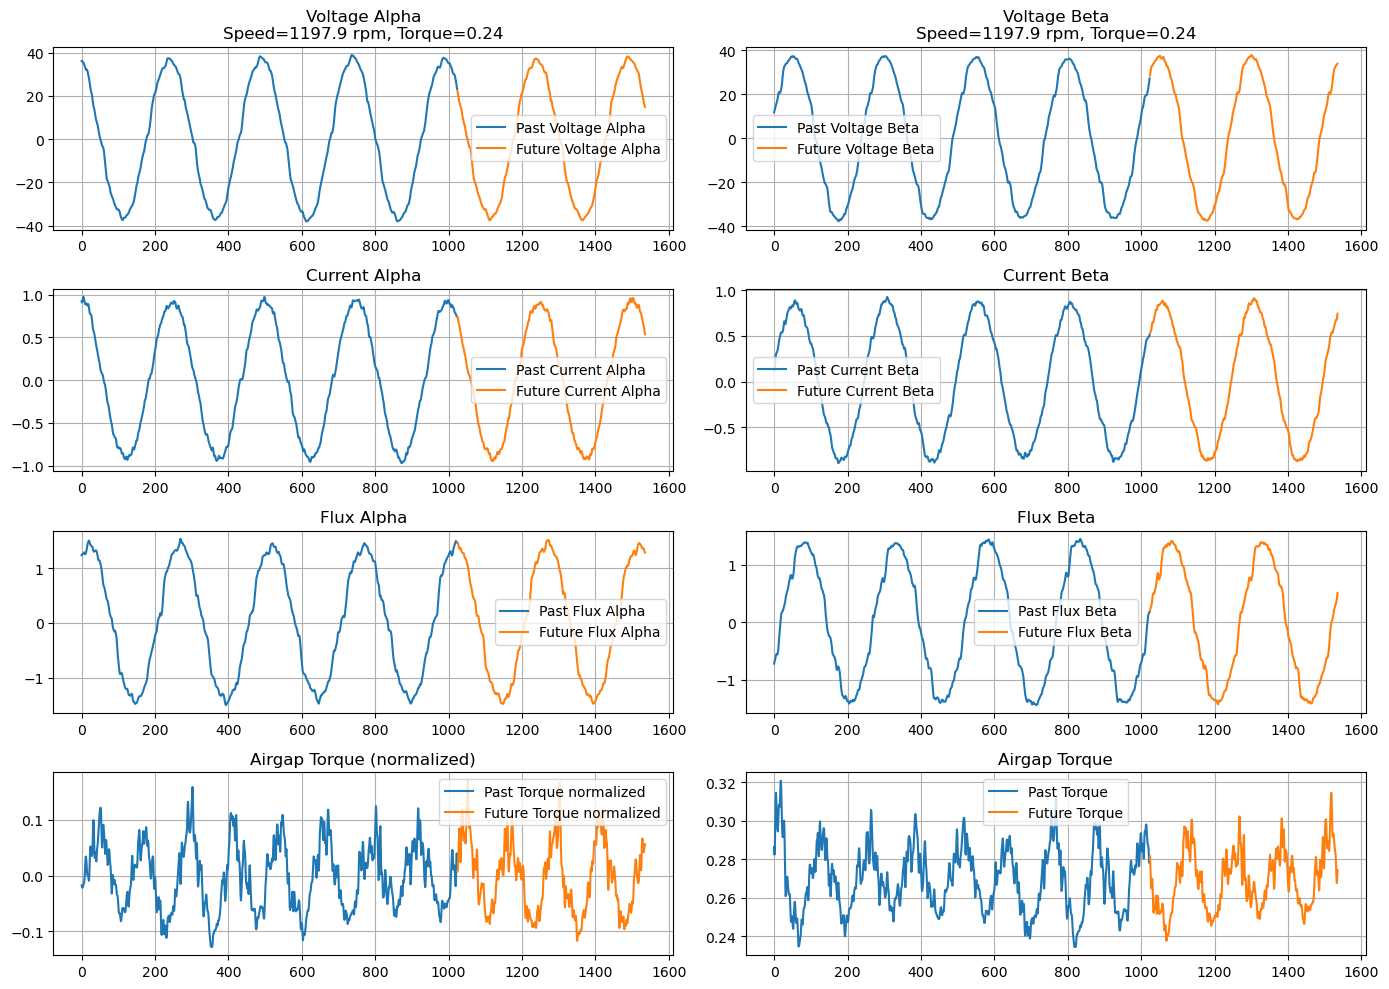

In [14]:
idx = 1  # 可調整索引以觀察不同樣本

def plot_raw_data(idx):
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))
    time_past = np.arange(sequence_length)
    time_future = np.arange(sequence_length, sequence_length + future_length)

    # 取得運轉條件
    speed_val = speed_array_pu[idx, 0] * 3000  # 還原為 rpm
    torque_val = torque_array[idx, 0]

    # 電壓
    axs[0, 0].plot(time_past, past_voltages[idx, :, 0], label='Past Voltage Alpha')
    axs[0, 0].plot(time_future, future_voltages[idx, :, 0], label='Future Voltage Alpha')
    axs[0, 0].set_title(f'Voltage Alpha\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    axs[0, 1].plot(time_past, past_voltages[idx, :, 1], label='Past Voltage Beta')
    axs[0, 1].plot(time_future, future_voltages[idx, :, 1], label='Future Voltage Beta')
    axs[0, 1].set_title(f'Voltage Beta\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 電流
    axs[1, 0].plot(time_past, past_currents[idx, :, 0], label='Past Current Alpha')
    axs[1, 0].plot(time_future, future_currents[idx, :, 0], label='Future Current Alpha')
    axs[1, 0].set_title('Current Alpha')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    axs[1, 1].plot(time_past, past_currents[idx, :, 1], label='Past Current Beta')
    axs[1, 1].plot(time_future, future_currents[idx, :, 1], label='Future Current Beta')
    axs[1, 1].set_title('Current Beta')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # 磁通
    axs[2, 0].plot(time_past, past_emf_normalized[idx, :, 0], label='Past Flux Alpha')
    axs[2, 0].plot(time_future, future_emf_normalized[idx, :, 0], label='Future Flux Alpha')
    axs[2, 0].set_title('Flux Alpha')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    axs[2, 1].plot(time_past, past_emf_normalized[idx, :, 1], label='Past Flux Beta')
    axs[2, 1].plot(time_future, future_emf_normalized[idx, :, 1], label='Future Flux Beta')
    axs[2, 1].set_title('Flux Beta')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    # 力矩
    print(past_airgap_torque_normalized.shape)
    axs[3, 0].plot(time_past, past_airgap_torque_normalized[idx, :,0], label='Past Torque normalized')
    axs[3, 0].plot(time_future, future_airgap_torque_normalized[idx, :,0], label='Future Torque normalized')
    axs[3, 0].set_title('Airgap Torque (normalized)')
    axs[3, 0].legend()
    axs[3, 0].grid(True)

    axs[3, 1].plot(time_past, past_airgap_torque[idx, : ,0], label='Past Torque')
    axs[3, 1].plot(time_future, future_airgap_torque[idx, :,0], label='Future Torque')
    axs[3, 1].set_title('Airgap Torque')
    axs[3, 1].legend()
    axs[3, 1].grid(True)

    plt.tight_layout()
    plt.show()
plot_raw_data(idx)

### 訊練模型 ###

訊練模型 Vin Iout

模型訓練配置:
- 使用權重訓練: False
- 使用GPU: True
- 批次大小: 128
- 訓練週期: 50
- 驗證比例: 0.1

開始訓練模型: 0829_multiscale_CCAE_Base1024_VI
測試模型結構...
測試預測輸出形狀: (1, 1024, 2)
模型結構驗證通過，開始訓練...

⚖️ 使用均勻權重訓練
使用設備: /GPU:0

🚀 開始訓練 - 批次大小: 128, 週期: 50
Epoch 1/50
398/398 [==============================] - 19s 42ms/step - loss: 0.0410 - val_loss: 0.0052 - lr: 0.0010
Epoch 2/50
398/398 [==============================] - 16s 39ms/step - loss: 0.0049 - val_loss: 0.0047 - lr: 0.0010
Epoch 3/50
398/398 [==============================] - 13s 33ms/step - loss: 0.0044 - val_loss: 0.0040 - lr: 0.0010
Epoch 4/50
398/398 [==============================] - 13s 32ms/step - loss: 0.0041 - val_loss: 0.0037 - lr: 0.0010
Epoch 5/50
398/398 [==============================] - 13s 33ms/step - loss: 0.0037 - val_loss: 0.0034 - lr: 0.0010
Epoch 6/50
398/398 [==============================] - 15s 37ms/step - loss: 0.0034 - val_loss: 0.0034 - lr: 0.0010
Epoch 7/50
398/398 [==============================] - 13s 34ms/step - loss: 0.0031 - val_lo

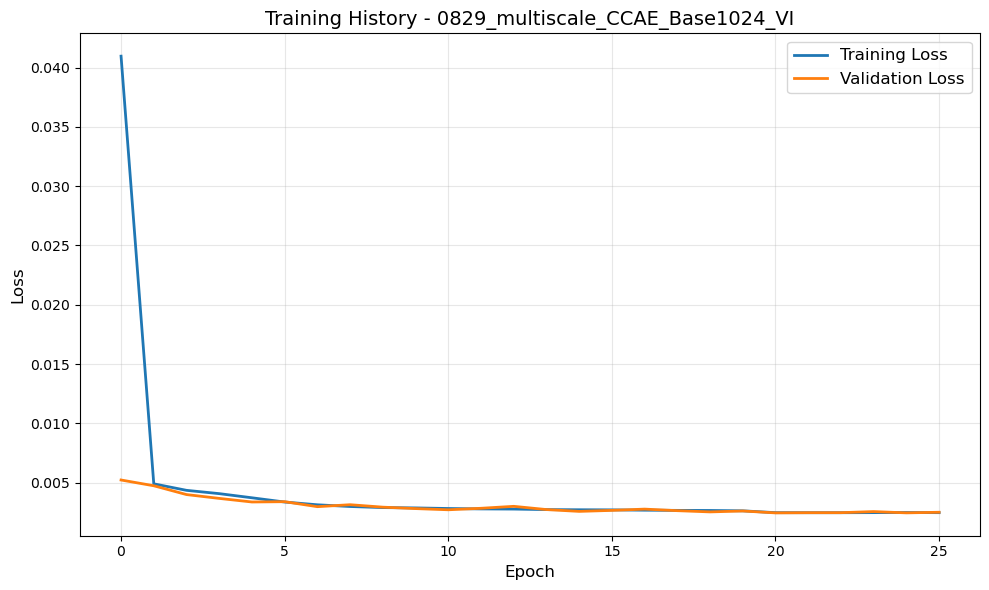

✅ 模型已儲存: NTU_rul_models\CCAE_models\0829_multiscale_CCAE_Base1024\0829_multiscale_CCAE_Base1024_VI.keras
✅ 訓練元數據已儲存: NTU_rul_models\CCAE_models\0829_multiscale_CCAE_Base1024\0829_multiscale_CCAE_Base1024_VI_metadata.json

🎉 VI 模型訓練完成!
最終訓練損失: 0.002469
最終驗證損失: 0.002503
最佳驗證損失: 0.002450


In [21]:
# =============================================================================
# 訓練參數和設定
# =============================================================================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 訓練控制參數
USE_WEIGHTED_TRAINING = False  # 🔧 是否使用權重訓練
USE_GPU = True                 # 🔧 是否使用GPU訓練
BATCH_SIZE = 128              # 🔧 批次大小
EPOCHS = 50                   # 🔧 訓練週期
VALIDATION_SPLIT = 0.1        # 🔧 驗證資料比例
INITIAL_LEARNING_RATE = 1e-3  # 🔧 初始學習率

# =============================================================================
# 損失函數定義
# =============================================================================
def combined_time_freq_loss(y_true, y_pred):
    """
    結合時域和頻域的損失函數
    - 時域: MSE
    - 頻域: FFT幅值的MSE
    """
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

# =============================================================================
# 模型編譯和回調函數設定
# =============================================================================
def compile_and_prepare_model(model, initial_learning_rate=INITIAL_LEARNING_RATE):
    """
    編譯模型並準備訓練回調函數
    """
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',  # 可改為 combined_time_freq_loss
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-5,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

# =============================================================================
# 樣本權重計算函數
# =============================================================================
def calculate_sample_weights(torque_array, speed_array_pu, weight_strategy='inverse_torque'):
    """
    計算樣本權重
    
    Parameters:
    - torque_array: 力矩陣列
    - speed_array_pu: 標準化速度陣列
    - weight_strategy: 權重策略
        - 'inverse_torque': 力矩反比權重
        - 'speed_torque_combined': 速度和力矩結合權重
        - 'uniform': 均勻權重
    """
    t_weight = np.abs(np.squeeze(torque_array / 0.25)).astype(np.float32)
    spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)
    eps = 1e-3
    
    if weight_strategy == 'inverse_torque':
        # 反比權重（小力矩→大權重）
        w = 1.0 / (t_weight + eps)
        strategy_desc = 'w = 1.0 / (t_weight + eps)'
    elif weight_strategy == 'speed_torque_combined':
        # 速度和力矩結合權重
        w = 1.0 + spd_weight / (t_weight + eps)
        strategy_desc = 'w = 1.0 + spd_weight / (t_weight + eps)'
    elif weight_strategy == 'uniform':
        # 均勻權重
        w = np.ones_like(t_weight)
        strategy_desc = 'w = uniform weights'
    else:
        raise ValueError(f"Unknown weight strategy: {weight_strategy}")
    
    # 將平均權重正規化到1，避免總體學習率「變相改變」
    w = w / np.mean(w)
    
    print(f"權重策略: {strategy_desc}")
    print(f"torque (前10個): {t_weight[:10]}")
    print(f"speed (前10個): {spd_weight[:10]}")
    print(f"weight (前10個): {w[:10]}")
    print(f"權重統計 - shape: {w.shape}, min: {w.min():.4f}, max: {w.max():.4f}, mean: {w.mean():.4f}")
    
    return w

# =============================================================================
# 模型訓練函數
# =============================================================================
def train_model(model, model_suffix, x_data, y_data, use_weighted=USE_WEIGHTED_TRAINING):
    """
    訓練模型的通用函數
    
    Parameters:
    - model: 要訓練的模型
    - model_suffix: 模型後綴名稱
    - x_data: 輸入資料
    - y_data: 目標資料
    - use_weighted: 是否使用權重訓練
    """
    print(f"\n{'='*50}")
    print(f"開始訓練模型: {model_name}{model_suffix}")
    print(f"{'='*50}")
    
    # 編譯模型
    lr_scheduler, early_stop = compile_and_prepare_model(model)
    
    # 測試模型結構
    print("測試模型結構...")
    test_prediction = model.predict([x_data[0][0:1], x_data[1][0:1], x_data[2][0:1]], verbose=0)
    print(f"測試預測輸出形狀: {test_prediction.shape}")
    
    # 儲存初始模型（確保模型結構正確）
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print("模型結構驗證通過，開始訓練...")
    
    # 計算權重（如果需要）
    sample_weight = None
    if use_weighted:
        print("\n🎯 使用權重訓練")
        sample_weight = calculate_sample_weights(
            torque_array, 
            speed_array_pu, 
            weight_strategy='speed_torque_combined'
        )
    else:
        print("\n⚖️ 使用均勻權重訓練")
    
    # 訓練設定
    training_config = {
        'x': x_data,
        'y': y_data,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'validation_split': VALIDATION_SPLIT,
        'callbacks': [lr_scheduler, early_stop],
        'verbose': 1
    }
    
    if sample_weight is not None:
        training_config['sample_weight'] = sample_weight
    
    # 選擇訓練設備
    device = '/GPU:0' if USE_GPU and len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
    print(f"使用設備: {device}")
    
    # 開始訓練
    with tf.device(device):
        print(f"\n🚀 開始訓練 - 批次大小: {BATCH_SIZE}, 週期: {EPOCHS}")
        history = model.fit(**training_config)
    
    return history

# =============================================================================
# 訓練結果視覺化和儲存
# =============================================================================
def save_training_results(model, history, model_suffix):
    """
    儲存訓練結果和模型
    """
    # 繪製訓練歷史
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'Training History - {model_name}{model_suffix}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 儲存模型
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print(f"✅ 模型已儲存: {model_save_path}")
    
    # 儲存訓練元數據
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "trained": True,
        "use_weighted_training": USE_WEIGHTED_TRAINING,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history.get('val_loss', [None])[-1]) if history.history.get('val_loss') else None,
        "best_val_loss": float(min(history.history.get('val_loss', [float('inf')]))) if history.history.get('val_loss') else None,
        "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }
    
    metadata_path = os.path.join(model_path, model_name + model_suffix + '_metadata.json')
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    print(f"✅ 訓練元數據已儲存: {metadata_path}")
    
    return metadata

# =============================================================================
# 執行 VI 模型訓練
# =============================================================================
print("模型訓練配置:")
print(f"- 使用權重訓練: {USE_WEIGHTED_TRAINING}")
print(f"- 使用GPU: {USE_GPU}")
print(f"- 批次大小: {BATCH_SIZE}")
print(f"- 訓練週期: {EPOCHS}")
print(f"- 驗證比例: {VALIDATION_SPLIT}")

# 執行訓練
history_VI = train_model(
    model=my_model_V_in_I_out,
    model_suffix='_VI',
    x_data=[past_voltages_normalized, speed_array_pu, torque_array],
    y_data=past_currents_normalized,
    use_weighted=USE_WEIGHTED_TRAINING
)

# 儲存結果
metadata_VI = save_training_results(my_model_V_in_I_out, history_VI, '_VI')

print(f"\n🎉 VI 模型訓練完成!")
print(f"最終訓練損失: {metadata_VI['final_train_loss']:.6f}")
if metadata_VI['final_val_loss']:
    print(f"最終驗證損失: {metadata_VI['final_val_loss']:.6f}")
    print(f"最佳驗證損失: {metadata_VI['best_val_loss']:.6f}")

建立驗證資料集

In [16]:
# =============================================================================
# 數據集建立和管理
# =============================================================================

def list_subfolders(path):
    """列出指定路徑下的所有子資料夾"""
    if not os.path.exists(path):
        print(f"⚠️ 路徑不存在: {path}")
        return []
    return [f.path for f in os.scandir(path) if f.is_dir()]


def get_apply_files_data(folder_path, return_val=False, test_size=0, augmen_sample_number=20):
    """
    取得指定工況資料夾下的所有檔案資料
    
    Parameters:
    - folder_path: 資料夾路徑
    - return_val: 是否返回驗證資料
    - test_size: 驗證資料比例
    - augmen_sample_number: 資料增強樣本數量
    """
    if not os.path.exists(folder_path):
        print(f"⚠️ 資料夾不存在: {folder_path}")
        return {}, {}
    
    parquet_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".parquet")]
    
    if len(parquet_files) == 0:
        print(f"⚠️ 資料夾內無 parquet 檔案: {folder_path}")
        return {}, {}
    
    # 分割訓練和驗證檔案
    if len(parquet_files) > 1 and test_size > 0:
        apply_parquet_files, apply_val_files = train_test_split(parquet_files, test_size=test_size, random_state=42)
    else:
        apply_parquet_files = parquet_files
        apply_val_files = []
    
    def process_files(file_list, sample_number):
        """處理檔案列表"""
        train_signals = []
        train_signals_normalized = []
        torque_array = []
        speed_array_pu = []
        
        for file_path in file_list:
            if not os.path.exists(file_path):
                print(f"File {file_path} does not exist.")
                continue
                
            # 讀取資料
            df = read_rul_data(file_path, force_recompute=False)
            if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
                print(f"File {file_path} has high THD, skipping.")
                continue
                
            current_alpha = np.array(df["Current alpha downsample"])
            current_beta = np.array(df["Current beta downsample"])
            flux_alpha = np.array(df["Flux alpha"])
            flux_beta = np.array(df["Flux beta"])
            
            if flux_alpha.shape[0] != current_alpha.shape[0]:
                print(f"File {file_path} has mismatched flux and current lengths, skipping.")
                continue
                
            torque_airgap = 1.5 * 4 * (flux_alpha * current_beta - flux_beta * current_alpha)
            emf_alpha = (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)
            emf_beta = (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
            
            # 標準化
            torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
            torque = df["Torque avg"]
            speed = df["Speed"][0]
            
            # 合併信號資料
            temp_train_signals = [
                np.array(df["Voltage alpha downsample"]), 
                np.array(df["Voltage beta downsample"]),
                current_alpha,
                current_beta,
                flux_alpha,
                flux_beta,
                emf_alpha,
                emf_beta,
                torque_airgap
            ]
            
            # 標準化處理
            temp_train_signals_normalized = []
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
            
            temp_train_signals_normalized[-1] = torque_airgap_normalized
            
            try:
                temp_train_signals = np.stack(temp_train_signals, axis=1)
                temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            except ValueError as e:
                print(f"Error stacking signals for file {file_path}: {e}")
                continue
                
            # 資料增強
            temp_train_input_signals_augmented = data_interval_augmentation(
                temp_train_signals, sequence_length, 
                augmen_sample_number=sample_number, future_length=future_length
            )
            temp_train_signals_normalized_augmented = data_interval_augmentation(
                temp_train_signals_normalized, sequence_length, 
                augmen_sample_number=sample_number, future_length=future_length
            )
            
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(sample_number) * torque)
            speed_array_pu.append(np.ones(sample_number) * speed / 3000)
        
        if len(train_signals) == 0:
            return {
                "input_signals": np.array([]),
                "input_signals_normalized": np.array([]),
                "fit_signals": np.array([]),
                "fit_signals_normalized": np.array([]),
                "torque_array": np.array([]),
                "speed_array_pu": np.array([])
            }
        
        train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
        train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
        torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
        speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
        
        return {
            "input_signals": train_signals[:, :sequence_length, :],
            "input_signals_normalized": train_signals_normalized[:, :sequence_length, :],
            "fit_signals": train_signals[:, -future_length:, :],
            "fit_signals_normalized": train_signals_normalized[:, -future_length:, :],
            "torque_array": torque_array.reshape(-1, 1),
            "speed_array_pu": speed_array_pu.reshape(-1, 1)
        }
    
    # 處理主要檔案
    apply_data = process_files(apply_parquet_files, augmen_sample_number)
    
    # 處理驗證檔案
    apply_data_val = {}
    if return_val and len(apply_val_files) > 0:
        apply_data_val = process_files(apply_val_files, 50)  # 驗證用較少樣本
    
    return apply_data, apply_data_val

# =============================================================================
# 工況定義
# =============================================================================
# 運轉條件定義
CONDITIONS = ["1200 0.5v", "1200 1.0v", "1200 2.0v",
              "1800 0.5v", "1800 1.0v", "1800 2.0v",
              "3000 0.5v", "3000 1.0v", "3000 2.0v"]

# 所有工況資料夾定義
CONDITION_FOLDERS = {
    # 正常工況
    'Normal1': 'Normal1',
    'Normal1-2': 'Normal1-2', 
    'Normal2': 'Normal2',
    'Normal2-2': 'Normal2-2',
    
    # 鑽孔故障
    'drill_2mm_q1mm': 'drill 2mm q=1mm',
    'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
    'drill_2mm_q2mm': 'drill 2mm q=2mm',
    
    # 磨損故障  
    'wear_out_1': 'wear out 1',
    'wear_out_1_2': 'wear out 1-2',
    'wear_out_2_worse': 'wear out 2(worse)',
    'wear_out_2_worse_2': 'wear out 2(worse)-2',
    
    # 驗證資料
    'validation': 'validation'
}

# =============================================================================
# 建立所有工況的數據集
# =============================================================================
print("🚀 開始建立所有工況的數據集...")
print(f"基礎路徑: {NTU_dataset_path}")
print("="*60)

# 儲存所有數據集的字典
all_datasets = {}
all_validation_datasets = {}

for condition_key, folder_name in CONDITION_FOLDERS.items():
    print(f"\n📁 處理工況: {condition_key} -> {folder_name}")
    
    condition_path = os.path.join(NTU_dataset_path, folder_name)
    
    if not os.path.exists(condition_path):
        print(f"⚠️ 跳過 - 資料夾不存在: {condition_path}")
        continue
    
    # 取得子資料夾
    subfolders = list_subfolders(condition_path)
    
    if len(subfolders) == 0:
        print(f"⚠️ 跳過 - 無子資料夾: {condition_path}")
        continue
    
    print(f"   發現 {len(subfolders)} 個子資料夾")
    
    # 建立此工況的數據集字典
    condition_datasets = {}
    condition_validation_datasets = {}
    
    for folder in subfolders:
        folder_name_short = os.path.basename(folder)
        # print(f"   處理子資料夾: {folder_name_short}")
        
        try:
            # 根據是否為正常工況決定是否分割驗證資料
            if 'Normal1' in condition_key:
                dataset, val_dataset = get_apply_files_data(folder, return_val=True, test_size=0.2, augmen_sample_number=100)
                condition_validation_datasets[folder] = val_dataset
            else:
                dataset, _ = get_apply_files_data(folder, return_val=False, augmen_sample_number=20)
            
            condition_datasets[folder] = dataset
            
            # 顯示數據集統計
            if not len(dataset.get('input_signals', [])) > 0:
                print(f"      ⚠️ 無有效資料")
                
        except Exception as e:
            print(f"      ❌ 錯誤: {str(e)}")
    
    # 儲存到總字典
    all_datasets[condition_key] = condition_datasets
    if condition_validation_datasets:
        all_validation_datasets[condition_key] = condition_validation_datasets
    
    print(f"   🏁 {condition_key} 完成 - 共 {len(condition_datasets)} 個有效子資料夾")

# =============================================================================
# 數據集摘要
# =============================================================================
print("\n" + "="*60)
print("📊 數據集建立摘要")
print("="*60)

total_datasets = 0
total_samples = 0

for condition_key, condition_datasets in all_datasets.items():
    condition_samples = 0
    valid_folders = 0
    
    for folder_path, dataset in condition_datasets.items():
        if len(dataset.get('input_signals', [])) > 0:
            folder_samples = dataset['input_signals'].shape[0]
            condition_samples += folder_samples
            valid_folders += 1
    
    if valid_folders > 0:
        print(f"{condition_key:20} | {valid_folders:2d} 個資料夾 | {condition_samples:5d} 樣本")
        total_datasets += valid_folders
        total_samples += condition_samples
    else:
        print(f"{condition_key:20} | ❌ 無有效資料")

print("-" * 60)
print(f"{'總計':20} | {total_datasets:2d} 個資料夾 | {total_samples:5d} 樣本")

# =============================================================================
# 向後相容性 - 保持原有變數名稱
# =============================================================================
print("\n🔄 設定向後相容性變數...")

# 原有的變數名稱對應
if 'Normal1' in all_datasets:
    normal_datasets = all_datasets['Normal1']
    validation_datasets = all_validation_datasets.get('Normal1', {})

if 'Normal1-2' in all_datasets:
    normal2_datasets = all_datasets['Normal1-2']

if 'wear_out_1' in all_datasets:
    abnormal_datasets = all_datasets['wear_out_1']

if 'wear_out_2_worse' in all_datasets:
    abnormal2_datasets = all_datasets['wear_out_2_worse']

if 'drill_2mm_q1mm' in all_datasets:
    abnormal3_datasets = all_datasets['drill_2mm_q1mm']

print("✅ 所有數據集建立完成！")
print(f"✅ 可用工況: {list(all_datasets.keys())}")

🚀 開始建立所有工況的數據集...
基礎路徑: D:\OneDrive\CCAE_experiments\CCAE_datasets3_1

📁 處理工況: Normal1 -> Normal1
   發現 9 個子資料夾


   🏁 Normal1 完成 - 共 9 個有效子資料夾

📁 處理工況: Normal1-2 -> Normal1-2
   發現 11 個子資料夾
⚠️ 資料夾內無 parquet 檔案: D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal1-2\新增資料夾
      ⚠️ 無有效資料
⚠️ 資料夾內無 parquet 檔案: D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal1-2\新增資料夾 (2)
      ⚠️ 無有效資料
   🏁 Normal1-2 完成 - 共 11 個有效子資料夾

📁 處理工況: Normal2 -> Normal2
   發現 9 個子資料夾
⚠️ 資料夾內無 parquet 檔案: D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2\Normal2 1200 2.0v 2kg cm
      ⚠️ 無有效資料
   🏁 Normal2 完成 - 共 9 個有效子資料夾

📁 處理工況: Normal2-2 -> Normal2-2
   發現 10 個子資料夾
⚠️ 資料夾內無 parquet 檔案: D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 origin
      ⚠️ 無有效資料
   🏁 Normal2-2 完成 - 共 10 個有效子資料夾

📁 處理工況: drill_2mm_q1mm -> drill 2mm q=1mm
   發現 9 個子資料夾
   🏁 drill_2mm_q1mm 完成 - 共 9 個有效子資料夾

📁 處理工況: drill_2mm_q1mm_2 -> drill 2mm q=1mm-2
   發現 9 個子資料夾
   🏁 drill_2mm_q1mm_2 完成 - 共 9 個有效子資料夾

📁 處理工況: drill_2mm_q2mm -> drill 2mm q=2mm
   發現 9 個子資料夾
   🏁 drill_2mm_q2mm 完成 - 共 9 個有效子資料夾

📁 處理工況: wear_out_1 -> wea

In [17]:
CONDITION_FOLDERS

{'Normal1': 'Normal1',
 'Normal1-2': 'Normal1-2',
 'Normal2': 'Normal2',
 'Normal2-2': 'Normal2-2',
 'drill_2mm_q1mm': 'drill 2mm q=1mm',
 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
 'drill_2mm_q2mm': 'drill 2mm q=2mm',
 'wear_out_1': 'wear out 1',
 'wear_out_1_2': 'wear out 1-2',
 'wear_out_2_worse': 'wear out 2(worse)',
 'wear_out_2_worse_2': 'wear out 2(worse)-2',
 'validation': 'validation'}

計算各工況的重建MSE...
可用工況: ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm', 'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
  跳過空的子資料夾: 新增資料夾
  跳過空的子資料夾: 新增資料夾 (2)
  跳過空的子資料夾: Normal2 1200 2.0v 2kg cm
  跳過空的子資料夾: Normal2-2 origin

開始按運轉條件繪圖...
使用 'Normal1' 作為基準正常工況


C:\Users\MotorTech\AppData\Local\Temp\ipykernel_44704\1218488867.py:442: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_test, y_test,


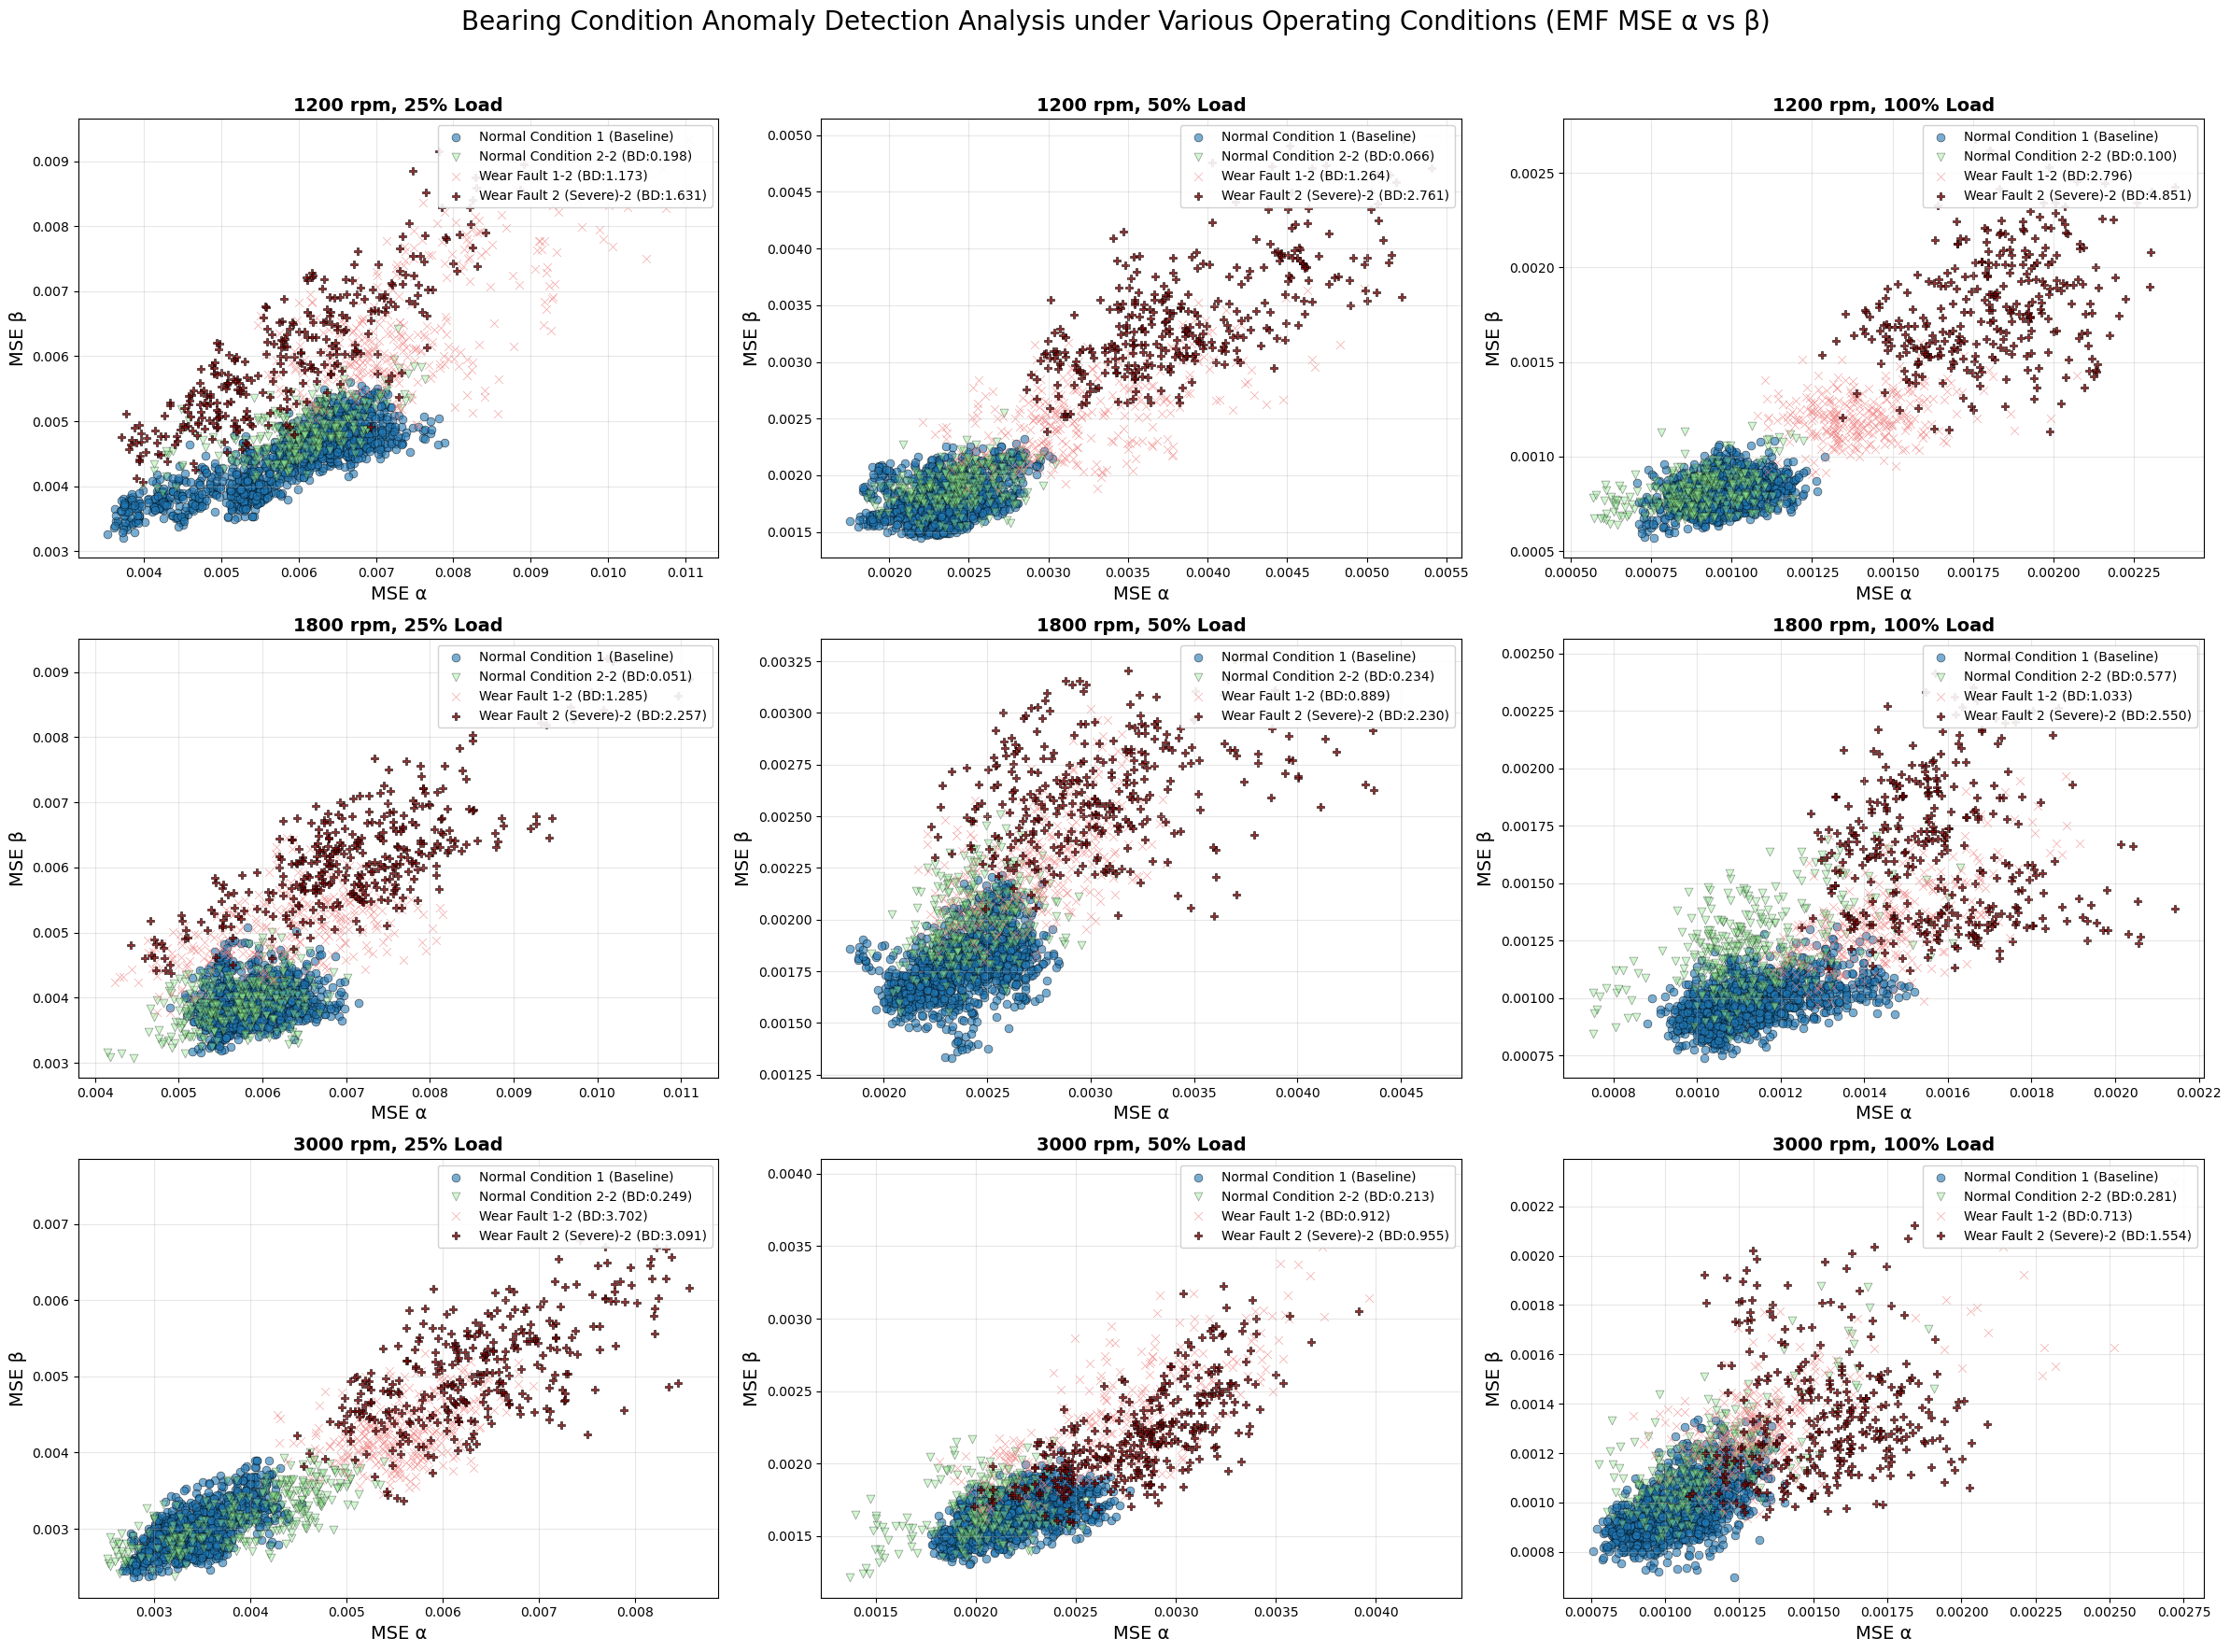


Anomaly Detection Results Summary for Each Operating Condition
(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)

🔧 1200 rpm, 25% Load
------------------------------------------------------------
   ❌ Normal Condition 1-2 | BD Distance: 0.4621 | Anomaly Rate: 0.213 (16/75)
   ❌ Normal Condition 2   | BD Distance: 0.2022 | Anomaly Rate: 0.056 (1/18)
   ✅ Normal Condition 2-2 | BD Distance: 0.1976 | Anomaly Rate: 0.067 (1/15)
   ❌ Drill Fault 2mm      | BD Distance: 1.5852 | Anomaly Rate: 1.000 (19/19)
   ❌ Drill Fault 2mm-2    | BD Distance: 2.4329 | Anomaly Rate: 1.000 (15/15)
   ❌ Drill Fault 2mm-2    | BD Distance: 6.9845 | Anomaly Rate: 1.000 (18/18)
   ❌ Wear Fault 1         | BD Distance: 0.2441 | Anomaly Rate: 0.000 (0/19)
   ✅ Wear Fault 1-2       | BD Distance: 1.1730 | Anomaly Rate: 1.000 (16/16)
   ❌ Wear Fault 2 (Severe) | BD Distance: 1.8270 | Anomaly Rate: 1.000 (15/15)
   ✅ Wear Fault 2 (Severe)-2 | BD Distance: 1.6315 | Anomaly Rate: 1.000 (15/15

In [22]:
# ===== Member Out / BD Analysis and Visualization =====
from scipy.stats import chi2

my_model_V_in_I_out=load_model(os.path.join(model_path, model_name + '_VI.keras'))
# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2

def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """
    判斷樣本是否來自指定高斯分布（使用卡方檢定）
    - 新增規則：白化後在第三象限(Q3)的樣本，其馬氏距離平方設為 0
    - 其它步驟沿用原版：以 m_dist2 的平均作為檢定統計量，對照 χ²(df=2) 右尾
    """
    samples = np.asarray(samples, dtype=float)
    mean = np.asarray(mean, dtype=float)
    cov = np.asarray(cov, dtype=float)

    # --- 前處理 ---
    # 差向量
    diff = samples - mean

    # 1) 白化座標 z = L^{-1} (x - mu) 用於判定是否在 Q3
    #    這裡用 Cholesky：cov = L L^T
    L = np.linalg.cholesky(cov)
    # 解 L z = diff^T -> z = L^{-1} diff^T，再轉回 (n,2)
    z = np.linalg.solve(L, diff.T).T   # shape (n, 2)

    # 2) 標準馬氏距離平方 D^2 = (x-mu)^T cov^{-1} (x-mu)
    inv_cov = np.linalg.inv(cov)
    # (diff @ inv_cov) 與 diff 做逐點內積
    m_dist2 = np.sum((diff @ inv_cov) * diff, axis=1)

    # 3) Q3 限制：若白化後 z 在第三象限（兩軸皆 < 0），該點距離設為 0
    in_Q3 = (z[:, 0] < 0) & (z[:, 1] < 0)
    m_dist2[in_Q3] = 0.0

    # --- 與原版一致的檢定做法 ---
    test_stat = np.mean(m_dist2)           # 你原本的統計量定義
    p_value = 1.0 - chi2.cdf(test_stat, df=2)  # 右尾 p 值
    is_from_gaussian = p_value > alpha

    return is_from_gaussian, p_value, m_dist2

def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.05):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }

# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'drill_2mm_q2mm': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': True,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'drill_2mm_q2mm': False,       # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'drill_2mm_q2mm': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'drill_2mm_q2mm': 'darkorange',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'drill_2mm_q2mm': 'D',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}

# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 0:2]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                
                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                )
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors = get_mse_by_operating_conditions(
    all_datasets, available_conditions, my_model_V_in_I_out
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_VI = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors or 
            operating_condition not in condition_operating_errors[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_VI[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors or 
                operating_condition not in condition_operating_errors[bearing_condition]):
                continue
            
            test_data = condition_operating_errors[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.01
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_VI[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_VI.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
import os
from matplotlib.ticker import MultipleLocator
# --- helpers ---
def _gaussian_2d_mle(x, y):
    data = np.column_stack([x, y]).astype(float)
    mean = data.mean(axis=0)
    cov = np.cov(data, rowvar=False)
    return mean, cov

def _whiten_xy_xy(x1, y1, x2, y2, mean, cov):
    """用同一組 mean/cov 白化兩份資料（便於對齊比較）"""
    L = np.linalg.cholesky(cov)
    def _one(x, y):
        data = np.column_stack([x, y]).astype(float)
        z = np.linalg.solve(L, (data - mean).T).T
        return z
    return _one(x1, y1), _one(x2, y2)

def plot_before_after_with_overlay(condition_operating_errors,
                                   condition_main: str,
                                   condition_overlay: str,
                                   operating_condition: str,
                                   overlay_top_n: int = 200,
                                   title_note: str = "",
                                   alpha_main=0.5,
                                   alpha_overlay=0.9,
                                   s_main=18,
                                   s_overlay=36):
    """
    兩張圖：白化前 / 白化後。將 overlay 工況的前 n 個點疊加顯示。
    白化使用「主工況」的 MLE mean/cov。
    """
    # --- 1) 取資料 ---
    def _fetch(cond, op):
        if cond not in condition_operating_errors:
            raise KeyError(f"工況 '{cond}' 不在 condition_operating_errors 中。")
        if op not in condition_operating_errors[cond]:
            raise KeyError(f"工況 '{cond}' 在運轉條件 '{op}' 無資料。")
        pack = condition_operating_errors[cond][op]
        x = np.asarray(pack["EMF_alpha_MSE"], dtype=float)
        y = np.asarray(pack["EMF_beta_MSE"], dtype=float)
        if x.size == 0 or y.size == 0:
            raise ValueError(f"工況 '{cond}' @ '{op}' 資料為空。")
        return x, y

    x_main, y_main = _fetch(condition_main, operating_condition)
    x_ovl,  y_ovl  = _fetch(condition_overlay, operating_condition)

    n = min(overlay_top_n, len(x_ovl))
    x_ovl_n, y_ovl_n = x_ovl[:n], y_ovl[:n]

    # --- 2) 主工況 MLE（用於白化兩組資料）---
    mean_main, cov_main = _gaussian_2d_mle(x_main, y_main)

    # --- 3) 白化 ---
    Z_main, Z_ovl = _whiten_xy_xy(x_main, y_main, x_ovl_n, y_ovl_n, mean_main, cov_main)

    # --- 4) 圖1：白化前 ---
    fig1, ax1 = plt.subplots(figsize=(7.2, 6.2))
    ax1.scatter(x_main, y_main, s=s_main, alpha=alpha_main, label=f"{condition_main} (all)")
    ax1.scatter(x_ovl_n, y_ovl_n, s=s_overlay, alpha=alpha_overlay, marker='x',
                label=f"{condition_overlay} (top {n})")
    # ax1.set_title(f"Pre-Whitening — {operating_condition}\n{condition_main} vs {condition_overlay} {title_note}".strip(),
    #               fontweight='bold')
    ax1.set_xlabel("MSE α ", fontsize=18)
    ax1.set_ylabel("MSE β ", fontsize=18)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax1.set_xticks(np.arange(0, 0.0015, 0.00025))  
    ax1.set_yticks(np.arange(0, 0.0015, 0.00025))
    ax1.set_xlim(-0.0001, 0.0016)
    ax1.set_ylim(0, 0.0016)

    ax1.grid(alpha=0.3)
    # ax1.legend(loc='best')
    # plt.tight_layout()
    plt.savefig(os.path.join('TIE_plots', f'raw{condition_main}_vs_{condition_overlay}_{operating_condition.replace(" ", "_")}.png'), dpi=300)
    
    # --- 5) 圖2：白化後（用主工況參數白化）---
    fig2, ax2 = plt.subplots(figsize=(7.2, 6.2))
    ax2.scatter(Z_main[:, 0], Z_main[:, 1], s=s_main, alpha=alpha_main, label=f"{condition_main} (all)")
    ax2.scatter(Z_ovl[:, 0],  Z_ovl[:, 1],  s=s_overlay, alpha=alpha_overlay, marker='x',
                label=f"{condition_overlay} (top {n})")
    # 畫出主工況與 overlay 的平均點
    mean_main_z = Z_main.mean(axis=0)
    mean_ovl_z = Z_ovl.mean(axis=0)
    # ax2.scatter(*mean_main_z, s=120, c='tab:blue', marker='o', edgecolor='k', label=f"{condition_main} mean")
    ax2.scatter(*mean_ovl_z, s=80, c='tab:red', marker='*', edgecolor='b', alpha=0.5, label=f"{condition_overlay} mean")

    # 95% χ² 半徑參考圓（df=2）
    r95 = np.sqrt(chi2.ppf(0.99, df=2))
    tt = np.linspace(0, 2*np.pi, 400)
    ax2.plot(r95*np.cos(tt), r95*np.sin(tt), lw=1.4, alpha=0.95, label='95% χ² circle')

    ax2.axhline(0, lw=1, alpha=0.5)
    ax2.axvline(0, lw=1, alpha=0.5)
    ax2.set_aspect('equal', adjustable='box')
    # ax2.set_title(f"Post-Whitening — {operating_condition}\nwhitened by {condition_main} MLE {title_note}".strip(),
    #               fontweight='bold')
    ax2.set_xlabel("z₁", fontsize=18)
    ax2.set_ylabel("z₂", fontsize=18)
    ax2.grid(alpha=0.3)
    ax2.set_xticks(np.arange(-3, 6, 1))   # -3, -2, -1, 0, 1, 2, 3
    ax2.set_yticks(np.arange(-3, 6, 1))
    ax2.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    # ax2.xaxis.get_major_locator().set_params(prune=None)
    # ax2.yaxis.get_major_locator().set_params(prune=None)
    # ax2.legend(loc='best')
    # plt.tight_layout()
    plt.savefig(os.path.join('TIE_plots', f'white_{condition_main}_vs_{condition_overlay}_{operating_condition.replace(" ", "_")}.png'), dpi=300)
    # 額外註記：疊加點數、r95
    # fig2.text(0.01, 0.01, f"overlay n = {n} | r95 = {r95:.2f}", ha='left', va='bottom', fontsize=9)

    plt.show()
plt.close()
# ===== 使用範例 =====
plot_before_after_with_overlay(
    condition_operating_errors,
    condition_main='Normal1',
    condition_overlay='wear_out_1_2',
    operating_condition='1200 2.0v',
    overlay_top_n=5 ,
    title_note='EMF MSE (α, β)'
)


### 3. 電流 in 電流 out ###
訓練

In [ ]:
dataset

In [ ]:


# 訓練函數（與 my_model_V_in_I_out 相同的配置）
def train_model_II(model, model_suffix, x_data, y_data, use_weighted=USE_WEIGHTED_TRAINING):
    """
    訓練 I_in_I_out 模型的函數
    """
    print(f"\n開始訓練模型: {model_suffix}")
    print(f"使用加權訓練: {use_weighted}")
    
    # 準備輸入資料
    input_signals = x_data  # 電流輸入 [current_alpha, current_beta]
    output_signals = y_data  # 電流輸出 [current_alpha, current_beta]
    
    # 編譯模型
    model.compile(
        optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
        loss='mse'
    )
    
    # 學習率調度器
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    
    # 早停機制
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    
    # 準備加權
    if use_weighted:
        print("  使用加權訓練（基於扭矩和速度）")
        # 計算樣本權重（與 V_in_I_out 模型相同的邏輯）
        t_weight = np.abs(np.squeeze(torque_array / 0.25)).astype(np.float32)
        spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)
        combined_weight = t_weight * spd_weight
        combined_weight = np.clip(combined_weight, 0.1, 5.0)  # 限制權重範圍
        
        # 開始訓練
        history = model.fit(
            x=[input_signals, speed_array_pu, torque_array],
            y=output_signals,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            sample_weight=combined_weight,
            callbacks=[lr_scheduler, early_stop],
            verbose=1
        )
    else:
        print("  使用標準訓練（無加權）")
        # 開始訓練
        history = model.fit(
            x=[input_signals, speed_array_pu, torque_array],
            y=output_signals,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            callbacks=[lr_scheduler, early_stop],
            verbose=1
        )
    
    return history

# 準備電流訓練資料
print("準備電流訓練資料...")
print(f"電流輸入形狀: {past_currents_normalized.shape}")
print(f"電流輸出形狀: {past_currents_normalized.shape}")

# 執行訓練
history_II = train_model_II(
    model=my_model_I_in_I_out,
    model_suffix='_II',
    x_data=past_currents_normalized,  # 輸入：正規化的電流訊號
    y_data=past_currents_normalized,  # 輸出：重建的電流訊號（自編碼器）
    use_weighted=USE_WEIGHTED_TRAINING
)

# 儲存訓練結果函數
def save_training_results_II(model, history, model_suffix):
    """儲存訓練結果和模型"""
    # 儲存模型
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print(f"✅ 模型已儲存至: {model_save_path}")
    
    # 更新 metadata
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "trained": True,
        "train_loss": float(history.history['loss'][-1]),
        "val_loss": float(history.history.get('val_loss', [None])[-1]) if history.history.get('val_loss') else None,
        "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "epochs_trained": len(history.history['loss']),
        "use_weighted_training": USE_WEIGHTED_TRAINING,
        "model_type": "Current_input_Current_output"
    }
    
    metadata_path = os.path.join(model_path, model_name + model_suffix + '_metadata.json')
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    
    print(f"✅ 訓練記錄已儲存至: {metadata_path}")
    return metadata

# 儲存訓練結果
metadata_II = save_training_results_II(my_model_I_in_I_out, history_II, '_II')

# 繪製訓練曲線
print("\n📊 繪製訓練曲線...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_II.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history_II.history:
    plt.plot(history_II.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Current-to-Current Model Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(history_II.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history_II.history:
    plt.plot(history_II.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Current-to-Current Model Training History (Linear Scale)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 訓練結果摘要
print("\n" + "="*70)
print("🎯 my_model_I_in_I_out 訓練完成摘要")
print("="*70)
print(f"✅ 模型類型: 電流輸入 -> 電流輸出 (自編碼器)")
print(f"📊 訓練樣本數: {past_currents_normalized.shape[0]:,}")
print(f"🔢 序列長度: {sequence_length}")
print(f"⚡ 訓練輪數: {len(history_II.history['loss'])}")
print(f"📉 最終訓練 Loss: {history_II.history['loss'][-1]:.6f}")
if 'val_loss' in history_II.history:
    print(f"📈 最終驗證 Loss: {history_II.history['val_loss'][-1]:.6f}")
print(f"⚖️ 使用加權訓練: {'是' if USE_WEIGHTED_TRAINING else '否'}")
print(f"🔧 模型參數數量: {my_model_I_in_I_out.count_params():,}")
print(f"💾 模型檔案: {model_name}_II.keras")
print("="*70)

print(f"\n✅ my_model_I_in_I_out 建立並訓練完成！")

結果展示

In [ ]:
# ===== Member Out / BD Analysis and Visualization =====
from scipy.stats import chi2
my_model_I_in_I_out =load_model(os.path.join(model_path, model_name + '_II.keras'))
# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2

def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """
    判斷樣本是否來自指定高斯分布（使用卡方檢定）
    - 新增規則：白化後在第三象限(Q3)的樣本，其馬氏距離平方設為 0
    - 其它步驟沿用原版：以 m_dist2 的平均作為檢定統計量，對照 χ²(df=2) 右尾
    """
    samples = np.asarray(samples, dtype=float)
    mean = np.asarray(mean, dtype=float)
    cov = np.asarray(cov, dtype=float)

    # --- 前處理 ---
    # 差向量
    diff = samples - mean

    # 1) 白化座標 z = L^{-1} (x - mu) 用於判定是否在 Q3
    #    這裡用 Cholesky：cov = L L^T
    L = np.linalg.cholesky(cov)
    # 解 L z = diff^T -> z = L^{-1} diff^T，再轉回 (n,2)
    z = np.linalg.solve(L, diff.T).T   # shape (n, 2)

    # 2) 標準馬氏距離平方 D^2 = (x-mu)^T cov^{-1} (x-mu)
    inv_cov = np.linalg.inv(cov)
    # (diff @ inv_cov) 與 diff 做逐點內積
    m_dist2 = np.sum((diff @ inv_cov) * diff, axis=1)

    # 3) Q3 限制：若白化後 z 在第三象限（兩軸皆 < 0），該點距離設為 0
    in_Q3 = (z[:, 0] < 0) & (z[:, 1] < 0)
    m_dist2[in_Q3] = 0.0

    # --- 與原版一致的檢定做法 ---
    test_stat = np.mean(m_dist2)           # 你原本的統計量定義
    p_value = 1.0 - chi2.cdf(test_stat, df=2)  # 右尾 p 值
    is_from_gaussian = p_value > alpha

    return is_from_gaussian, p_value, m_dist2
def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.1):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }

# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'drill_2mm_q2mm': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': True,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'drill_2mm_q2mm': True,       # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'drill_2mm_q2mm': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'drill_2mm_q2mm': 'darkorange',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'drill_2mm_q2mm': 'D',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}

# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                
                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                )
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors_II = get_mse_by_operating_conditions(
    all_datasets, available_conditions, my_model_I_in_I_out
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_II = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors_II or 
            operating_condition not in condition_operating_errors_II[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors_II[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_II[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors_II or 
                operating_condition not in condition_operating_errors_II[bearing_condition]):
                continue
            
            test_data = condition_operating_errors_II[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.05
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_II[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_II.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

V in I out + res

In [ ]:
# =============================================================================
# 訓練參數和設定
# =============================================================================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 訓練控制參數
USE_WEIGHTED_TRAINING = False  # 🔧 是否使用權重訓練
USE_GPU = True                 # 🔧 是否使用GPU訓練
BATCH_SIZE = 128              # 🔧 批次大小
EPOCHS = 50                   # 🔧 訓練週期
VALIDATION_SPLIT = 0.1        # 🔧 驗證資料比例
INITIAL_LEARNING_RATE = 1e-3  # 🔧 初始學習率

# =============================================================================
# 損失函數定義
# =============================================================================
def combined_time_freq_loss(y_true, y_pred):
    """
    結合時域和頻域的損失函數
    - 時域: MSE
    - 頻域: FFT幅值的MSE
    """
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

# =============================================================================
# 模型編譯和回調函數設定
# =============================================================================
def compile_and_prepare_model(model, initial_learning_rate=INITIAL_LEARNING_RATE):
    """
    編譯模型並準備訓練回調函數
    """
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',  # 可改為 combined_time_freq_loss
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-5,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

# =============================================================================
# 樣本權重計算函數
# =============================================================================
def calculate_sample_weights(torque_array, speed_array_pu, weight_strategy='inverse_torque'):
    """
    計算樣本權重
    
    Parameters:
    - torque_array: 力矩陣列
    - speed_array_pu: 標準化速度陣列
    - weight_strategy: 權重策略
        - 'inverse_torque': 力矩反比權重
        - 'speed_torque_combined': 速度和力矩結合權重
        - 'uniform': 均勻權重
    """
    t_weight = np.abs(np.squeeze(torque_array / 0.25)).astype(np.float32)
    spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)
    eps = 1e-3
    
    if weight_strategy == 'inverse_torque':
        # 反比權重（小力矩→大權重）
        w = 1.0 / (t_weight + eps)
        strategy_desc = 'w = 1.0 / (t_weight + eps)'
    elif weight_strategy == 'speed_torque_combined':
        # 速度和力矩結合權重
        w = 1.0 + spd_weight / (t_weight + eps)
        strategy_desc = 'w = 1.0 + spd_weight / (t_weight + eps)'
    elif weight_strategy == 'uniform':
        # 均勻權重
        w = np.ones_like(t_weight)
        strategy_desc = 'w = uniform weights'
    else:
        raise ValueError(f"Unknown weight strategy: {weight_strategy}")
    
    # 將平均權重正規化到1，避免總體學習率「變相改變」
    w = w / np.mean(w)
    
    print(f"權重策略: {strategy_desc}")
    print(f"torque (前10個): {t_weight[:10]}")
    print(f"speed (前10個): {spd_weight[:10]}")
    print(f"weight (前10個): {w[:10]}")
    print(f"權重統計 - shape: {w.shape}, min: {w.min():.4f}, max: {w.max():.4f}, mean: {w.mean():.4f}")
    
    return w

# =============================================================================
# 模型訓練函數
# =============================================================================
def train_model(model, model_suffix, x_data, y_data, use_weighted=USE_WEIGHTED_TRAINING):
    """
    訓練模型的通用函數
    
    Parameters:
    - model: 要訓練的模型
    - model_suffix: 模型後綴名稱
    - x_data: 輸入資料
    - y_data: 目標資料
    - use_weighted: 是否使用權重訓練
    """
    print(f"\n{'='*50}")
    print(f"開始訓練模型: {model_name}{model_suffix}")
    print(f"{'='*50}")
    
    # 編譯模型
    lr_scheduler, early_stop = compile_and_prepare_model(model)
    
    # 測試模型結構
    print("測試模型結構...")
    test_prediction = model.predict([x_data[0][0:1], x_data[1][0:1], x_data[2][0:1]], verbose=0)
    print(f"測試預測輸出形狀: {test_prediction.shape}")
    
    # 儲存初始模型（確保模型結構正確）
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print("模型結構驗證通過，開始訓練...")
    
    # 計算權重（如果需要）
    sample_weight = None
    if use_weighted:
        print("\n🎯 使用權重訓練")
        sample_weight = calculate_sample_weights(
            torque_array, 
            speed_array_pu, 
            weight_strategy='speed_torque_combined'
        )
    else:
        print("\n⚖️ 使用均勻權重訓練")
    
    # 訓練設定
    training_config = {
        'x': x_data,
        'y': y_data,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'validation_split': VALIDATION_SPLIT,
        'callbacks': [lr_scheduler, early_stop],
        'verbose': 1
    }
    
    if sample_weight is not None:
        training_config['sample_weight'] = sample_weight
    
    # 選擇訓練設備
    device = '/GPU:0' if USE_GPU and len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
    print(f"使用設備: {device}")
    
    # 開始訓練
    with tf.device(device):
        print(f"\n🚀 開始訓練 - 批次大小: {BATCH_SIZE}, 週期: {EPOCHS}")
        history = model.fit(**training_config)
    
    return history

# =============================================================================
# 訓練結果視覺化和儲存
# =============================================================================
def save_training_results(model, history, model_suffix):
    """
    儲存訓練結果和模型
    """
    # 繪製訓練歷史
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'Training History - {model_name}{model_suffix}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 儲存模型
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print(f"✅ 模型已儲存: {model_save_path}")
    
    # 儲存訓練元數據
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "trained": True,
        "use_weighted_training": USE_WEIGHTED_TRAINING,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history.get('val_loss', [None])[-1]) if history.history.get('val_loss') else None,
        "best_val_loss": float(min(history.history.get('val_loss', [float('inf')]))) if history.history.get('val_loss') else None,
        "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }
    
    metadata_path = os.path.join(model_path, model_name + model_suffix + '_metadata.json')
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    print(f"✅ 訓練元數據已儲存: {metadata_path}")
    
    return metadata

# =============================================================================
# 執行 VI 模型訓練
# =============================================================================
print("模型訓練配置:")
print(f"- 使用權重訓練: {USE_WEIGHTED_TRAINING}")
print(f"- 使用GPU: {USE_GPU}")
print(f"- 批次大小: {BATCH_SIZE}")
print(f"- 訓練週期: {EPOCHS}")
print(f"- 驗證比例: {VALIDATION_SPLIT}")

# 執行訓練
history_VI_res = train_model(
    model=my_model_V_in_I_out_res,
    model_suffix='_VI_res',
    x_data=[past_voltages_normalized, speed_array_pu, torque_array],
    y_data=past_currents_normalized,
    use_weighted=USE_WEIGHTED_TRAINING
)

# 儲存結果
metadata_VI_res = save_training_results(my_model_V_in_I_out_res, history_VI_res, '_VI_res')

print(f"\n🎉 VI 模型訓練完成!")
print(f"最終訓練損失: {metadata_VI['final_train_loss']:.6f}")
if metadata_VI['final_val_loss']:
    print(f"最終驗證損失: {metadata_VI['final_val_loss']:.6f}")
    print(f"最佳驗證損失: {metadata_VI['best_val_loss']:.6f}")

V in I out res + film

In [ ]:
# =============================================================================
# 訓練參數和設定
# =============================================================================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 訓練控制參數
USE_WEIGHTED_TRAINING = False  # 🔧 是否使用權重訓練
USE_GPU = True                 # 🔧 是否使用GPU訓練
BATCH_SIZE = 128              # 🔧 批次大小
EPOCHS = 50                   # 🔧 訓練週期
VALIDATION_SPLIT = 0.1        # 🔧 驗證資料比例
INITIAL_LEARNING_RATE = 1e-3  # 🔧 初始學習率

# =============================================================================
# 損失函數定義
# =============================================================================
def combined_time_freq_loss(y_true, y_pred):
    """
    結合時域和頻域的損失函數
    - 時域: MSE
    - 頻域: FFT幅值的MSE
    """
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

# =============================================================================
# 模型編譯和回調函數設定
# =============================================================================
def compile_and_prepare_model(model, initial_learning_rate=INITIAL_LEARNING_RATE):
    """
    編譯模型並準備訓練回調函數
    """
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',  # 可改為 combined_time_freq_loss
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-5,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

# =============================================================================
# 樣本權重計算函數
# =============================================================================
def calculate_sample_weights(torque_array, speed_array_pu, weight_strategy='inverse_torque'):
    """
    計算樣本權重
    
    Parameters:
    - torque_array: 力矩陣列
    - speed_array_pu: 標準化速度陣列
    - weight_strategy: 權重策略
        - 'inverse_torque': 力矩反比權重
        - 'speed_torque_combined': 速度和力矩結合權重
        - 'uniform': 均勻權重
    """
    t_weight = np.abs(np.squeeze(torque_array / 0.25)).astype(np.float32)
    spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)
    eps = 1e-3
    
    if weight_strategy == 'inverse_torque':
        # 反比權重（小力矩→大權重）
        w = 1.0 / (t_weight + eps)
        strategy_desc = 'w = 1.0 / (t_weight + eps)'
    elif weight_strategy == 'speed_torque_combined':
        # 速度和力矩結合權重
        w = 1.0 + spd_weight / (t_weight + eps)
        strategy_desc = 'w = 1.0 + spd_weight / (t_weight + eps)'
    elif weight_strategy == 'uniform':
        # 均勻權重
        w = np.ones_like(t_weight)
        strategy_desc = 'w = uniform weights'
    else:
        raise ValueError(f"Unknown weight strategy: {weight_strategy}")
    
    # 將平均權重正規化到1，避免總體學習率「變相改變」
    w = w / np.mean(w)
    
    print(f"權重策略: {strategy_desc}")
    print(f"torque (前10個): {t_weight[:10]}")
    print(f"speed (前10個): {spd_weight[:10]}")
    print(f"weight (前10個): {w[:10]}")
    print(f"權重統計 - shape: {w.shape}, min: {w.min():.4f}, max: {w.max():.4f}, mean: {w.mean():.4f}")
    
    return w

# =============================================================================
# 模型訓練函數
# =============================================================================
def train_model(model, model_suffix, x_data, y_data, use_weighted=USE_WEIGHTED_TRAINING):
    """
    訓練模型的通用函數
    
    Parameters:
    - model: 要訓練的模型
    - model_suffix: 模型後綴名稱
    - x_data: 輸入資料
    - y_data: 目標資料
    - use_weighted: 是否使用權重訓練
    """
    print(f"\n{'='*50}")
    print(f"開始訓練模型: {model_name}{model_suffix}")
    print(f"{'='*50}")
    
    # 編譯模型
    lr_scheduler, early_stop = compile_and_prepare_model(model)
    
    # 測試模型結構
    print("測試模型結構...")
    test_prediction = model.predict([x_data[0][0:1], x_data[1][0:1], x_data[2][0:1]], verbose=0)
    print(f"測試預測輸出形狀: {test_prediction.shape}")
    
    # 儲存初始模型（確保模型結構正確）
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print("模型結構驗證通過，開始訓練...")
    
    # 計算權重（如果需要）
    sample_weight = None
    if use_weighted:
        print("\n🎯 使用權重訓練")
        sample_weight = calculate_sample_weights(
            torque_array, 
            speed_array_pu, 
            weight_strategy='speed_torque_combined'
        )
    else:
        print("\n⚖️ 使用均勻權重訓練")
    
    # 訓練設定
    training_config = {
        'x': x_data,
        'y': y_data,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'validation_split': VALIDATION_SPLIT,
        'callbacks': [lr_scheduler, early_stop],
        'verbose': 1
    }
    
    if sample_weight is not None:
        training_config['sample_weight'] = sample_weight
    
    # 選擇訓練設備
    device = '/GPU:0' if USE_GPU and len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
    print(f"使用設備: {device}")
    
    # 開始訓練
    with tf.device(device):
        print(f"\n🚀 開始訓練 - 批次大小: {BATCH_SIZE}, 週期: {EPOCHS}")
        history = model.fit(**training_config)
    
    return history

# =============================================================================
# 訓練結果視覺化和儲存
# =============================================================================
def save_training_results(model, history, model_suffix):
    """
    儲存訓練結果和模型
    """
    # 繪製訓練歷史
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'Training History - {model_name}{model_suffix}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 儲存模型
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print(f"✅ 模型已儲存: {model_save_path}")
    
    # 儲存訓練元數據
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "trained": True,
        "use_weighted_training": USE_WEIGHTED_TRAINING,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history.get('val_loss', [None])[-1]) if history.history.get('val_loss') else None,
        "best_val_loss": float(min(history.history.get('val_loss', [float('inf')]))) if history.history.get('val_loss') else None,
        "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }
    
    metadata_path = os.path.join(model_path, model_name + model_suffix + '_metadata.json')
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    print(f"✅ 訓練元數據已儲存: {metadata_path}")
    
    return metadata

# =============================================================================
# 執行 VI 模型訓練
# =============================================================================
print("模型訓練配置:")
print(f"- 使用權重訓練: {USE_WEIGHTED_TRAINING}")
print(f"- 使用GPU: {USE_GPU}")
print(f"- 批次大小: {BATCH_SIZE}")
print(f"- 訓練週期: {EPOCHS}")
print(f"- 驗證比例: {VALIDATION_SPLIT}")

# 執行訓練
history_VI_res_cond = train_model(
    model=my_model_V_in_I_out_res_cond,
    model_suffix='_VI_res_cond',
    x_data=[past_voltages_normalized, speed_array_pu, torque_array],
    y_data=past_currents_normalized,
    use_weighted=USE_WEIGHTED_TRAINING
)

# 儲存結果
metadata_VI_res_cond = save_training_results(my_model_V_in_I_out_res_cond, history_VI_res_cond, '_VI_res_cond')

print(f"\n🎉 VI 模型訓練完成!")
print(f"最終訓練損失: {metadata_VI_res_cond['final_train_loss']:.6f}")
if metadata_VI_res_cond['final_val_loss']:
    print(f"最終驗證損失: {metadata_VI_res_cond['final_val_loss']:.6f}")
    print(f"最佳驗證損失: {metadata_VI_res_cond['best_val_loss']:.6f}")

VI in VI out 訓練

In [ ]:
# =============================================================================
# 訓練參數和設定
# =============================================================================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 訓練控制參數
USE_WEIGHTED_TRAINING = False  # 🔧 是否使用權重訓練
USE_GPU = True                 # 🔧 是否使用GPU訓練
BATCH_SIZE = 128              # 🔧 批次大小
EPOCHS = 50                   # 🔧 訓練週期
VALIDATION_SPLIT = 0.1        # 🔧 驗證資料比例
INITIAL_LEARNING_RATE = 1e-3  # 🔧 初始學習率

# =============================================================================
# 損失函數定義
# =============================================================================
def combined_time_freq_loss(y_true, y_pred):
    """
    結合時域和頻域的損失函數
    - 時域: MSE
    - 頻域: FFT幅值的MSE
    """
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

# =============================================================================
# 模型編譯和回調函數設定
# =============================================================================
def compile_and_prepare_model(model, initial_learning_rate=INITIAL_LEARNING_RATE):
    """
    編譯模型並準備訓練回調函數
    """
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',  # 可改為 combined_time_freq_loss
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-5,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

# =============================================================================
# 樣本權重計算函數
# =============================================================================
def calculate_sample_weights(torque_array, speed_array_pu, weight_strategy='inverse_torque'):
    """
    計算樣本權重
    
    Parameters:
    - torque_array: 力矩陣列
    - speed_array_pu: 標準化速度陣列
    - weight_strategy: 權重策略
        - 'inverse_torque': 力矩反比權重
        - 'speed_torque_combined': 速度和力矩結合權重
        - 'uniform': 均勻權重
    """
    t_weight = np.abs(np.squeeze(torque_array / 0.25)).astype(np.float32)
    spd_weight = np.abs(np.squeeze(speed_array_pu)).astype(np.float32)
    eps = 1e-3
    
    if weight_strategy == 'inverse_torque':
        # 反比權重（小力矩→大權重）
        w = 1.0 / (t_weight + eps)
        strategy_desc = 'w = 1.0 / (t_weight + eps)'
    elif weight_strategy == 'speed_torque_combined':
        # 速度和力矩結合權重
        w = 1.0 + spd_weight / (t_weight + eps)
        strategy_desc = 'w = 1.0 + spd_weight / (t_weight + eps)'
    elif weight_strategy == 'uniform':
        # 均勻權重
        w = np.ones_like(t_weight)
        strategy_desc = 'w = uniform weights'
    else:
        raise ValueError(f"Unknown weight strategy: {weight_strategy}")
    
    # 將平均權重正規化到1，避免總體學習率「變相改變」
    w = w / np.mean(w)
    
    print(f"權重策略: {strategy_desc}")
    print(f"torque (前10個): {t_weight[:10]}")
    print(f"speed (前10個): {spd_weight[:10]}")
    print(f"weight (前10個): {w[:10]}")
    print(f"權重統計 - shape: {w.shape}, min: {w.min():.4f}, max: {w.max():.4f}, mean: {w.mean():.4f}")
    
    return w

# =============================================================================
# 模型訓練函數
# =============================================================================
def train_model(model, model_suffix, x_data, y_data, use_weighted=USE_WEIGHTED_TRAINING):
    """
    訓練模型的通用函數
    
    Parameters:
    - model: 要訓練的模型
    - model_suffix: 模型後綴名稱
    - x_data: 輸入資料
    - y_data: 目標資料
    - use_weighted: 是否使用權重訓練
    """
    print(f"\n{'='*50}")
    print(f"開始訓練模型: {model_name}{model_suffix}")
    print(f"{'='*50}")
    
    # 編譯模型
    lr_scheduler, early_stop = compile_and_prepare_model(model)
    
    # 測試模型結構
    print("測試模型結構...")
    test_prediction = model.predict([x_data[0][0:1], x_data[1][0:1], x_data[2][0:1]], verbose=0)
    print(f"測試預測輸出形狀: {test_prediction.shape}")
    
    # 儲存初始模型（確保模型結構正確）
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print("模型結構驗證通過，開始訓練...")
    
    # 計算權重（如果需要）
    sample_weight = None
    if use_weighted:
        print("\n🎯 使用權重訓練")
        sample_weight = calculate_sample_weights(
            torque_array, 
            speed_array_pu, 
            weight_strategy='speed_torque_combined'
        )
    else:
        print("\n⚖️ 使用均勻權重訓練")
    
    # 訓練設定
    training_config = {
        'x': x_data,
        'y': y_data,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'validation_split': VALIDATION_SPLIT,
        'callbacks': [lr_scheduler, early_stop],
        'verbose': 1
    }
    
    if sample_weight is not None:
        training_config['sample_weight'] = sample_weight
    
    # 選擇訓練設備
    device = '/GPU:0' if USE_GPU and len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
    print(f"使用設備: {device}")
    
    # 開始訓練
    with tf.device(device):
        print(f"\n🚀 開始訓練 - 批次大小: {BATCH_SIZE}, 週期: {EPOCHS}")
        history = model.fit(**training_config)
    
    return history

# =============================================================================
# 訓練結果視覺化和儲存
# =============================================================================
def save_training_results(model, history, model_suffix):
    """
    儲存訓練結果和模型
    """
    # 繪製訓練歷史
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'Training History - {model_name}{model_suffix}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 儲存模型
    model_save_path = os.path.join(model_path, model_name + model_suffix + '.keras')
    model.save(model_save_path)
    print(f"✅ 模型已儲存: {model_save_path}")
    
    # 儲存訓練元數據
    metadata = {
        "model_name": model_name + model_suffix,
        "sequence_length": sequence_length,
        "layer_number": layer_number,
        "trained": True,
        "use_weighted_training": USE_WEIGHTED_TRAINING,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history.get('val_loss', [None])[-1]) if history.history.get('val_loss') else None,
        "best_val_loss": float(min(history.history.get('val_loss', [float('inf')]))) if history.history.get('val_loss') else None,
        "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }
    
    metadata_path = os.path.join(model_path, model_name + model_suffix + '_metadata.json')
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=4)
    print(f"✅ 訓練元數據已儲存: {metadata_path}")
    
    return metadata

# =============================================================================
# 執行 VI 模型訓練
# =============================================================================
print("模型訓練配置:")
print(f"- 使用權重訓練: {USE_WEIGHTED_TRAINING}")
print(f"- 使用GPU: {USE_GPU}")
print(f"- 批次大小: {BATCH_SIZE}")
print(f"- 訓練週期: {EPOCHS}")
print(f"- 驗證比例: {VALIDATION_SPLIT}")


# 執行訓練
history_VI_res = train_model(
    model=my_model_V_in_V_out,
    model_suffix='_VV',
    x_data=[past_voltages_normalized, speed_array_pu, torque_array],
    y_data=past_voltages_normalized,
    use_weighted=USE_WEIGHTED_TRAINING
)

# 儲存結果
metadata_VV = save_training_results(my_model_V_in_V_out, history_VI_res, '_VV')

print(f"\n🎉 VV 模型訓練完成!")
print(f"最終訓練損失: {metadata_VV['final_train_loss']:.6f}")
if metadata_VV['final_val_loss']:
    print(f"最終驗證損失: {metadata_VV['final_val_loss']:.6f}")
    print(f"最佳驗證損失: {metadata_VV['best_val_loss']:.6f}")

In [ ]:
# ===== Member Out / BD Analysis and Visualization =====

my_model_VI_in_VI_out=load_model(os.path.join(model_path, model_name + '_VI_in_VI_out.keras'))
from scipy.stats import chi2

# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2


def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """
    判斷樣本是否來自指定高斯分布（使用卡方檢定）
    - 新增規則：白化後在第三象限(Q3)的樣本，其馬氏距離平方設為 0
    - 其它步驟沿用原版：以 m_dist2 的平均作為檢定統計量，對照 χ²(df=2) 右尾
    """
    samples = np.asarray(samples, dtype=float)
    mean = np.asarray(mean, dtype=float)
    cov = np.asarray(cov, dtype=float)

    # --- 前處理 ---
    # 差向量
    diff = samples - mean

    # 1) 白化座標 z = L^{-1} (x - mu) 用於判定是否在 Q3
    #    這裡用 Cholesky：cov = L L^T
    L = np.linalg.cholesky(cov)
    # 解 L z = diff^T -> z = L^{-1} diff^T，再轉回 (n,2)
    z = np.linalg.solve(L, diff.T).T   # shape (n, 2)

    # 2) 標準馬氏距離平方 D^2 = (x-mu)^T cov^{-1} (x-mu)
    inv_cov = np.linalg.inv(cov)
    # (diff @ inv_cov) 與 diff 做逐點內積
    m_dist2 = np.sum((diff @ inv_cov) * diff, axis=1)

    # 3) Q3 限制：若白化後 z 在第三象限（兩軸皆 < 0），該點距離設為 0
    in_Q3 = (z[:, 0] < 0) & (z[:, 1] < 0)
    m_dist2[in_Q3] = 0.0

    # --- 與原版一致的檢定做法 ---
    test_stat = np.mean(m_dist2)           # 你原本的統計量定義
    p_value = 1.0 - chi2.cdf(test_stat, df=2)  # 右尾 p 值
    is_from_gaussian = p_value > alpha

    return is_from_gaussian, p_value, m_dist2

def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.05):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]

        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }

# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'drill_2mm_q2mm': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': False,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'drill_2mm_q2mm': False,       # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'drill_2mm_q2mm': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'drill_2mm_q2mm': 'darkorange',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'drill_2mm_q2mm': 'd',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}

# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions_VV(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 0:2]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 0:2]

                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                ) 
                
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors = get_mse_by_operating_conditions_VV(
    all_datasets, available_conditions, my_model_V_in_V_out
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_VI_res = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors or 
            operating_condition not in condition_operating_errors[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_VI_res[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors or 
                operating_condition not in condition_operating_errors[bearing_condition]):
                continue
            
            test_data = condition_operating_errors[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.05
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_VI_res[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_VI_res.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

In [ ]:
# ===== Member Out / BD Analysis and Visualization =====

my_model_V_in_I_out_res=load_model(os.path.join(model_path, model_name + '_VI_res.keras'))
from scipy.stats import chi2

# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2


def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """
    判斷樣本是否來自指定高斯分布（使用卡方檢定）
    - 新增規則：白化後在第三象限(Q3)的樣本，其馬氏距離平方設為 0
    - 其它步驟沿用原版：以 m_dist2 的平均作為檢定統計量，對照 χ²(df=2) 右尾
    """
    samples = np.asarray(samples, dtype=float)
    mean = np.asarray(mean, dtype=float)
    cov = np.asarray(cov, dtype=float)

    # --- 前處理 ---
    # 差向量
    diff = samples - mean

    # 1) 白化座標 z = L^{-1} (x - mu) 用於判定是否在 Q3
    #    這裡用 Cholesky：cov = L L^T
    L = np.linalg.cholesky(cov)
    # 解 L z = diff^T -> z = L^{-1} diff^T，再轉回 (n,2)
    z = np.linalg.solve(L, diff.T).T   # shape (n, 2)

    # 2) 標準馬氏距離平方 D^2 = (x-mu)^T cov^{-1} (x-mu)
    inv_cov = np.linalg.inv(cov)
    # (diff @ inv_cov) 與 diff 做逐點內積
    m_dist2 = np.sum((diff @ inv_cov) * diff, axis=1)

    # 3) Q3 限制：若白化後 z 在第三象限（兩軸皆 < 0），該點距離設為 0
    in_Q3 = (z[:, 0] < 0) & (z[:, 1] < 0)
    m_dist2[in_Q3] = 0.0

    # --- 與原版一致的檢定做法 ---
    test_stat = np.mean(m_dist2)           # 你原本的統計量定義
    p_value = 1.0 - chi2.cdf(test_stat, df=2)  # 右尾 p 值
    is_from_gaussian = p_value > alpha

    return is_from_gaussian, p_value, m_dist2

def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.05):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }

# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'drill_2mm_q2mm': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': False,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'drill_2mm_q2mm': False,       # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'drill_2mm_q2mm': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'drill_2mm_q2mm': 'darkorange',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'drill_2mm_q2mm': 'd',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}

# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 0:2]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                
                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                )
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors = get_mse_by_operating_conditions(
    all_datasets, available_conditions, my_model_V_in_I_out_res
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_VI_res = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors or 
            operating_condition not in condition_operating_errors[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_VI_res[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors or 
                operating_condition not in condition_operating_errors[bearing_condition]):
                continue
            
            test_data = condition_operating_errors[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.05
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_VI_res[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_VI_res.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

In [ ]:
# ===== Member Out / BD Analysis and Visualization =====

my_model_V_in_I_out_res=load_model(os.path.join(model_path, model_name + '_VI_res.keras'))
from scipy.stats import chi2

# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2


def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """
    判斷樣本是否來自指定高斯分布（使用卡方檢定）
    - 新增規則：白化後在第三象限(Q3)的樣本，其馬氏距離平方設為 0
    - 其它步驟沿用原版：以 m_dist2 的平均作為檢定統計量，對照 χ²(df=2) 右尾
    """
    samples = np.asarray(samples, dtype=float)
    mean = np.asarray(mean, dtype=float)
    cov = np.asarray(cov, dtype=float)

    # --- 前處理 ---
    # 差向量
    diff = samples - mean

    # 1) 白化座標 z = L^{-1} (x - mu) 用於判定是否在 Q3
    #    這裡用 Cholesky：cov = L L^T
    L = np.linalg.cholesky(cov)
    # 解 L z = diff^T -> z = L^{-1} diff^T，再轉回 (n,2)
    z = np.linalg.solve(L, diff.T).T   # shape (n, 2)

    # 2) 標準馬氏距離平方 D^2 = (x-mu)^T cov^{-1} (x-mu)
    inv_cov = np.linalg.inv(cov)
    # (diff @ inv_cov) 與 diff 做逐點內積
    m_dist2 = np.sum((diff @ inv_cov) * diff, axis=1)

    # 3) Q3 限制：若白化後 z 在第三象限（兩軸皆 < 0），該點距離設為 0
    in_Q3 = (z[:, 0] < 0) & (z[:, 1] < 0)
    m_dist2[in_Q3] = 0.0

    # --- 與原版一致的檢定做法 ---
    test_stat = np.mean(m_dist2)           # 你原本的統計量定義
    p_value = 1.0 - chi2.cdf(test_stat, df=2)  # 右尾 p 值
    is_from_gaussian = p_value > alpha

    return is_from_gaussian, p_value, m_dist2

def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.05):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }

# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'drill_2mm_q2mm': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': False,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'drill_2mm_q2mm': False,       # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'drill_2mm_q2mm': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'drill_2mm_q2mm': 'darkorange',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'drill_2mm_q2mm': 'd',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}

# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 0:2]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                
                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                )
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors = get_mse_by_operating_conditions(
    all_datasets, available_conditions, my_model_V_in_I_out_res
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_VI_res = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors or 
            operating_condition not in condition_operating_errors[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_VI_res[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors or 
                operating_condition not in condition_operating_errors[bearing_condition]):
                continue
            
            test_data = condition_operating_errors[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.05
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_VI_res[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_VI_res.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

## 📊 Plot Control 機制修改說明

### 🔄 **修改後的資料處理機制**

修改後的程式碼將**資料分析與儲存**和**視覺化顯示**完全分離：

#### 📈 **資料分析與儲存 (不受 plot control 影響)**
- ✅ **所有軸承工況**都會被分析並計算統計指標
- ✅ **完整結果**都會存入 `operating_condition_results_VI_res`
- ✅ 包括 BD Distance、Member Statistics 等所有分析結果
- ✅ 資料完整性不受顯示設定影響

#### 🎨 **視覺化顯示 (受 plot control 控制)**
- 🔹 `condition_plot_control` 只控制在圖表上的**顯示/隱藏**
- 🔹 `True` = 在圖上顯示該工況的散點圖
- 🔹 `False` = 隱藏該工況的散點圖（但仍分析和存儲資料）

### 📋 **結果摘要改進**
- 結果表格顯示**所有存儲的結果**
- 用 ✅/❌ 標示該工況是否在圖上顯示
- 提供完整的統計資訊，不論顯示狀態

### 💡 **優點**
1. **資料完整性**: 所有工況都被分析，無遺漏
2. **靈活顯示**: 可隨時調整圖表顯示內容而不需重新分析
3. **後續分析**: 完整資料可用於進一步的統計分析和比較
4. **效率提升**: 一次分析，多次使用不同的顯示配置

In [ ]:
# ===== Member Out / BD Analysis and Visualization =====
from scipy.stats import chi2

my_model_V_in_I_out_res_cond=load_model(os.path.join(model_path, model_name + '_VI_res_cond.keras'))
# ----- Core Analysis Functions -----
def gaussian_2d_mle(x, y):
    """計算二維高斯分布的最大似然估計參數"""
    data = np.stack((x, y), axis=1)
    mean_vector = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    return mean_vector, cov_matrix

def bhattacharyya_distance_2d(mean1, cov1, mean2, cov2):
    """計算兩個二維高斯分布的巴塔查雅距離"""
    cov_avg = (cov1 + cov2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    term2 = 0.125 * (mean2 - mean1).T @ np.linalg.inv(cov_avg) @ (mean2 - mean1)
    return term1 + term2

def check_gaussian_membership(samples, mean, cov, alpha=0.05):
    """判斷樣本是否來自指定高斯分布（使用卡方檢定）"""
    samples = np.array(samples)
    mean = np.array(mean)
    cov = np.array(cov)
    
    # 計算馬氏距離平方
    inv_cov = np.linalg.inv(cov)
    diff = samples - mean
    m_dist2 = np.sum(diff @ inv_cov * diff, axis=1)
    
    # 卡方檢定
    test_stat = np.mean(m_dist2)
    p_value = 1 - chi2.cdf(test_stat, df=2)
    is_from_gaussian = p_value > alpha
    
    return is_from_gaussian, p_value, m_dist2

def count_gaussian_members(samples_all, sample_number, mean, cov, alpha=0.05):
    """計算樣本中有多少批次屬於/不屬於高斯分布"""
    members_in = 0
    members_out = 0
    total_samples = 0
    
    for i in range(0, len(samples_all), sample_number):
        sample = samples_all[i:i+sample_number]
        if len(sample) == 0:
            continue
            
        is_member, _, _ = check_gaussian_membership(sample, mean, cov, alpha)
        if is_member:
            members_in += 1
        else:
            members_out += 1
        total_samples += 1
    
    members_out_rate = members_out / total_samples if total_samples > 0 else 0
    return members_in, members_out, members_out_rate

def get_mse_from_folder(datasets, folders, model, batch_size=128):
    """計算指定資料集中每個資料夾的重建MSE"""
    reconstruction_errors = {}
    
    for folder in folders:
        past_voltage_normalized = datasets[folder]["input_signals_normalized"][:, :, 0:2]
        future_current_normalized = datasets[folder]["input_signals_normalized"][:, :, 2:4]
        
        reconstruction_predictions = model.predict(
            [past_voltage_normalized, 
             datasets[folder]["speed_array_pu"], 
             datasets[folder]["torque_array"]],
            batch_size=batch_size,
            verbose=0
        )
        
        mse_alpha = np.mean(
            (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
            axis=1
        )
        mse_beta = np.mean(
            (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
            axis=1
        )
        
        reconstruction_errors[folder] = {
            "EMF_alpha_MSE": mse_alpha,
            "EMF_beta_MSE": mse_beta
        }
    
    return reconstruction_errors

def compute_membership_stats(x_normal, y_normal, x_test, y_test, sample_number=20, alpha=0.05):
    """計算測試資料在正常高斯分布下的成員統計"""
    mean, cov = gaussian_2d_mle(x_normal, y_normal)
    samples = np.stack((x_test, y_test), axis=1)
    members_in, members_out, members_out_rate = count_gaussian_members(
        samples, sample_number, mean, cov, alpha=alpha
    )
    return {
        "members_in": members_in,
        "members_out": members_out, 
        "members_out_rate": members_out_rate
    }

# ----- Data Configuration -----
# 使用 CONDITION_FOLDERS 映射實際工況資料
# CONDITION_FOLDERS = {
#     'Normal1': 'Normal1', 'Normal1-2': 'Normal1-2', 
#     'Normal2': 'Normal2', 'Normal2-2': 'Normal2-2',
#     'drill_2mm_q1mm': 'drill 2mm q=1mm', 'drill_2mm_q1mm_2': 'drill 2mm q=1mm-2',
#     'wear_out_1': 'wear out 1', 'wear_out_1_2': 'wear out 1-2',
#     'wear_out_2_worse': 'wear out 2(worse)', 'wear_out_2_worse_2': 'wear out 2(worse)-2',
#     'validation': 'validation'
# }


# 工況類型分組
normal_conditions = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
drill_conditions = ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm']
wear_conditions = ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
validation_conditions = ['validation']

# 工況標籤映射（顯示友好名稱）
condition_display_labels = {
    'Normal1': 'Normal Condition 1',
    'Normal1-2': 'Normal Condition 1-2', 
    'Normal2': 'Normal Condition 2',
    'Normal2-2': 'Normal Condition 2-2',
    'drill_2mm_q1mm': 'Drill Fault 2mm',
    'drill_2mm_q1mm_2': 'Drill Fault 2mm-2',
    'drill_2mm_q2mm': 'Drill Fault 2mm-2',
    'wear_out_1': 'Wear Fault 1',
    'wear_out_1_2': 'Wear Fault 1-2',
    'wear_out_2_worse': 'Wear Fault 2 (Severe)',
    'wear_out_2_worse_2': 'Wear Fault 2 (Severe)-2',
    'validation': 'Validation Data'
}

# Individual bearing condition display control (True = show, False = hide)
condition_plot_control = {
    'Normal1': True,              # Normal Condition 1
    'Normal1-2': False,            # Normal Condition 1-2
    'Normal2': False,              # Normal Condition 2
    'Normal2-2': False,            # Normal Condition 2-2
    'drill_2mm_q1mm': False,       # Drill Fault 2mm
    'drill_2mm_q1mm_2': False,     # Drill Fault 2mm-2
    'drill_2mm_q2mm': False,       # Drill Fault 2mm-2
    'wear_out_1': False,           # Wear Fault 1
    'wear_out_1_2': True,         # Wear Fault 1-2
    'wear_out_2_worse': False,     # Wear Fault 2 (Severe)
    'wear_out_2_worse_2': True,   # Wear Fault 2 (Severe)-2
    'validation': False           # Validation Data
}

# ===== QUICK CONFIGURATION EXAMPLES =====
# To show only normal conditions:
# condition_plot_control.update({k: k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only fault conditions:
# condition_plot_control.update({k: not k.startswith('Normal') for k in condition_plot_control.keys()})

# To show only drill faults:
# condition_plot_control.update({k: 'drill' in k for k in condition_plot_control.keys()})

# To show only wear faults:
# condition_plot_control.update({k: 'wear' in k for k in condition_plot_control.keys()})

# Plot configuration for visualization
plot_config = {
    'show_legend': True,       # Control legend display
    'alpha_values': {          # Transparency control
        'Normal1': 0.6,
        'Normal1-2': 0.6,
        'Normal2': 0.4,
        'Normal2-2': 0.4,
        'drill_2mm_q1mm': 0.7,
        'drill_2mm_q1mm_2': 0.7,
        'drill_2mm_q2mm': 0.7,
        'wear_out_1': 0.7,
        'wear_out_1_2': 0.7,
        'wear_out_2_worse': 0.8,
        'wear_out_2_worse_2': 0.8,
        'validation': 0.5
    },
    'colors': {                # Color configuration
        'Normal1': 'tab:blue',
        'Normal1-2': 'lightblue',
        'Normal2': 'tab:green',
        'Normal2-2': 'lightgreen',
        'drill_2mm_q1mm': 'tab:orange',
        'drill_2mm_q1mm_2': 'gold',
        'drill_2mm_q2mm': 'darkorange',
        'wear_out_1': 'tab:red',
        'wear_out_1_2': 'lightcoral',
        'wear_out_2_worse': 'darkred',
        'wear_out_2_worse_2': 'maroon',
        'validation': 'tab:purple'
    },
    'markers': {               # Marker style configuration
        'Normal1': 'o',
        'Normal1-2': 's',
        'Normal2': '^',
        'Normal2-2': 'v',
        'drill_2mm_q1mm': 'D',
        'drill_2mm_q1mm_2': 'd',
        'drill_2mm_q2mm': 'd',
        'wear_out_1': 'X',
        'wear_out_1_2': 'x',
        'wear_out_2_worse': '*',
        'wear_out_2_worse_2': 'P',
        'validation': 'h'
    }
}


# ----- MSE計算 -----
print("計算各工況的重建MSE...")

# 從 all_datasets 中提取各工況各運轉條件的MSE
def get_mse_by_operating_conditions(all_datasets, conditions, model, batch_size=128):
    """從 all_datasets 計算各工況在各運轉條件下的重建MSE"""
    # 結果結構: {condition: {operating_condition: {EMF_alpha_MSE: [], EMF_beta_MSE: []}}}
    reconstruction_errors = {}
    
    for condition in conditions:
        if condition not in all_datasets:
            print(f"警告: 工況 '{condition}' 不存在於 all_datasets 中")
            continue
        
        reconstruction_errors[condition] = {}
        condition_datasets = all_datasets[condition]
        
        if not condition_datasets:
            print(f"警告: 工況 '{condition}' 沒有有效的子資料夾")
            continue
        
        # print(f"處理工況: {condition}")
        
        for subfolder_path, dataset in condition_datasets.items():
            if not dataset or len(dataset.get('input_signals_normalized', [])) == 0:
                print(f"  跳過空的子資料夾: {os.path.basename(subfolder_path)}")
                continue
            
            # 從子資料夾路徑判斷運轉條件
            subfolder_name = os.path.basename(subfolder_path)
            operating_condition = None
            
            # 根據子資料夾名稱匹配運轉條件
            for cond in CONDITIONS:
                if cond.replace(' ', '').replace('.', '') in subfolder_name.replace(' ', '').replace('.', ''):
                    operating_condition = cond
                    break
            
            if operating_condition is None:
                print(f"  無法識別運轉條件: {subfolder_name}")
                continue
            
            try:
                past_voltage_normalized = dataset["input_signals_normalized"][:, :, 0:2]
                future_current_normalized = dataset["input_signals_normalized"][:, :, 2:4]
                
                reconstruction_predictions = model.predict(
                    [past_voltage_normalized, 
                     dataset["speed_array_pu"], 
                     dataset["torque_array"]],
                    batch_size=batch_size,
                    verbose=0
                )
                
                mse_alpha = np.mean(
                    (future_current_normalized[:,:,0] - reconstruction_predictions[:,:,0])**2, 
                    axis=1
                )
                mse_beta = np.mean(
                    (future_current_normalized[:,:,1] - reconstruction_predictions[:,:,1])**2, 
                    axis=1
                )
                
                if operating_condition not in reconstruction_errors[condition]:
                    reconstruction_errors[condition][operating_condition] = {
                        "EMF_alpha_MSE": [],
                        "EMF_beta_MSE": []
                    }
                
                reconstruction_errors[condition][operating_condition]["EMF_alpha_MSE"].append(mse_alpha)
                reconstruction_errors[condition][operating_condition]["EMF_beta_MSE"].append(mse_beta)
                
                # print(f"  {operating_condition}: {subfolder_name} ({len(mse_alpha)} 樣本)")
                
            except Exception as e:
                print(f"  錯誤處理 {subfolder_name}: {str(e)}")
                continue
        
        # 合併每個運轉條件下的資料
        for op_cond in reconstruction_errors[condition]:
            if reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]:
                reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_alpha_MSE"]
                )
                reconstruction_errors[condition][op_cond]["EMF_beta_MSE"] = np.concatenate(
                    reconstruction_errors[condition][op_cond]["EMF_beta_MSE"]
                )
        
        # print(f"  ✅ {condition} 完成")
    
    return reconstruction_errors

# 計算各類工況的MSE（按運轉條件分組）
all_conditions = normal_conditions + drill_conditions + wear_conditions + validation_conditions
available_conditions = [cond for cond in all_conditions if cond in all_datasets]

print(f"可用工況: {available_conditions}")
condition_operating_errors = get_mse_by_operating_conditions(
    all_datasets, available_conditions, my_model_V_in_I_out_res_cond
)

# ----- 運轉條件標籤映射 -----
operating_condition_labels = {
    "1200 0.5v": "1200 rpm, 25% Load",
    "1200 1.0v": "1200 rpm, 50% Load", 
    "1200 2.0v": "1200 rpm, 100% Load",
    "1800 0.5v": "1800 rpm, 25% Load",
    "1800 1.0v": "1800 rpm, 50% Load",
    "1800 2.0v": "1800 rpm, 100% Load",
    "3000 0.5v": "3000 rpm, 25% Load",
    "3000 1.0v": "3000 rpm, 50% Load",
    "3000 2.0v": "3000 rpm, 100% Load"
}

# ----- 分析與視覺化 (按運轉條件分組) -----
print("\n開始按運轉條件繪圖...")

# 取得基準正常工況資料
baseline_condition = 'Normal1'
if baseline_condition not in condition_operating_errors:
    baseline_condition = next(iter([c for c in normal_conditions if c in condition_operating_errors]), None)
    
if baseline_condition is None:
    raise ValueError("沒有可用的正常工況作為基準！")

print(f"使用 '{baseline_condition}' 作為基準正常工況")

# 儲存分析結果
operating_condition_results_VI_res_cond = {}

# 按運轉條件繪圖 (3x3 子圖佈局)
num_conditions = len(CONDITIONS)
num_figs = int(np.ceil(num_conditions / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle("Bearing Condition Anomaly Detection Analysis under Various Operating Conditions (EMF MSE α vs β)", fontsize=20)
    
    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_conditions:
            axes.flat[i].set_visible(False)
            continue
            
        operating_condition = CONDITIONS[cond_idx]
        ax = axes.flat[i]
        
        # 檢查基準工況是否有此運轉條件的資料
        if (baseline_condition not in condition_operating_errors or 
            operating_condition not in condition_operating_errors[baseline_condition]):
            ax.text(0.5, 0.5, f"Baseline Condition\n{baseline_condition}\nNo Data Available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(operating_condition_labels.get(operating_condition, operating_condition))
            continue
        
        # 取得基準資料
        baseline_data = condition_operating_errors[baseline_condition][operating_condition]
        x_baseline = baseline_data["EMF_alpha_MSE"]
        y_baseline = baseline_data["EMF_beta_MSE"]
        
        # 計算基準高斯分佈參數
        baseline_mean, baseline_cov = gaussian_2d_mle(x_baseline, y_baseline)
        
        # 繪製基準工況 (using new plot configuration)
        if condition_plot_control.get(baseline_condition, True):
            ax.scatter(x_baseline, y_baseline, 
                      label=f"{condition_display_labels[baseline_condition]} (Baseline)", 
                      color=plot_config['colors'].get(baseline_condition, 'blue'), 
                      alpha=plot_config['alpha_values'].get(baseline_condition, 0.6), 
                      s=40, 
                      marker=plot_config['markers'].get(baseline_condition, 'o'),
                      edgecolors='black', linewidth=0.5)
        
        # 儲存此運轉條件的分析結果
        operating_condition_results_VI_res_cond[operating_condition] = {
            'baseline': baseline_condition,
            'comparisons': {}
        }
        
        # 分析所有軸承狀況 (計算統計並存儲結果，不受 plot control 限制)
        for bearing_condition in available_conditions:
            if bearing_condition == baseline_condition:
                continue
                
            if (bearing_condition not in condition_operating_errors or 
                operating_condition not in condition_operating_errors[bearing_condition]):
                continue
            
            test_data = condition_operating_errors[bearing_condition][operating_condition]
            x_test = test_data["EMF_alpha_MSE"]
            y_test = test_data["EMF_beta_MSE"]
            
            if len(x_test) == 0:
                continue
            
            # 計算統計指標 (所有工況都要計算並存儲)
            member_stats = compute_membership_stats(
                x_baseline, y_baseline, x_test, y_test, sample_number=20, alpha=0.05
            )
            
            test_mean, test_cov = gaussian_2d_mle(x_test, y_test)
            bd_distance = bhattacharyya_distance_2d(baseline_mean, baseline_cov, test_mean, test_cov)
            
            # 儲存結果 (所有工況都要存儲，不受 plot control 限制)
            operating_condition_results_VI_res_cond[operating_condition]['comparisons'][bearing_condition] = {
                'bd_distance': bd_distance,
                'member_stats': member_stats
            }
            
            # 繪製散點 (只在 plot control 為 True 時才顯示)
            if condition_plot_control.get(bearing_condition, True):
                ax.scatter(x_test, y_test, 
                          label=f"{condition_display_labels[bearing_condition]} (BD:{bd_distance:.3f})", 
                          color=plot_config['colors'].get(bearing_condition, 'gray'), 
                          alpha=plot_config['alpha_values'].get(bearing_condition, 0.7), 
                          s=40, 
                          marker=plot_config['markers'].get(bearing_condition, 'o'),
                          edgecolors='black', linewidth=0.5)
        
        # 設定圖表
        ax.set_xlabel("MSE α", fontsize=14)
        ax.set_ylabel("MSE β", fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_title(operating_condition_labels.get(operating_condition, operating_condition), 
                    fontsize=14, fontweight='bold')
        
        # 圖例 (只顯示有資料的軸承狀況)
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 1:  # Only show legend when there are multiple bearing conditions
            ax.legend(loc="upper right", fontsize=10, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----- 結果摘要表格 (顯示所有存儲的結果) -----
print("\n" + "="*80)
print("Anomaly Detection Results Summary for Each Operating Condition")
print("(All conditions analyzed and stored, ✅=shown in plots, ❌=hidden in plots)")
print("="*80)

for op_cond, results in operating_condition_results_VI_res_cond.items():
    print(f"\n🔧 {operating_condition_labels.get(op_cond, op_cond)}")
    print("-" * 60)
    
    if not results['comparisons']:
        print("   No comparison data available")
        continue
    
    for bearing_cond, stats in results['comparisons'].items():
        bd = stats['bd_distance']
        member_out_rate = stats['member_stats']['members_out_rate']
        member_out = stats['member_stats']['members_out']
        member_in = stats['member_stats']['members_in']
        
        # 顯示該工況是否在圖上被顯示
        plot_status = "✅" if condition_plot_control.get(bearing_cond, True) else "❌"
        
        print(f"   {plot_status} {condition_display_labels[bearing_cond]:20} | BD Distance: {bd:.4f} | "
              f"Anomaly Rate: {member_out_rate:.3f} ({member_out}/{member_out+member_in})")

print("\n" + "="*80)

print("\n✅ Analysis Completed!")

# Display current plot configuration status
print("\n📊 Current Plot Configuration:")
print("-" * 50)
enabled_conditions = [k for k, v in condition_plot_control.items() if v]
disabled_conditions = [k for k, v in condition_plot_control.items() if not v]

print(f"✅ Enabled conditions ({len(enabled_conditions)}):")
for condition in enabled_conditions:
    display_name = condition_display_labels.get(condition, condition)
    color = plot_config['colors'].get(condition, 'gray')
    marker = plot_config['markers'].get(condition, 'o')
    print(f"   • {display_name:<25} (Color: {color}, Marker: {marker})")

if disabled_conditions:
    print(f"\n❌ Disabled conditions ({len(disabled_conditions)}):")
    for condition in disabled_conditions:
        display_name = condition_display_labels.get(condition, condition)
        print(f"   • {display_name}")

print("\n💡 To modify which conditions are shown:")
print("   - Edit the 'condition_plot_control' dictionary above")
print("   - Set True to show, False to hide each bearing condition")
print("   - Use the provided quick configuration examples to show specific groups")

print("\n📈 You can now view:")
print("- 9 operating condition charts, each showing MSE distributions for enabled bearing conditions")
print("- Detailed BD distance and anomaly rate statistics tables")
print("- Different bearing conditions marked with distinct colors and markers for easy comparison")

### Performance 比較 ###

## 🎯 通用畫圖函數 - 適用於四個資料集

將軸承狀態準確率比較圖的畫圖方法套用到四個資料集：
- `operating_condition_results_II` (Current → Current)
- `operating_condition_results_VI` (EMF → Current) 
- `operating_condition_results_VI_res` (EMF → Current + Residual)
- `operating_condition_results_VI_res_cond` (EMF → Current + Residual + Conditional)

In [275]:
# ===== 通用軸承狀態準確率比較圖畫圖函數 =====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def create_bearing_accuracy_comparison(operating_results, dataset_name, model_color='#2ca02c', 
                                     suptitle_prefix="Bearing States Accuracy Comparison",
                                     selected_bearing_states=None):
    """
    通用函數：為任何 operating_condition_results 資料集創建軸承狀態準確率比較圖
    
    Parameters:
    -----------
    operating_results : dict
        operating_condition_results 格式的資料字典
    dataset_name : str
        資料集名稱，用於標題和說明
    model_color : str
        模型柱狀圖顏色，預設為綠色
    suptitle_prefix : str
        圖表主標題前綴
    selected_bearing_states : list or None
        指定要顯示的軸承狀態列表，如果為 None 則顯示所有狀態
        例如: ['Normal1', 'drill_2mm_q1mm', 'wear_out_1'] 只顯示這三種狀態
    
    Returns:
    --------
    accuracy_data : dict
        提取的準確率資料字典
    """
    
    # ===== 檢查資料結構 =====
    print(f"=== 檢查 {dataset_name} 資料結構 ===")
    # print(f"可用運轉條件: {list(operating_results.keys())}")
    
    # 檢查第一個運轉條件的資料結構
    if operating_results:
        first_op_cond = next(iter(operating_results.keys()))
        print(f"第一個運轉條件 ({first_op_cond}) 的結構:")
        if 'comparisons' in operating_results[first_op_cond]:
            comparisons = operating_results[first_op_cond]['comparisons']
            print(f"  比較軸承工況: {list(comparisons.keys())}")
            
            # 檢查第一個比較工況的資料結構
            if comparisons:
                first_bearing = next(iter(comparisons.keys()))
                print(f"  第一個軸承工況 ({first_bearing}) 的統計資料:")
                if 'member_stats' in comparisons[first_bearing]:
                    member_stats = comparisons[first_bearing]['member_stats']
                    print(f"    member_in: {member_stats.get('members_in', 'N/A')}")
                    print(f"    member_out: {member_stats.get('members_out', 'N/A')}")
                    print(f"    member_out_rate: {member_stats.get('members_out_rate', 'N/A')}")
    
    # ===== 從資料中提取準確率 =====
    def extract_bearing_accuracy(op_results):
        """從 operating_condition_results 提取軸承狀態準確率資料"""
        accuracy_data = {}
        
        for op_cond, op_data in op_results.items():
            if 'comparisons' not in op_data:
                continue
                
            accuracy_data[op_cond] = {}
            
            for bearing_cond, comparison_data in op_data['comparisons'].items():
                if 'member_stats' not in comparison_data:
                    continue
                    
                member_stats = comparison_data['member_stats']
                # 計算準確率 (members_out_rate 轉換為百分比)
                out_rate = member_stats.get('members_out_rate', 0)
                accuracy_rate = out_rate * 100 if out_rate <= 1.0 else out_rate
                
                accuracy_data[op_cond][bearing_cond] = {
                    'accuracy': accuracy_rate,
                    'members_in': member_stats.get('members_in', 0),
                    'members_out': member_stats.get('members_out', 0),
                    'total_samples': member_stats.get('members_in', 0) + member_stats.get('members_out', 0)
                }
        
        return accuracy_data
    
    # 提取資料
    accuracy_data = extract_bearing_accuracy(operating_results)
    
    # ===== 軸承狀態定義 =====
    all_bearing_states = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2', 
                         'drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm',
                         'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2',
                         'validation']
    
    # 根據參數選擇要顯示的軸承狀態
    if selected_bearing_states is None:
        bearing_states = all_bearing_states.copy()
        print(f"顯示所有軸承狀態 ({len(bearing_states)} 個)")
    else:
        # 驗證選擇的狀態是否有效
        valid_states = [state for state in selected_bearing_states if state in all_bearing_states]
        invalid_states = [state for state in selected_bearing_states if state not in all_bearing_states]
        
        if invalid_states:
            print(f"⚠️  警告: 以下軸承狀態無效，將被忽略: {invalid_states}")
        
        bearing_states = valid_states
        print(f"顯示選定的軸承狀態 ({len(bearing_states)} 個): {bearing_states}")
        
        if not bearing_states:
            print("❌ 錯誤: 沒有有效的軸承狀態可顯示")
            return accuracy_data
    
    bearing_labels = {
        'Normal1': 'N1', 'Normal1-2': 'N1-2', 'Normal2': 'N2', 'Normal2-2': 'N2-2',
        'drill_2mm_q1mm': 'D1', 'drill_2mm_q1mm_2': 'D2', 'drill_2mm_q2mm': 'D3',
        'wear_out_1': 'W1', 'wear_out_1_2': 'W1-2',
        'wear_out_2_worse': 'W2', 'wear_out_2_worse_2': 'W2-2',
        'validation': 'Val'
    }
    
    # ===== 運轉條件映射 =====
    operating_condition_mapping = {
        '1200 0.5v': '1200 0.5V', '1200 1.0v': '1200 1.0V', '1200 2.0v': '1200 2.0V',
        '1800 0.5v': '1800 0.5V', '1800 1.0v': '1800 1.0V', '1800 2.0v': '1800 2.0V',
        '3000 0.5v': '3000 0.5V', '3000 1.0v': '3000 1.0V', '3000 2.0v': '3000 2.0V'
    }
    
    operating_short_labels = {
        '1200 0.5V': '1200\n25%', '1200 1.0V': '1200\n50%', '1200 2.0V': '1200\n100%',
        '1800 0.5V': '1800\n25%', '1800 1.0V': '1800\n50%', '1800 2.0V': '1800\n100%',
        '3000 0.5V': '3000\n25%', '3000 1.0V': '3000\n50%', '3000 2.0V': '3000\n100%'
    }
    
    # ===== 狀態類型和顏色 =====
    bearing_state_types = {
        'Normal1': 'normal', 'Normal1-2': 'normal', 'Normal2': 'normal', 'Normal2-2': 'normal',
        'drill_2mm_q1mm': 'drill', 'drill_2mm_q1mm_2': 'drill', 'drill_2mm_q2mm': 'drill',
        'wear_out_1': 'wear', 'wear_out_1_2': 'wear', 'wear_out_2_worse': 'wear', 'wear_out_2_worse_2': 'wear',
        'validation': 'validation'
    }
    
    type_colors = {
        'normal': '#2E8B57',      # 海綠色
        'drill': '#FF8C00',       # 深橙色
        'wear': '#DC143C',        # 深紅色
        'validation': '#9370DB'   # 紫色
    }
    
    # ===== 檢查可用的運轉條件 =====
    available_op_conditions = []
    for orig_cond in accuracy_data.keys():
        mapped_cond = operating_condition_mapping.get(orig_cond, orig_cond)
        if mapped_cond in operating_short_labels:
            available_op_conditions.append((orig_cond, mapped_cond))
    
    print(f"\n可用的運轉條件 ({len(available_op_conditions)}個):")
    # for orig, mapped in available_op_conditions:
    #     print(f"  {orig} -> {mapped}")
    
    # ===== 收集所有準確率數值以確定 Y 軸範圍 =====
    all_accuracy_values = []
    for op_cond, bearing_data in accuracy_data.items():
        for bearing_state, stats in bearing_data.items():
            if bearing_state in bearing_states:
                accuracy = stats.get('accuracy', 0)
                if not np.isnan(accuracy) and accuracy > 0:
                    all_accuracy_values.append(accuracy)
    
    y_max = max(all_accuracy_values) * 1.15 if all_accuracy_values else 100.0
    print(f"\nY軸範圍: 0 - {y_max:.1f}%")
    
    # ===== 創建圖表 =====
    print(f"\n正在生成基於 {dataset_name} 的軸承狀態準確率比較圖...")
    
    # 動態計算子圖佈局
    num_states = len(bearing_states)
    if num_states <= 4:
        rows, cols = 1, num_states
        figsize = (5*num_states, 6)
    elif num_states==5:
        rows, cols = 5, 1
        figsize = (5, 25)
    elif num_states <= 8:
        rows, cols = 2, 4
        figsize = (20, 10)
    elif num_states <= 12:
        rows, cols = 3, 4
        figsize = (20, 15)
    else:
        rows, cols = 4, 4
        figsize = (20, 20)
    
    print(f"圖表佈局: {rows}×{cols} ({num_states} 個軸承狀態)")
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # 確保 axes 是二維數組
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    
    fig.suptitle(f"{suptitle_prefix} ({dataset_name})\nSelected States: {len(bearing_states)} of {len(all_bearing_states)}", 
                 fontsize=16, fontweight="bold", y=0.95)
    
    # 扁平化 axes 數組
    axes_flat = axes.flatten()
    
    # ===== 為每個軸承狀態創建子圖 =====
    for state_idx, bearing_state in enumerate(bearing_states):
        ax = axes_flat[state_idx]
        
        # 準備資料
        op_conditions_for_plot = []
        accuracy_values = []
        sample_counts = []
        
        for orig_op_cond, mapped_op_cond in available_op_conditions:
            if (orig_op_cond in accuracy_data and 
                bearing_state in accuracy_data[orig_op_cond]):
                
                stats = accuracy_data[orig_op_cond][bearing_state]
                accuracy = stats.get('accuracy', 0)
                total_samples = stats.get('total_samples', 0)
                
                op_conditions_for_plot.append(mapped_op_cond)
                accuracy_values.append(accuracy)
                sample_counts.append(total_samples)
            else:
                op_conditions_for_plot.append(mapped_op_cond)
                accuracy_values.append(0)
                sample_counts.append(0)
        
        # 繪製柱狀圖
        x_positions = np.arange(len(op_conditions_for_plot))
        bars = ax.bar(x_positions, accuracy_values, 
                      color=model_color,
                      alpha=0.8,
                      edgecolor='black', 
                      linewidth=0.5)
        
        # 在柱頂添加數值標籤
        for i, (bar, accuracy, samples) in enumerate(zip(bars, accuracy_values, sample_counts)):
            if accuracy > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + y_max*0.01,
                       f'{accuracy:.1f}%\n({samples})',
                       ha='center', va='bottom', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        # 設定子圖屬性
        state_type = bearing_state_types.get(bearing_state, 'normal')
        state_color = type_colors.get(state_type, '#808080')
        
        ax.set_xlabel('Operating Conditions', fontsize=10, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=10, fontweight='bold')
        ax.set_title(f"{bearing_labels.get(bearing_state, bearing_state)}\n({bearing_state})", 
                    fontsize=11, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=state_color, alpha=0.3))
        ax.set_xticks(x_positions)
        ax.set_xticklabels([operating_short_labels.get(op, op) for op in op_conditions_for_plot], 
                          rotation=45, ha='right', fontsize=9)
        ax.set_ylim(0, y_max)
        ax.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.5)
        
        # 添加邊框顏色以區分狀態類型
        for spine in ax.spines.values():
            spine.set_color(state_color)
            spine.set_linewidth(2)
    
    # 隱藏多餘的空子圖
    total_subplots = rows * cols
    for i in range(num_states, total_subplots):
        axes_flat[i].set_visible(False)
    
    # 添加狀態類型圖例 (放在最後一個有效子圖或適當位置)
    legend_ax_idx = min(num_states - 1, total_subplots - 1)
    if num_states > 0:
        state_handles = [
            Rectangle((0,0),1,1, facecolor=type_colors['normal'], alpha=0.5, label='Normal'),
            Rectangle((0,0),1,1, facecolor=type_colors['drill'], alpha=0.5, label='Drill Fault'),
            Rectangle((0,0),1,1, facecolor=type_colors['wear'], alpha=0.5, label='Wear Fault'),
            Rectangle((0,0),1,1, facecolor=type_colors['validation'], alpha=0.5, label='Validation')
        ]
        # state_legend = axes_flat[legend_ax_idx].legend(handles=state_handles, loc='upper right', 
        #                                    fontsize=10, title='Bearing Types',
        #                                    bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.10, hspace=0.4, wspace=0.3)
    plt.show()
    
    print(f"✅ 基於 {dataset_name} 的軸承狀態準確率比較圖完成")
    
    return accuracy_data


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


print("✅ 通用軸承狀態準確率比較圖畫圖函數已定義")

✅ 通用軸承狀態準確率比較圖畫圖函數已定義


In [23]:
# ===== 軸承狀態選擇配置 =====

# 定義各種軸承狀態組合，方便快速選擇
bearing_state_configs = {
    'all': None,  # 顯示所有狀態
    'normal_only': ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2'],
    'fault_only': ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm', 
                   'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2'],
    'drill_only': ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm'],
    'wear_only': ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2'],
    'normal_vs_drill': ['Normal1', 'Normal2', 'drill_2mm_q1mm', 'drill_2mm_q1mm_2'],
    'normal_vs_wear': ['Normal1', 'Normal2', 'wear_out_1', 'wear_out_2_worse'],
    'main_states': ['Normal1', 'Normal2', 'drill_2mm_q1mm', 'wear_out_1', 'validation'],
    'validation': ['validation']
}

print("🎯 軸承狀態選擇配置:")
for config_name, states in bearing_state_configs.items():
    if states is None:
        print(f"  {config_name}: 顯示所有狀態")
    else:
        print(f"  {config_name}: {len(states)} 個狀態 - {states}")

print(f"\n📝 使用方法:")
print(f"create_bearing_accuracy_comparison(")
print(f"    operating_results=your_data,")
print(f"    dataset_name='Your Model',")
print(f"    selected_bearing_states=bearing_state_configs['normal_only']  # 選擇配置")
print(f")")

# 選擇要使用的軸承狀態配置
selected_config = 'all'  # 可以修改為任何配置名稱
selected_bearing_states = bearing_state_configs[selected_config]

print(f"\n🔧 當前選擇的配置: '{selected_config}'")
if selected_bearing_states is None:
    print(f"將顯示所有可用的軸承狀態")
else:
    print(f"將顯示 {len(selected_bearing_states)} 個軸承狀態: {selected_bearing_states}")

🎯 軸承狀態選擇配置:
  all: 顯示所有狀態
  normal_only: 4 個狀態 - ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2']
  fault_only: 7 個狀態 - ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm', 'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
  drill_only: 3 個狀態 - ['drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm']
  wear_only: 4 個狀態 - ['wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2']
  normal_vs_drill: 4 個狀態 - ['Normal1', 'Normal2', 'drill_2mm_q1mm', 'drill_2mm_q1mm_2']
  normal_vs_wear: 4 個狀態 - ['Normal1', 'Normal2', 'wear_out_1', 'wear_out_2_worse']
  main_states: 5 個狀態 - ['Normal1', 'Normal2', 'drill_2mm_q1mm', 'wear_out_1', 'validation']
  validation: 1 個狀態 - ['validation']

📝 使用方法:
create_bearing_accuracy_comparison(
    operating_results=your_data,
    dataset_name='Your Model',
    selected_bearing_states=bearing_state_configs['normal_only']  # 選擇配置
)

🔧 當前選擇的配置: 'all'
將顯示所有可用的軸承狀態


### 🎯 增強功能說明

**新增的軸承狀態選擇功能：**

1. **彈性軸承狀態選擇**：
   - `selected_bearing_states=None` - 顯示所有軸承狀態（預設）
   - `selected_bearing_states=['Normal1', 'drill_2mm_q1mm']` - 只顯示指定狀態

2. **動態佈局調整**：
   - 1-4個狀態：1×N 佈局
   - 5-8個狀態：2×4 佈局  
   - 9-12個狀態：3×4 佈局
   - 13+個狀態：4×4 佈局

3. **預設配置選項**：
   - `'all'` - 所有狀態
   - `'normal_only'` - 只顯示正常狀態
   - `'fault_only'` - 只顯示故障狀態
   - `'drill_only'` - 只顯示鑽孔故障
   - `'wear_only'` - 只顯示磨耗故障
   - `'main_states'` - 主要狀態（Normal1, Normal2, drill, wear, validation）

**使用範例：**
```python
# 只顯示正常狀態
create_bearing_accuracy_comparison(
    operating_results=your_data,
    dataset_name='Your Model',
    selected_bearing_states=bearing_state_configs['normal_only']
)

# 只顯示故障狀態  
create_bearing_accuracy_comparison(
    operating_results=your_data,
    dataset_name='Your Model',
    selected_bearing_states=bearing_state_configs['fault_only']
)
```

In [27]:
# ===== 套用畫圖函數到四個資料集 =====

# 定義各模型的顏色和配置
model_configs = [
    {
        'data': operating_condition_results_II,
        'name': 'operating_condition_results_II',
        'display_name': 'Current → Current Model',
        'color': '#1f77b4',  # 藍色
        'description': '電流輸入 → 電流輸出模型'
    },
    {
        'data': operating_condition_results_VI,
        'name': 'operating_condition_results_VI',
        'display_name': 'Voltage → Current Model', 
        'color': '#ff7f0e',  # 橙色
        'description': '反電動勢輸入 → 電流輸出模型'
    },
    {
        'data': operating_condition_results_VI_res,
        'name': 'operating_condition_results_VI_res',
        'display_name': 'Voltage → Current + Residual Model',
        'color': '#2ca02c',  # 綠色
        'description': '反電動勢輸入 → 電流輸出 + 殘差學習模型'
    },
    {
        'data': operating_condition_results_VI_res_cond,
        'name': 'operating_condition_results_VI_res_cond',
        'display_name': 'Voltage → Current + Residual + Conditional Model',
        'color': '#d62728',  # 紅色
        'description': '反電動勢輸入 → 電流輸出 + 殘差學習 + 條件式模型'
    }
]

print("🎨 開始為四個資料集生成軸承狀態準確率比較圖...\n")

# 存儲所有提取的準確率資料
all_accuracy_results = {}

# 為每個資料集生成圖表
for i, config in enumerate(model_configs, 1):
    # print(f"{'='*60}")
    # print(f"📊 第 {i}/4 個圖表: {config['display_name']}")
    # print(f"資料集: {config['name']}")
    # print(f"描述: {config['description']}")
    # print(f"{'='*60}")
    
    # 檢查資料是否存在
    if config['data'] is None or len(config['data']) == 0:
        print(f"❌ 警告: {config['name']} 資料為空或不存在")
        print(f"跳過此資料集...\n")
        continue
    
    # 使用通用函數生成圖表
    try:
        accuracy_data = create_bearing_accuracy_comparison(
            operating_results=config['data'],
            dataset_name=config['display_name'],
            model_color=config['color'],
            suptitle_prefix="Bearing States Accuracy Comparison",
            selected_bearing_states=['Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q2mm', 'wear_out_1', 'wear_out_2_worse']
        )
        
        # 存儲結果
        all_accuracy_results[config['name']] = {
            'accuracy_data': accuracy_data,
            'config': config
        }
        
        print(f"\n📈 圖表說明:")
        print(f"- 資料來源: {config['name']}")
        print(f"- 模型類型: {config['display_name']}")
        # print(f"- 佈局: 3×4 子圖陣列，每個子圖代表一個軸承狀態")
        # print(f"- X軸: 9種運轉條件 (3轉速 × 3負載)")
        # print(f"- Y軸: 準確率百分比")
        # print(f"- 柱狀圖顏色: {config['color']} ({config['display_name']})")
        # print(f"- 邊框顏色: 區分軸承狀態類型")
        # print(f"  🟢 綠色邊框: 正常狀態")
        # print(f"  🟠 橙色邊框: 鑽孔故障")
        # print(f"  🔴 紅色邊框: 磨耗故障")  
        # print(f"  🟣 紫色邊框: 驗證狀態")
        # print(f"- 柱頂標籤: 準確率百分比和樣本數量")
        print(f"\n")
        
    except Exception as e:
        print(f"❌ 生成 {config['name']} 圖表時發生錯誤: {str(e)}")
        print(f"跳過此資料集...\n")
        continue

print("🎉 所有可用資料集的軸承狀態準確率比較圖生成完成!")
print(f"\n📊 成功生成了 {len(all_accuracy_results)} 個圖表:")
for name, result in all_accuracy_results.items():
    display_name = result['config']['display_name']
    color = result['config']['color']
    print(f"  ✅ {display_name} (顏色: {color})")

print(f"\n💾 所有提取的準確率資料已存儲在 all_accuracy_results 變數中")

NameError: name 'operating_condition_results_II' is not defined

In [242]:
# ===== 四個模型的綜合比較和總結 =====

def create_model_comparison_summary(all_results):
    """
    創建四個模型的準確率比較總結表
    """
    if not all_results:
        print("❌ 沒有可用的結果資料進行比較")
        return
    
    print("\n" + "="*80)
    print("📊 四個模型軸承狀態準確率綜合比較總結")
    print("="*80)
    
    # 獲取所有可用的軸承狀態和運轉條件
    all_bearing_states = set()
    all_op_conditions = set()
    
    for result_name, result_data in all_results.items():
        accuracy_data = result_data['accuracy_data']
        for op_cond, bearing_data in accuracy_data.items():
            all_op_conditions.add(op_cond)
            for bearing_state in bearing_data.keys():
                all_bearing_states.add(bearing_state)
    
    all_bearing_states = sorted(list(all_bearing_states))
    all_op_conditions = sorted(list(all_op_conditions))
    
    print(f"\n📋 比較範圍:")
    print(f"  • 模型數量: {len(all_results)} 個")
    print(f"  • 軸承狀態: {len(all_bearing_states)} 種")
    print(f"  • 運轉條件: {len(all_op_conditions)} 種")
    
    # 為每個軸承狀態創建比較表
    print(f"\n📈 各軸承狀態下四個模型的平均準確率:")
    print("-" * 80)
    
    bearing_labels = {
        'Normal1': 'N1', 'Normal1-2': 'N1-2', 'Normal2': 'N2', 'Normal2-2': 'N2-2',
        'drill_2mm_q1mm': 'D1', 'drill_2mm_q1mm_2': 'D2', 
        'wear_out_1': 'W1', 'wear_out_1_2': 'W1-2',
        'wear_out_2_worse': 'W2', 'wear_out_2_worse_2': 'W2-2',
        'validation': 'Val'
    }
    
    # 表格標題
    header = f"{'軸承狀態':<15}"
    model_names = []
    for result_name, result_data in all_results.items():
        model_display = result_data['config']['display_name']
        short_name = model_display.split()[0] + "→" + model_display.split()[2] if "→" in model_display else model_display[:12]
        model_names.append(short_name)
        header += f"{short_name:<18}"
    print(header)
    print("-" * 80)
    
    # 為每個軸承狀態計算平均準確率
    for bearing_state in all_bearing_states:
        if bearing_state not in bearing_labels:
            continue
            
        row = f"{bearing_labels[bearing_state]:<15}"
        
        for result_name, result_data in all_results.items():
            accuracy_data = result_data['accuracy_data']
            
            # 收集該軸承狀態在所有運轉條件下的準確率
            accuracies = []
            for op_cond in all_op_conditions:
                if (op_cond in accuracy_data and 
                    bearing_state in accuracy_data[op_cond]):
                    acc = accuracy_data[op_cond][bearing_state].get('accuracy', 0)
                    if acc > 0:
                        accuracies.append(acc)
            
            # 計算平均準確率
            if accuracies:
                avg_accuracy = np.mean(accuracies)
                row += f"{avg_accuracy:>6.1f}% ({len(accuracies):>2d})<6"
            else:
                row += f"{'N/A':<18}"
        
        print(row)
    
    print("-" * 80)
    print("註：括號內數字為有效資料點數量")
    
    # 創建運轉條件比較
    print(f"\n📈 各運轉條件下四個模型的平均準確率:")
    print("-" * 80)
    
    operating_condition_mapping = {
        '1200 0.5v': '1200@25%', '1200 1.0v': '1200@50%', '1200 2.0v': '1200@100%',
        '1800 0.5v': '1800@25%', '1800 1.0v': '1800@50%', '1800 2.0v': '1800@100%',
        '3000 0.5v': '3000@25%', '3000 1.0v': '3000@50%', '3000 2.0v': '3000@100%'
    }
    
    # 表格標題
    header = f"{'運轉條件':<12}"
    for short_name in model_names:
        header += f"{short_name:<18}"
    print(header)
    print("-" * 80)
    
    # 為每個運轉條件計算平均準確率
    for op_cond in all_op_conditions:
        display_cond = operating_condition_mapping.get(op_cond, op_cond)
        row = f"{display_cond:<12}"
        
        for result_name, result_data in all_results.items():
            accuracy_data = result_data['accuracy_data']
            
            # 收集該運轉條件下所有軸承狀態的準確率
            accuracies = []
            if op_cond in accuracy_data:
                for bearing_state, stats in accuracy_data[op_cond].items():
                    if bearing_state in bearing_labels:
                        acc = stats.get('accuracy', 0)
                        if acc > 0:
                            accuracies.append(acc)
            
            # 計算平均準確率
            if accuracies:
                avg_accuracy = np.mean(accuracies)
                row += f"{avg_accuracy:>6.1f}% ({len(accuracies):>2d})<6"
            else:
                row += f"{'N/A':<18}"
        
        print(row)
    
    print("-" * 80)
    print("註：括號內數字為有效資料點數量")
    
    # 計算總體統計
    print(f"\n📊 四個模型總體統計:")
    print("-" * 50)
    
    for result_name, result_data in all_results.items():
        config = result_data['config']
        accuracy_data = result_data['accuracy_data']
        
        # 收集所有準確率
        all_accuracies = []
        total_samples = 0
        
        for op_cond, bearing_data in accuracy_data.items():
            for bearing_state, stats in bearing_data.items():
                if bearing_state in bearing_labels:
                    acc = stats.get('accuracy', 0)
                    samples = stats.get('total_samples', 0)
                    if acc > 0:
                        all_accuracies.append(acc)
                        total_samples += samples
        
        if all_accuracies:
            print(f"\n🔹 {config['display_name']}:")
            print(f"   平均準確率: {np.mean(all_accuracies):.1f}%")
            print(f"   準確率範圍: {np.min(all_accuracies):.1f}% - {np.max(all_accuracies):.1f}%")
            print(f"   標準差: {np.std(all_accuracies):.1f}%")
            print(f"   有效資料點: {len(all_accuracies)} 個")
            print(f"   總樣本數: {total_samples} 個")
        else:
            print(f"\n🔹 {config['display_name']}: 無有效資料")

# 執行綜合比較
if 'all_accuracy_results' in locals() and all_accuracy_results:
    create_model_comparison_summary(all_accuracy_results)
else:
    print("❌ 沒有找到 all_accuracy_results 資料，請先執行上面的畫圖代碼")


📊 四個模型軸承狀態準確率綜合比較總結

📋 比較範圍:
  • 模型數量: 4 個
  • 軸承狀態: 10 種
  • 運轉條件: 9 種

📈 各軸承狀態下四個模型的平均準確率:
--------------------------------------------------------------------------------
軸承狀態           Current→Current   Voltage→Current   Voltage→Current   Voltage→Current   
--------------------------------------------------------------------------------
N1-2             41.1% ( 9)<6 100.0% ( 9)<6 100.0% ( 9)<6 100.0% ( 9)<6
N2               49.0% ( 4)<6  51.1% ( 6)<6  56.7% ( 8)<6  42.7% ( 8)<6
N2-2             16.1% ( 4)<6  33.2% ( 4)<6  32.9% ( 9)<6  22.9% ( 8)<6
D1               34.1% ( 9)<6 100.0% ( 9)<6  98.5% ( 9)<6  99.3% ( 9)<6
D2               35.1% ( 6)<6  85.7% ( 9)<6  90.1% ( 9)<6  87.8% ( 9)<6
W1               34.0% ( 4)<6  56.8% ( 8)<6  67.4% ( 9)<6  59.7% ( 9)<6
W1-2             46.7% ( 2)<6  90.4% ( 9)<6  88.9% ( 9)<6  86.7% ( 9)<6
W2               26.9% ( 8)<6  96.4% ( 9)<6  94.0% ( 9)<6  96.0% ( 9)<6
W2-2             31.8% ( 7)<6  94.2% ( 9)<6  94.1% ( 9)<6  95.6% ( 9)<6
--------

## 🎯 使用說明和總結

### 📋 已建立的功能：

1. **通用畫圖函數** `create_bearing_accuracy_comparison()`
   - 適用於任何 `operating_condition_results` 格式的資料集
   - 自動提取準確率資料並生成 3×4 軸承狀態比較圖
   - 支援自訂模型顏色和標題

2. **四個資料集自動化處理**：
   - `operating_condition_results_II` (電流→電流模型) - 藍色
   - `operating_condition_results_VI` (反電動勢→電流模型) - 橙色  
   - `operating_condition_results_VI_res` (反電動勢→電流+殘差模型) - 綠色
   - `operating_condition_results_VI_res_cond` (反電動勢→電流+殘差+條件式模型) - 紅色

3. **綜合比較分析**：
   - 各軸承狀態下四個模型的平均準確率比較
   - 各運轉條件下四個模型的平均準確率比較
   - 總體統計數據包含平均值、範圍、標準差等

### 🚀 執行順序：

1. 先執行通用函數定義 cell
2. 再執行四個資料集套用 cell（會自動生成 4 張圖表）
3. 最後執行綜合比較分析 cell（產生詳細統計表格）

### 📊 輸出內容：

- **4張軸承狀態準確率比較圖**：每張圖包含 11 個軸承狀態子圖
- **資料結構檢查報告**：顯示每個資料集的可用運轉條件和軸承工況
- **綜合比較表格**：軸承狀態和運轉條件的交叉比較
- **統計總結**：四個模型的整體表現分析

### 💾 變數存儲：

- `all_accuracy_results`：包含所有四個模型的提取準確率資料
- `create_bearing_accuracy_comparison()`：可重複使用的通用畫圖函數

In [25]:
# ===== Multi-anomaly, per-operating-condition threshold via aggregated Youden's J =====
selected_bearing_states = [ 'drill_2mm_q1mm', 'drill_2mm_q2mm', 'wear_out_1_2', 'wear_out_2_worse']
healthy_state = 'Normal2-2'
mean_cov_source = 'Normal1'

# ---- 基礎工具：馬氏距離（含 Q3=0 規則）與 ROC/AUC ----
def _safe_whitening_z(diff, cov):
    try:
        L = np.linalg.cholesky(cov)
        return np.linalg.solve(L, diff.T).T
    except np.linalg.LinAlgError:
        w, V = np.linalg.eigh(cov)
        eps = np.finfo(float).eps
        w = np.clip(w, a_min=eps, a_max=None)
        inv_sqrt = (V / np.sqrt(w)) @ V.T
        return (inv_sqrt @ diff.T).T

def _mahalanobis_sq(samples, mean, cov, q3_zero=True):
    samples = np.asarray(samples, dtype=float)
    diff = samples - mean
    z = _safe_whitening_z(diff, cov)
    inv_cov = np.linalg.pinv(cov)
    m2 = np.sum((diff @ inv_cov) * diff, axis=1)
    if q3_zero:
        in_Q3 = (z[:, 0] < 0) & (z[:, 1] < 0)
        m2[in_Q3] = 0.0
    return m2

def _roc_curve(scores, labels):
    scores = np.asarray(scores, float)
    labels = np.asarray(labels, int)
    P, N = np.sum(labels==1), np.sum(labels==0)
    if P==0 or N==0:
        raise ValueError("正/負類樣本數為 0，無法計算 ROC。")
    order = np.argsort(-scores, kind="mergesort")
    s = scores[order]; y = labels[order]
    distinct = np.where(np.diff(s, prepend=np.inf) != 0)[0]
    tp = np.cumsum(y==1); fp = np.cumsum(y==0)
    tpr = tp[distinct]/P; fpr = fp[distinct]/N; th = s[distinct]
    # 補端點
    tpr = np.concatenate(([0.0], tpr, [1.0]))
    fpr = np.concatenate(([0.0], fpr, [1.0]))
    th  = np.concatenate(([np.inf], th,  [-np.inf]))
    return fpr, tpr, th

def _auc_trap(fpr, tpr):
    i = np.argsort(fpr)
    return float(np.trapz(tpr[i], fpr[i]))

def _metrics_from_conf(TP, FP, TN, FN):
    P, N = TP+FN, TN+FP
    TPR = TP/P if P>0 else 0.0
    FPR = FP/N if N>0 else 0.0
    Precision = TP/(TP+FP) if (TP+FP)>0 else 0.0
    Specificity = TN/N if N>0 else 0.0
    Accuracy = (TP+TN)/(P+N) if (P+N)>0 else 0.0
    F1 = (2*Precision*TPR/(Precision+TPR)) if (Precision+TPR)>0 else 0.0
    return dict(TP=TP, FP=FP, TN=TN, FN=FN, TPR=TPR, FPR=FPR,
                Precision=Precision, Specificity=Specificity, Accuracy=Accuracy, F1=F1)

# ---- 核心：針對一個運轉條件，選出「單一最佳閥值」 ----
def best_threshold_for_op_cond(healthy_scores, anomaly_scores_dict, aggregate="macro"):
    """
    healthy_scores: 1D array（Normal2 的分數）
    anomaly_scores_dict: {state: 1D array}（各異常狀態的分數）
    aggregate: "macro"（各異常等權）或 "micro"（依樣本數加權）
    回傳：
      {
        'best_threshold': float,
        'summary_at_best': {...},  # 各類與整體指標
        'per_state_at_best': {state: {...}},
        'pooled_auc': float,
        'per_state_auc': {state: float},
      }
    """
    # 門檻候選：所有分數的去重值（+/-inf 也加上）
    all_scores = [healthy_scores] + list(anomaly_scores_dict.values())
    unique_thresholds = np.unique(np.concatenate(all_scores))
    thresholds = np.concatenate(([np.inf], unique_thresholds[::-1], [-np.inf]))  # 遞減掃描

    # 先算 pooled ROC/AUC（健康 vs 所有異常合併）
    pooled_scores = np.concatenate([healthy_scores] + list(anomaly_scores_dict.values()))
    pooled_labels = np.concatenate([np.zeros_like(healthy_scores, int)] +
                                   [np.ones_like(s, int) for s in anomaly_scores_dict.values()])
    pooled_fpr, pooled_tpr, _ = _roc_curve(pooled_scores, pooled_labels)
    pooled_auc = _auc_trap(pooled_fpr, pooled_tpr)

    # 預先計數：健康集排序以利快速計算 FPR
    healthy_sorted = np.sort(healthy_scores)[::-1]  # 大→小
    N = healthy_sorted.size

    # 各異常類別也先排序
    anomaly_sorted = {k: np.sort(v)[::-1] for k, v in anomaly_scores_dict.items()}
    P_per_state = {k: v.size for k, v in anomaly_sorted.items()}

    def count_ge(sorted_desc, th):
        # 在遞減序列中，>= th 的個數（等同二分搜尋）
        # np.searchsorted on descending: use -sorted to mimic ascending
        return int(np.searchsorted(-sorted_desc, -th, side='left'))

    best_th, best_macroJ, best_microJ = None, -np.inf, -np.inf
    best_snapshot = None

    for th in thresholds:
        # Healthy: FPR = FP/N，FP = #scores >= th
        FP = count_ge(healthy_sorted, th)
        TN = N - FP
        FPR = FP / N if N > 0 else 0.0

        # 各異常：TPR_k
        per_state = {}
        tpr_list = []
        TP_sum, P_sum = 0, 0
        for st, arr_desc in anomaly_sorted.items():
            Pk = P_per_state[st]
            TPk = count_ge(arr_desc, th)
            FNk = Pk - TPk
            tpr_k = TPk / Pk if Pk > 0 else 0.0
            per_state[st] = dict(TP=TPk, FN=FNk, P=Pk, TPR=tpr_k)
            tpr_list.append(tpr_k)
            TP_sum += TPk
            P_sum += Pk

        # 聚合 TPR
        macro_tpr = float(np.mean(tpr_list)) if tpr_list else 0.0
        micro_tpr = (TP_sum / P_sum) if P_sum > 0 else 0.0

        macroJ = macro_tpr - FPR
        microJ = micro_tpr - FPR
        score = macroJ if aggregate == "macro" else microJ

        if score > (best_macroJ if aggregate=="macro" else best_microJ):
            best_th = th
            best_macroJ = macroJ
            best_microJ = microJ
            # 補上整體混淆矩陣（micro）
            TP_all = TP_sum
            FN_all = P_sum - TP_sum
            # 對 healthy 的 TN, FP 已有
            overall_metrics = _metrics_from_conf(TP_all, FP, TN, FN_all)
            best_snapshot = dict(
                FPR=FPR, macro_TPR=macro_tpr, micro_TPR=micro_tpr,
                macro_J=macroJ, micro_J=microJ,
                overall=overall_metrics,
                per_state=per_state
            )

    # 各 state 的 AUC（供參考）
    per_state_auc = {}
    for st, s in anomaly_scores_dict.items():
        sc = np.concatenate([healthy_scores, s])
        lb = np.concatenate([np.zeros_like(healthy_scores, int),
                             np.ones_like(s, int)])
        f, t, _ = _roc_curve(sc, lb)
        per_state_auc[st] = _auc_trap(f, t)

    return dict(
        best_threshold=float(best_th),
        summary_at_best=best_snapshot,
        pooled_auc=float(pooled_auc),
        per_state_auc=per_state_auc
    )

# ---- 逐運轉條件計算：Normal1 提供 mean/cov；Normal2 當健康；selected_* 為異常 ----
per_op_cond_thresholds = {}   # {op_cond: {...結果...}}

for op_cond in CONDITIONS:
    # 確保三方資料存在
    if (mean_cov_source not in condition_operating_errors or
        op_cond not in condition_operating_errors[mean_cov_source] or
        healthy_state not in condition_operating_errors or
        op_cond not in condition_operating_errors[healthy_state]):
        continue

    # mean/cov 來源：Normal1
    base = condition_operating_errors[mean_cov_source][op_cond]
    mean_vec, cov_mat = gaussian_2d_mle(base["EMF_alpha_MSE"], base["EMF_beta_MSE"])

    # 健康集：Normal2
    healthy = condition_operating_errors[healthy_state][op_cond]
    healthy_xy = np.stack([healthy["EMF_alpha_MSE"], healthy["EMF_beta_MSE"]], axis=1)
    healthy_scores = _mahalanobis_sq(healthy_xy, mean_vec, cov_mat, q3_zero=True)

    # 各異常類別
    anomaly_scores_dict = {}
    for st in selected_bearing_states:
        if st in condition_operating_errors and op_cond in condition_operating_errors[st]:
            dat = condition_operating_errors[st][op_cond]
            if len(dat["EMF_alpha_MSE"]) == 0:
                continue
            xy = np.stack([dat["EMF_alpha_MSE"], dat["EMF_beta_MSE"]], axis=1)
            anomaly_scores_dict[st] = _mahalanobis_sq(xy, mean_vec, cov_mat, q3_zero=True)

    if not anomaly_scores_dict:
        continue

    # 這裡可選 aggregate="macro" 或 "micro"
    per_op_cond_thresholds[op_cond] = best_threshold_for_op_cond(
        healthy_scores=healthy_scores,
        anomaly_scores_dict=anomaly_scores_dict,
        aggregate="macro"   # ← 改 "micro" 則按樣本數加權
    )

# ---- 摘要列印 ----
print("\n" + "="*96)
print("Per-Operating-Condition Unified Threshold via Aggregated Youden's J")
print("(mean/cov from Normal1, healthy=Normal2, anomalies=selected states)")
print("="*96)

for op_cond, res in per_op_cond_thresholds.items():
    lab = operating_condition_labels.get(op_cond, op_cond)
    th = res['best_threshold']
    summ = res['summary_at_best']
    print(f"\n🔧 {lab}")
    print(f"  Best threshold: {th:.6g}")
    print(f"  pooled AUC: {res['pooled_auc']:.4f} | macro J: {summ['macro_J']:.4f} | micro J: {summ['micro_J']:.4f}")
    print(f"  micro TPR: {summ['micro_TPR']:.3f} | macro TPR: {summ['macro_TPR']:.3f} | FPR (healthy): {summ['FPR']:.3f}")
    # 各類別在此閥值下的 TPR
    for st, d in summ['per_state'].items():
        print(f"    • {condition_display_labels.get(st, st):22} | TPR: {d['TPR']:.3f} (TP={d['TP']}/{d['P']})")



Per-Operating-Condition Unified Threshold via Aggregated Youden's J
(mean/cov from Normal1, healthy=Normal2, anomalies=selected states)

🔧 1200 rpm, 25% Load
  Best threshold: 11.5551
  pooled AUC: 0.9808 | macro J: 0.8729 | micro J: 0.8751
  micro TPR: 0.905 | macro TPR: 0.903 | FPR (healthy): 0.030
    • Drill Fault 2mm        | TPR: 0.908 (TP=345/380)
    • Drill Fault 2mm-2      | TPR: 1.000 (TP=360/360)
    • Wear Fault 1-2         | TPR: 0.747 (TP=239/320)
    • Wear Fault 2 (Severe)  | TPR: 0.957 (TP=287/300)

🔧 1200 rpm, 50% Load
  Best threshold: 8.3125
  pooled AUC: 0.9946 | macro J: 0.9550 | micro J: 0.9603
  micro TPR: 0.974 | macro TPR: 0.968 | FPR (healthy): 0.013
    • Drill Fault 2mm        | TPR: 1.000 (TP=440/440)
    • Drill Fault 2mm-2      | TPR: 1.000 (TP=400/400)
    • Wear Fault 1-2         | TPR: 0.893 (TP=268/300)
    • Wear Fault 2 (Severe)  | TPR: 0.980 (TP=294/300)

🔧 1200 rpm, 100% Load
  Best threshold: 19.1847
  pooled AUC: 0.9972 | macro J: 0.9658 | mi

In [26]:
# ========= 主流程封裝：可指定 condition_operating_errors =========

def _default_score_func(xy, mean_vec, cov_mat, q3_zero=True):
    """預設使用你上面的 Mahalanobis^2（含 Q3 置零規則）"""
    return _mahalanobis_sq(xy, mean_vec, cov_mat, q3_zero=q3_zero)

def compute_per_oc_thresholds(condition_operating_errors,
                              CONDITIONS,
                              mean_cov_source,
                              healthy_state,
                              selected_states,
                              aggregate="macro",
                              score_func=None,
                              q3_zero=True,
                              verbose=False):
    """
    針對「指定的 condition_operating_errors」計算每個運轉條件的最佳門檻（Youden 聚合）。
    回傳: per_op_cond_thresholds = {op_cond: {'best_threshold': float, 'summary_at_best': {...}}}
    """
    if score_func is None:
        score_func = _default_score_func

    per_op_cond_thresholds = {}

    for op_cond in CONDITIONS:
        # 三方資料要齊
        if (mean_cov_source not in condition_operating_errors or
            op_cond not in condition_operating_errors.get(mean_cov_source, {}) or
            healthy_state not in condition_operating_errors or
            op_cond not in condition_operating_errors.get(healthy_state, {})):
            if verbose:
                print(f"[skip] {op_cond}: baseline/healthy 缺資料")
            continue

        # baseline: 用 mean_cov_source 估計 mean/cov
        base = condition_operating_errors[mean_cov_source][op_cond]
        if len(base.get("EMF_alpha_MSE", [])) == 0 or len(base.get("EMF_beta_MSE", [])) == 0:
            if verbose:
                print(f"[skip] {op_cond}: baseline 空")
            continue
        mean_vec, cov_mat = gaussian_2d_mle(base["EMF_alpha_MSE"], base["EMF_beta_MSE"])

        # healthy scores
        healthy = condition_operating_errors[healthy_state][op_cond]
        if len(healthy.get("EMF_alpha_MSE", [])) == 0 or len(healthy.get("EMF_beta_MSE", [])) == 0:
            if verbose:
                print(f"[skip] {op_cond}: healthy 空")
            continue
        healthy_xy = np.stack([healthy["EMF_alpha_MSE"], healthy["EMF_beta_MSE"]], axis=1)
        healthy_scores = score_func(healthy_xy, mean_vec, cov_mat, q3_zero=q3_zero)

        # anomaly scores（只取 selected_states）
        anomaly_scores_dict = {}
        for st in selected_states:
            if st in condition_operating_errors and op_cond in condition_operating_errors[st]:
                dat = condition_operating_errors[st][op_cond]
                xa = dat.get("EMF_alpha_MSE", [])
                ya = dat.get("EMF_beta_MSE", [])
                if len(xa) == 0 or len(ya) == 0:
                    continue
                xy = np.stack([xa, ya], axis=1)
                anomaly_scores_dict[st] = score_func(xy, mean_vec, cov_mat, q3_zero=q3_zero)

        if not anomaly_scores_dict:
            if verbose:
                print(f"[skip] {op_cond}: 無任何異常類別分數")
            continue

        per_op_cond_thresholds[op_cond] = best_threshold_for_op_cond(
            healthy_scores=healthy_scores,
            anomaly_scores_dict=anomaly_scores_dict,
            aggregate=aggregate
        )

    return per_op_cond_thresholds


def build_operating_results_for_plot_from_source(condition_operating_errors,
                                                 per_op_cond_thresholds,
                                                 mean_cov_source,
                                                 healthy_state,
                                                 selected_states,
                                                 score_func=None,
                                                 q3_zero=True):
    """
    與你原版的 build_operating_results_for_plot 同義，但強制從「指定的 condition_operating_errors」取數。
    回傳: operating_results (可直接丟給 create_bearing_accuracy_comparison)
    """
    if score_func is None:
        score_func = _default_score_func

    operating_results = {}
    targets = [healthy_state] + list(selected_states)

    for op_cond, th_pack in per_op_cond_thresholds.items():
        # baseline mean/cov（以當前資料源估）
        if (mean_cov_source not in condition_operating_errors or
            op_cond not in condition_operating_errors.get(mean_cov_source, {})):
            continue

        base = condition_operating_errors[mean_cov_source][op_cond]
        if len(base.get("EMF_alpha_MSE", [])) == 0 or len(base.get("EMF_beta_MSE", [])) == 0:
            continue
        mean_vec, cov_mat = gaussian_2d_mle(base["EMF_alpha_MSE"], base["EMF_beta_MSE"])

        th = th_pack['best_threshold']
        op_dict = {'baseline': mean_cov_source, 'comparisons': {}}

        for st in targets:
            if st not in condition_operating_errors or op_cond not in condition_operating_errors[st]:
                continue

            dat = condition_operating_errors[st][op_cond]
            x = dat.get("EMF_alpha_MSE", [])
            y = dat.get("EMF_beta_MSE", [])
            if len(x) == 0 or len(y) == 0:
                continue

            xy = np.stack([x, y], axis=1)
            scores = score_func(xy, mean_vec, cov_mat, q3_zero=q3_zero)

            pred_anomaly = (scores >= th).astype(int)
            members_out = int(np.sum(pred_anomaly))
            total = int(scores.size)
            members_in = total - members_out
            out_rate = members_out / total if total > 0 else 0.0

            op_dict['comparisons'][st] = {
                'member_stats': {
                    'members_in': members_in,
                    'members_out': members_out,
                    'members_out_rate': out_rate
                }
            }
        if op_dict['comparisons']:
            operating_results[op_cond] = op_dict

    return operating_results


def make_operating_results(condition_operating_errors,
                           CONDITIONS,
                           mean_cov_source,
                           healthy_state,
                           selected_states,
                           aggregate="macro",
                           score_func=None,
                           q3_zero=True,
                           verbose=False):
    """
    一次完成：
      1) 計算 per_op_cond_thresholds（來自指定資料源）
      2) 組成 operating_results（同樣來自指定資料源）
    回傳: per_op_cond_thresholds, operating_results
    """
    per_oc = compute_per_oc_thresholds(
        condition_operating_errors=condition_operating_errors,
        CONDITIONS=CONDITIONS,
        mean_cov_source=mean_cov_source,
        healthy_state=healthy_state,
        selected_states=selected_states,
        aggregate=aggregate,
        score_func=score_func,
        q3_zero=q3_zero,
        verbose=verbose
    )

    op_results = build_operating_results_for_plot_from_source(
        condition_operating_errors=condition_operating_errors,
        per_op_cond_thresholds=per_oc,
        mean_cov_source=mean_cov_source,
        healthy_state=healthy_state,
        selected_states=selected_states,
        score_func=score_func,
        q3_zero=q3_zero
    )

    return per_oc, op_results

# 針對資料集 A
per_op_cond_thresholds_VI, operating_results_VI = make_operating_results(
    condition_operating_errors=condition_operating_errors,  # << 你想指定的資料
    CONDITIONS=CONDITIONS,
    mean_cov_source=mean_cov_source,   # 'Normal1'
    healthy_state=healthy_state,       # 'Normal2-2'
    selected_states=selected_bearing_states,
    aggregate="macro",                 # or "micro"
    q3_zero=True,                      # 是否套用 Q3 置零
    verbose=True
)

_ = create_bearing_accuracy_comparison(
    operating_results=operating_results_VI,
    dataset_name="Dataset-A (EMF MSE α/β; per-OC best-J)",
    model_color='#2ca02c',
    suptitle_prefix="Detection Rate (>= threshold)",
    selected_bearing_states=[healthy_state] + selected_bearing_states
)

# 針對資料集 B（例如 condition_operating_errors_II）
per_op_cond_thresholds_II, operating_results_II = make_operating_results(
    condition_operating_errors=condition_operating_errors_II,
    CONDITIONS=CONDITIONS,
    mean_cov_source=mean_cov_source,
    healthy_state=healthy_state,
    selected_states=selected_bearing_states,
    aggregate="macro",
    q3_zero=True,
    verbose=True
)

_ = create_bearing_accuracy_comparison(
    operating_results=operating_results_II,
    dataset_name="Dataset-B (EMF MSE α/β; per-OC best-J)",
    model_color='#1f77b4',
    suptitle_prefix="Detection Rate (>= threshold)",
    selected_bearing_states=[healthy_state] + selected_bearing_states
)


NameError: name 'create_bearing_accuracy_comparison' is not defined

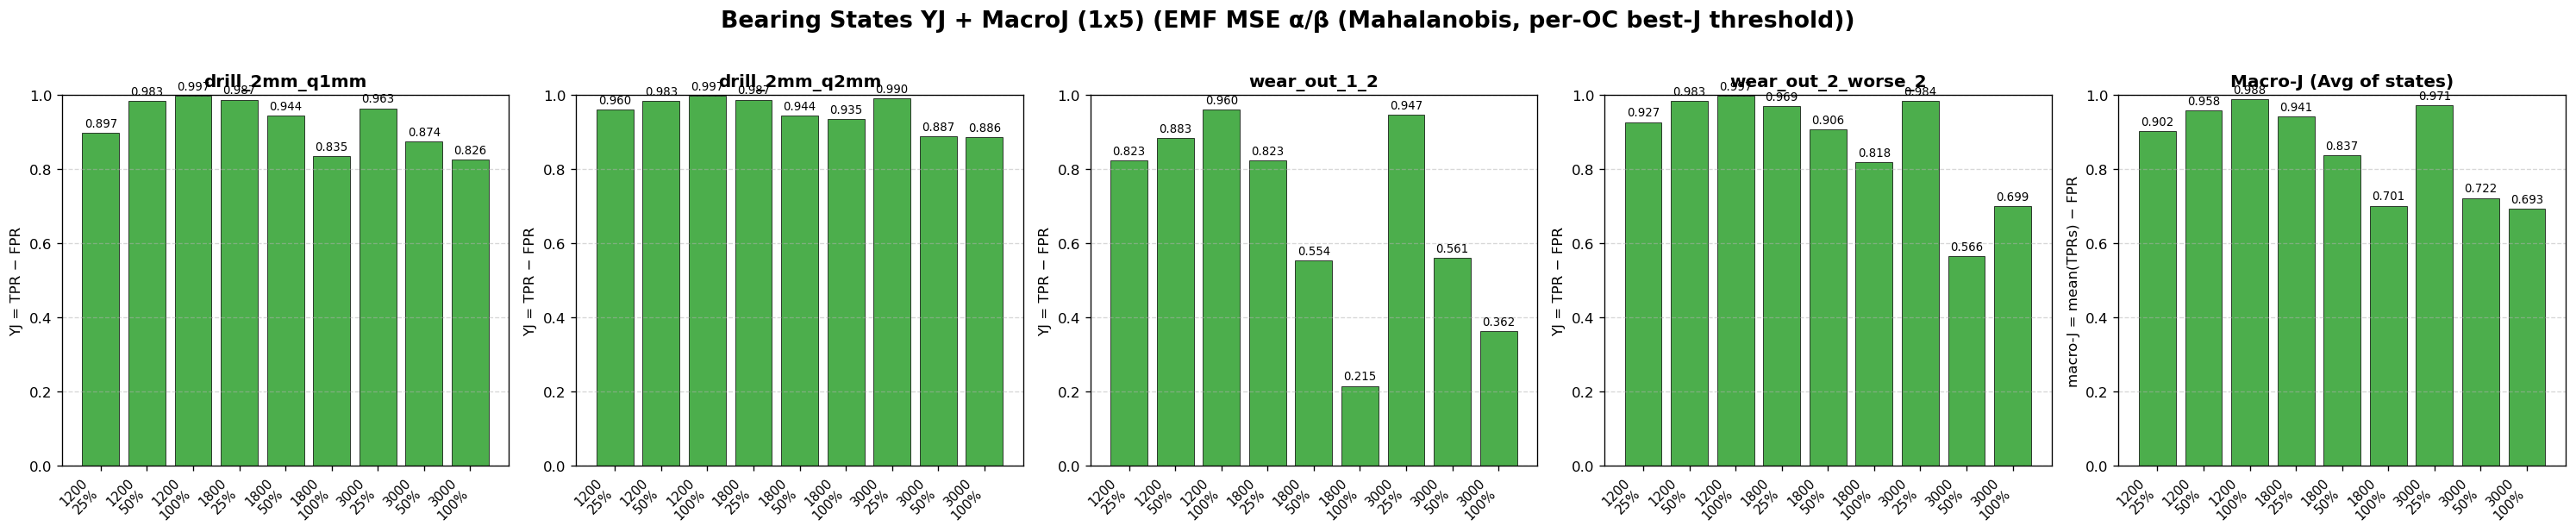

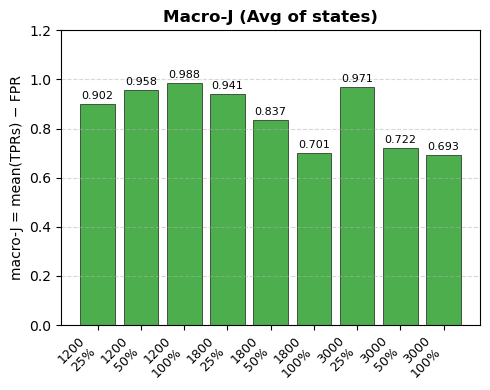

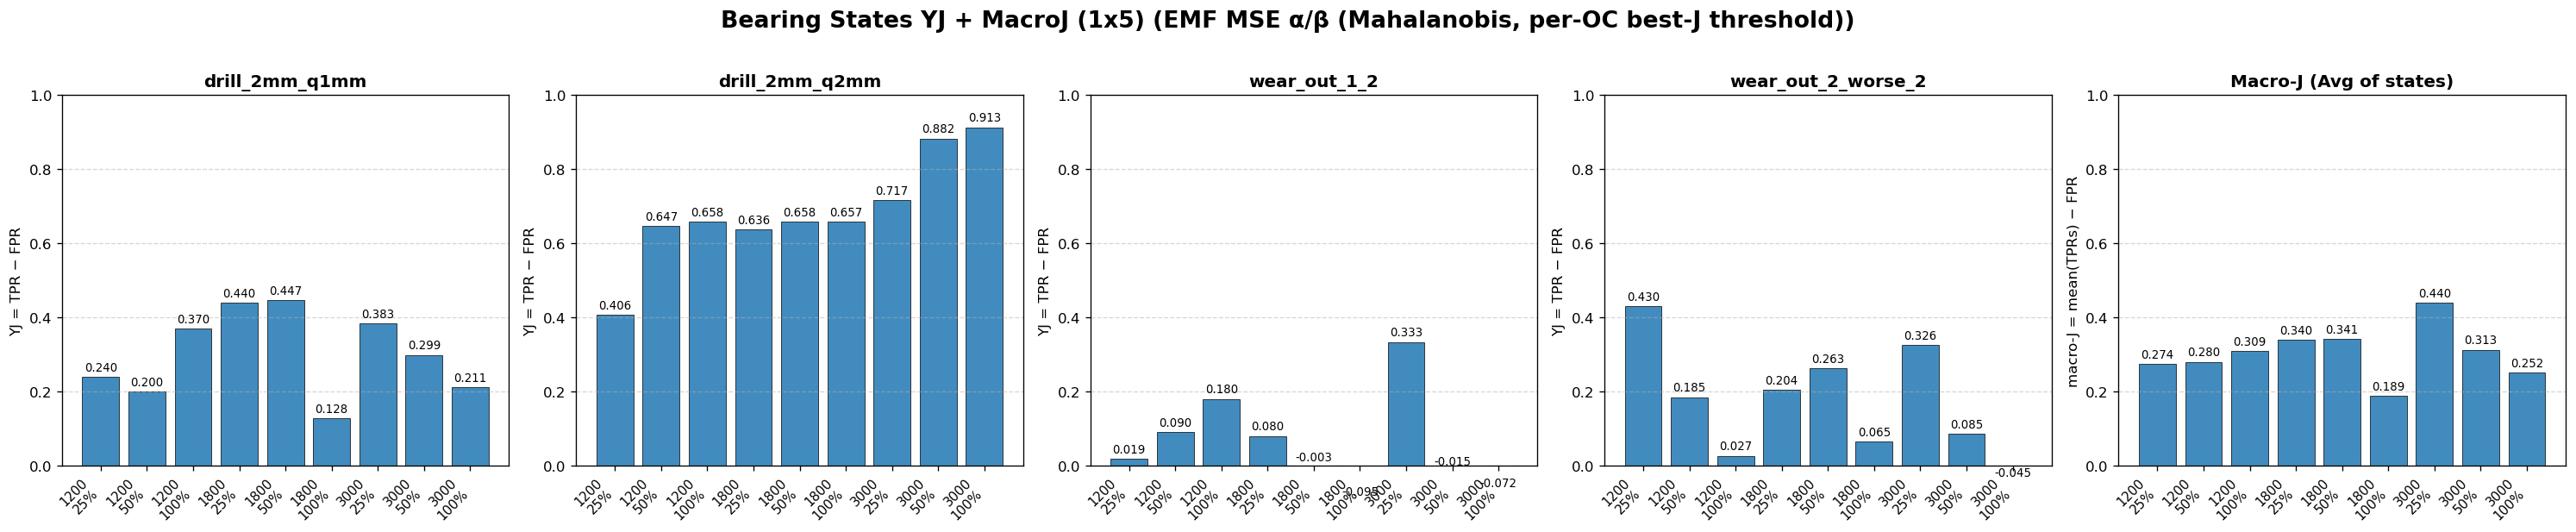

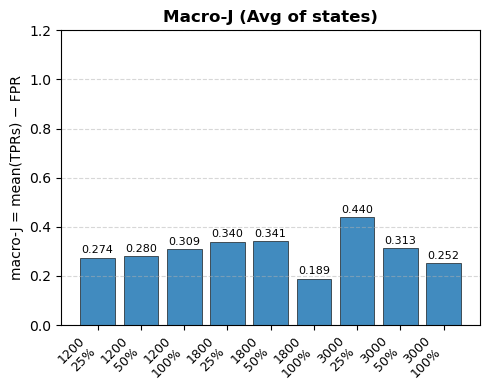

In [286]:
import numpy as np
import matplotlib.pyplot as plt

def create_yj_and_macroJ_grid(per_op_cond_thresholds, dataset_name,
                              selected_bearing_states,
                              model_color='#2ca02c',
                              suptitle_prefix="Bearing States YJ + MacroJ",
                              oc_order=None):
    """
    建立 1x5 的圖：
      - 前 4 個子圖：每個 bearing state 的 YJ = TPR - FPR
      - 第 5 個子圖：總和 macro-J
    """
    # ===== 擷取資料 =====
    def extract_yj_data(per_op_cond_thresholds, selected_bearing_states):
        yj_by_state = {st: {} for st in selected_bearing_states}
        macroJ_by_oc, fpr_by_oc = {}, {}
        for oc, pack in per_op_cond_thresholds.items():
            snap = pack.get('summary_at_best', None)
            if not snap:
                continue
            FPR = float(snap.get('FPR', np.nan))
            per_state = snap.get('per_state', {})
            fpr_by_oc[oc] = FPR
            tprs = []
            for st in selected_bearing_states:
                info = per_state.get(st)
                if not info:
                    continue
                tpr_k = float(info.get('TPR', np.nan))
                if np.isfinite(tpr_k):
                    yj_by_state[st][oc] = tpr_k - FPR
                    tprs.append(tpr_k)
            if tprs:
                macroJ_by_oc[oc] = float(np.mean(tprs) - FPR)
        return yj_by_state, macroJ_by_oc

    yj_by_state, macroJ_by_oc = extract_yj_data(per_op_cond_thresholds, selected_bearing_states)

    # ===== 工況順序處理 =====
    operating_condition_mapping = {
        '1200 0.5v': '1200 0.5V', '1200 1.0v': '1200 1.0V', '1200 2.0v': '1200 2.0V',
        '1800 0.5v': '1800 0.5V', '1800 1.0v': '1800 1.0V', '1800 2.0v': '1800 2.0V',
        '3000 0.5v': '3000 0.5V', '3000 1.0v': '3000 1.0V', '3000 2.0v': '3000 2.0V'
    }
    operating_short_labels = {
        '1200 0.5V': '1200\n25%', '1200 1.0V': '1200\n50%', '1200 2.0V': '1200\n100%',
        '1800 0.5V': '1800\n25%', '1800 1.0V': '1800\n50%', '1800 2.0V': '1800\n100%',
        '3000 0.5V': '3000\n25%', '3000 1.0V': '3000\n50%', '3000 2.0V': '3000\n100%'
    }

    # 全部工況
    all_op = set().union(*[set(d.keys()) for d in yj_by_state.values()]) if yj_by_state else set()
    mapped_list = [(orig, operating_condition_mapping.get(orig, orig)) for orig in all_op]
    if oc_order is None:
        oc_order = [m for (_, m) in sorted(mapped_list) if m in operating_short_labels]

    # ===== 繪圖佈局 =====
    fig, axes = plt.subplots(1, 5, figsize=(25, 5), dpi=120, sharey=False)
    fig.suptitle(f"{suptitle_prefix} ({dataset_name})", fontsize=16, fontweight="bold", y=1.02)

    # --- 前四個子圖：各 state 的 YJ ---
    for i, st in enumerate(selected_bearing_states):
        ax = axes[i]
        vals, labels = [], []
        for mapped in oc_order:
            orig = next((o for o, m in mapped_list if m == mapped), mapped)
            labels.append(mapped)
            vals.append(yj_by_state.get(st, {}).get(orig, 0.0))
        x = np.arange(len(labels))
        bars = ax.bar(x, vals, color=model_color, edgecolor='black', linewidth=0.5, alpha=0.85)
        for b, v in zip(bars, vals):
            ax.text(b.get_x()+b.get_width()/2., v+0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=8)
        ax.set_title(f"{st}", fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([operating_short_labels.get(lbl, lbl) for lbl in labels],
                           rotation=45, ha='right', fontsize=9)
        ax.set_ylabel("YJ = TPR − FPR")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.set_ylim(0, 1)

    # --- 第五個子圖：macro-J ---
    ax = axes[-1]
    vals, labels = [], []
    for mapped in oc_order:
        orig = next((o for o, m in mapped_list if m == mapped), mapped)
        labels.append(mapped)
        vals.append(macroJ_by_oc.get(orig, 0.0))
    x = np.arange(len(labels))
    bars = ax.bar(x, vals, color=model_color, edgecolor='black', linewidth=0.5, alpha=0.85)
    for b, v in zip(bars, vals):
        ax.text(b.get_x()+b.get_width()/2., v+0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=8)
    ax.set_title("Macro-J (Avg of states)", fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([operating_short_labels.get(lbl, lbl) for lbl in labels],
                       rotation=45, ha='right', fontsize=9)
    ax.set_ylabel("macro-J = mean(TPRs) − FPR")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(5, 4))

    labels = []
    vals = []

    for mapped in oc_order:
        orig = next((o for o, m in mapped_list if m == mapped), mapped)
        labels.append(mapped)
        vals.append(macroJ_by_oc.get(orig, 0.0))

    x = np.arange(len(labels))
    bars = plt.bar(x, vals, color=model_color, edgecolor='black', linewidth=0.5, alpha=0.85)

    # 在柱子上方加數字
    for b, v in zip(bars, vals):
        plt.text(b.get_x() + b.get_width()/2., v + 0.01, f"{v:.3f}",
                ha='center', va='bottom', fontsize=8)

    plt.title("Macro-J (Avg of states)", fontsize=12, fontweight='bold')

    # 設定 x 軸
    plt.xticks(x,
            [operating_short_labels.get(lbl, lbl) for lbl in labels],
            rotation=45, ha='right', fontsize=9)

    # y 軸
    plt.ylabel("macro-J = mean(TPRs) − FPR")

    plt.ylim(0, 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
    plt.close()

# ===== 呼叫示例 =====
selected_bearing_states = ['drill_2mm_q1mm', 'drill_2mm_q2mm', 'wear_out_1_2', 'wear_out_2_worse_2']

create_yj_and_macroJ_grid(
    per_op_cond_thresholds=per_op_cond_thresholds_VI,
    dataset_name="EMF MSE α/β (Mahalanobis, per-OC best-J threshold)",
    selected_bearing_states=selected_bearing_states,
    model_color='#2ca02c',
    suptitle_prefix="Bearing States YJ + MacroJ (1x5)",
    oc_order=None  # 你可以給定 ["1200 0.5V", ..., "3000 2.0V"]
)

create_yj_and_macroJ_grid(
    per_op_cond_thresholds=per_op_cond_thresholds_II,
    dataset_name="EMF MSE α/β (Mahalanobis, per-OC best-J threshold)",
    selected_bearing_states=selected_bearing_states,
    model_color='#1f77b4',
    suptitle_prefix="Bearing States YJ + MacroJ (1x5)",
    oc_order=None  # 你可以給定 ["1200 0.5V", ..., "3000 2.0V"]
)



=== 檢查 Dataset-A (EMF MSE α/β; per-OC best-J) 資料結構 ===
第一個運轉條件 (1200 0.5v) 的結構:
  比較軸承工況: ['Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q2mm', 'wear_out_1_2', 'wear_out_2_worse_2']
  第一個軸承工況 (Normal2-2) 的統計資料:
    member_in: 287
    member_out: 13
    member_out_rate: 0.043333333333333335
顯示選定的軸承狀態 (5 個): ['Normal2-2', 'drill_2mm_q1mm', 'drill_2mm_q2mm', 'wear_out_1_2', 'wear_out_2_worse_2']

可用的運轉條件 (9個):

Y軸範圍: 0 - 115.0%

正在生成基於 Dataset-A (EMF MSE α/β; per-OC best-J) 的軸承狀態準確率比較圖（每工況專屬 YJ 折線）...
圖表佈局: 5×1 (5 個軸承狀態)


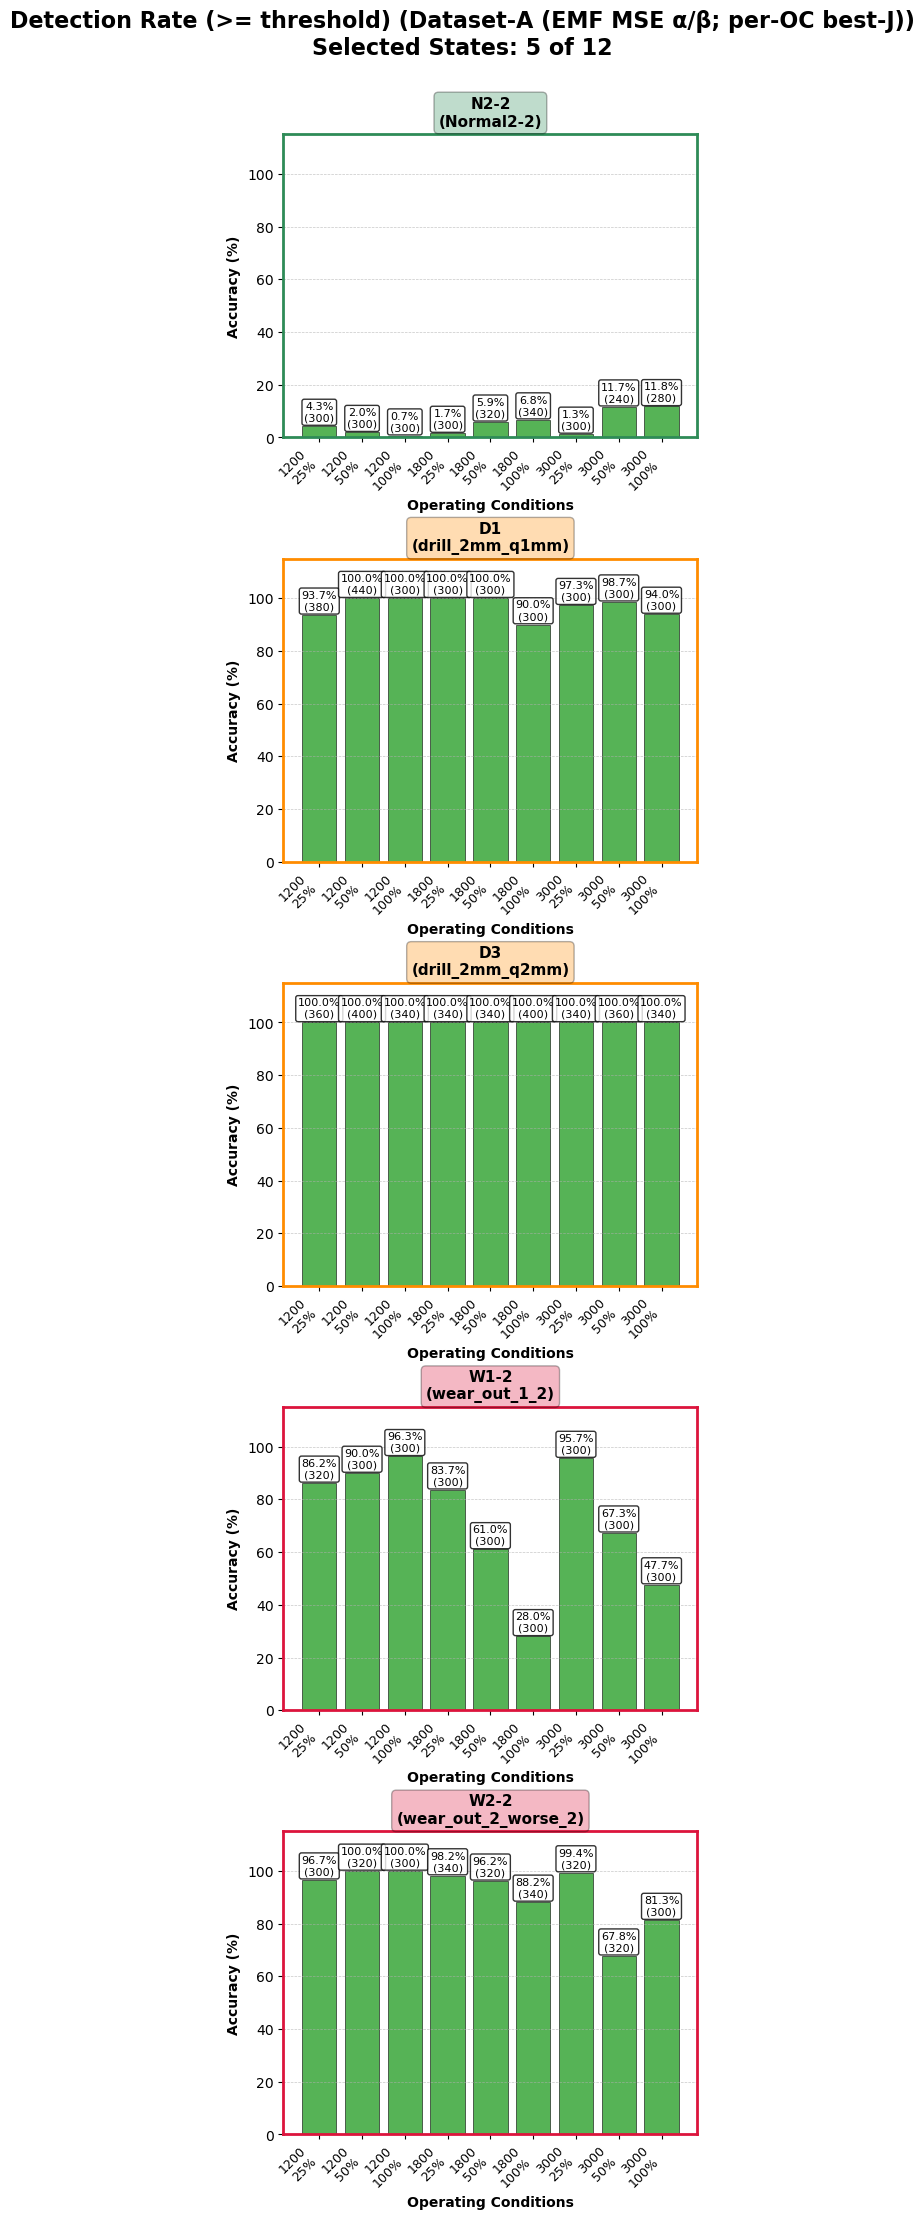

✅ 基於 Dataset-A (EMF MSE α/β; per-OC best-J) 的軸承狀態準確率比較圖完成（每工況專屬 YJ 折線）


In [279]:
def create_bearing_accuracy_comparison(operating_results, dataset_name, model_color='#2ca02c', 
                                     suptitle_prefix="Bearing States Accuracy Comparison",
                                     selected_bearing_states=None,
                                     per_op_cond_thresholds=None,
                                     yj_as_percent=True,
                                     yj_line_width=2.0,
                                     yj_marker='o',
                                     yj_color='black'):
    """
    通用函式：建立各軸承狀態的柱狀圖（accuracy），並疊加「該運轉條件 × 該軸承工況」的 Youden's J 折線。

    關鍵變更：
    - 僅使用 per-class（該軸承工況）的 YJ；若該工況在該運轉條件沒有 YJ，該點為 NaN，不回退 macro/平均值。
    """

    # ===== 檢查輸入資料結構（維持你原本的提示）=====
    print(f"=== 檢查 {dataset_name} 資料結構 ===")
    if operating_results:
        first_op_cond = next(iter(operating_results.keys()))
        print(f"第一個運轉條件 ({first_op_cond}) 的結構:")
        if 'comparisons' in operating_results[first_op_cond]:
            comparisons = operating_results[first_op_cond]['comparisons']
            print(f"  比較軸承工況: {list(comparisons.keys())}")
            if comparisons:
                first_bearing = next(iter(comparisons.keys()))
                print(f"  第一個軸承工況 ({first_bearing}) 的統計資料:")
                if 'member_stats' in comparisons[first_bearing]:
                    member_stats = comparisons[first_bearing]['member_stats']
                    print(f"    member_in: {member_stats.get('members_in', 'N/A')}")
                    print(f"    member_out: {member_stats.get('members_out', 'N/A')}")
                    print(f"    member_out_rate: {member_stats.get('members_out_rate', 'N/A')}")

    # ===== 從 operating_results 提取 accuracy（維持原邏輯）=====
    def extract_bearing_accuracy(op_results):
        accuracy_data = {}
        for op_cond, op_data in op_results.items():
            if 'comparisons' not in op_data:
                continue
            accuracy_data[op_cond] = {}
            for bearing_cond, comparison_data in op_data['comparisons'].items():
                if 'member_stats' not in comparison_data:
                    continue
                member_stats = comparison_data['member_stats']
                out_rate = member_stats.get('members_out_rate', 0)
                accuracy_rate = out_rate * 100 if out_rate <= 1.0 else out_rate
                accuracy_data[op_cond][bearing_cond] = {
                    'accuracy': accuracy_rate,
                    'members_in': member_stats.get('members_in', 0),
                    'members_out': member_stats.get('members_out', 0),
                    'total_samples': member_stats.get('members_in', 0) + member_stats.get('members_out', 0)
                }
        return accuracy_data

    accuracy_data = extract_bearing_accuracy(operating_results)

    # ===== 軸承狀態定義 =====
    all_bearing_states = ['Normal1', 'Normal1-2', 'Normal2', 'Normal2-2', 
                          'drill_2mm_q1mm', 'drill_2mm_q1mm_2', 'drill_2mm_q2mm',
                          'wear_out_1', 'wear_out_1_2', 'wear_out_2_worse', 'wear_out_2_worse_2',
                          'validation']

    if selected_bearing_states is None:
        bearing_states = all_bearing_states.copy()
        print(f"顯示所有軸承狀態 ({len(bearing_states)} 個)")
    else:
        valid_states = [state for state in selected_bearing_states if state in all_bearing_states]
        invalid_states = [state for state in selected_bearing_states if state not in all_bearing_states]
        if invalid_states:
            print(f"⚠️  警告: 以下軸承狀態無效，將被忽略: {invalid_states}")
        bearing_states = valid_states
        print(f"顯示選定的軸承狀態 ({len(bearing_states)} 個): {bearing_states}")
        if not bearing_states:
            print("❌ 錯誤: 沒有有效的軸承狀態可顯示")
            return accuracy_data

    bearing_labels = {
        'Normal1': 'N1', 'Normal1-2': 'N1-2', 'Normal2': 'N2', 'Normal2-2': 'N2-2',
        'drill_2mm_q1mm': 'D1', 'drill_2mm_q1mm_2': 'D2', 'drill_2mm_q2mm': 'D3',
        'wear_out_1': 'W1', 'wear_out_1_2': 'W1-2',
        'wear_out_2_worse': 'W2', 'wear_out_2_worse_2': 'W2-2',
        'validation': 'Val'
    }

    # ===== 運轉條件映射 =====
    operating_condition_mapping = {
        '1200 0.5v': '1200 0.5V', '1200 1.0v': '1200 1.0V', '1200 2.0v': '1200 2.0V',
        '1800 0.5v': '1800 0.5V', '1800 1.0v': '1800 1.0V', '1800 2.0v': '1800 2.0V',
        '3000 0.5v': '3000 0.5V', '3000 1.0v': '3000 1.0V', '3000 2.0v': '3000 2.0V'
    }
    operating_short_labels = {
        '1200 0.5V': '1200\n25%', '1200 1.0V': '1200\n50%', '1200 2.0V': '1200\n100%',
        '1800 0.5V': '1800\n25%', '1800 1.0V': '1800\n50%', '1800 2.0V': '1800\n100%',
        '3000 0.5V': '3000\n25%', '3000 1.0V': '3000\n50%', '3000 2.0V': '3000\n100%'
    }

    # ===== 狀態類型與顏色（框線）=====
    bearing_state_types = {
        'Normal1': 'normal', 'Normal1-2': 'normal', 'Normal2': 'normal', 'Normal2-2': 'normal',
        'drill_2mm_q1mm': 'drill', 'drill_2mm_q1mm_2': 'drill', 'drill_2mm_q2mm': 'drill',
        'wear_out_1': 'wear', 'wear_out_1_2': 'wear', 'wear_out_2_worse': 'wear', 'wear_out_2_worse_2': 'wear',
        'validation': 'validation'
    }
    type_colors = {
        'normal': '#2E8B57',
        'drill': '#FF8C00',
        'wear': '#DC143C',
        'validation': '#9370DB'
    }

    # ===== 可用運轉條件（依 accuracy_data）=====
    available_op_conditions = []
    for orig_cond in accuracy_data.keys():
        mapped_cond = operating_condition_mapping.get(orig_cond, orig_cond)
        if mapped_cond in operating_short_labels:
            available_op_conditions.append((orig_cond, mapped_cond))
    print(f"\n可用的運轉條件 ({len(available_op_conditions)}個):")

    import numpy as np

    # ===== 只取「該工況」的 YJ；沒有就回 None（不回退 macro）=====
    def _extract_class_yj(summary_at_best, bearing_state):
        if not isinstance(summary_at_best, dict):
            return None
        # 依你可能的 key 來嘗試（可再調整成你實際的結構）
        paths = [
            ('per_class', bearing_state, 'youden_j'),
            ('per_class', bearing_state, 'J'),
            ('per_class', bearing_state, 'youdenJ'),
            ('classes',    bearing_state, 'youden_j'),
            ('classes',    bearing_state, 'J'),
        ]
        for p in paths:
            d = summary_at_best
            ok = True
            for key in p:
                if key in d:
                    d = d[key]
                else:
                    ok = False
                    break
            if ok and isinstance(d, (int, float)):
                return float(d)
        return None

    def get_yj_for(op_cond, bearing_state):
        if per_op_cond_thresholds is None:
            return None
        pack = per_op_cond_thresholds.get(op_cond, {})
        sab = pack.get('summary_at_best', None)
        if sab is None:
            return None
        # 僅回傳 per-class；若取不到就 None
        return _extract_class_yj(sab, bearing_state)

    # ===== 決定左側 accuracy Y 軸範圍 =====
    all_accuracy_values = []
    for op_cond, bearing_data in accuracy_data.items():
        for bearing_state, stats in bearing_data.items():
            if bearing_state in bearing_states:
                accuracy = stats.get('accuracy', 0)
                if not np.isnan(accuracy) and accuracy > 0:
                    all_accuracy_values.append(accuracy)
    y_max = max(all_accuracy_values) * 1.15 if all_accuracy_values else 100.0
    print(f"\nY軸範圍: 0 - {y_max:.1f}%")

    # ===== 佈局 =====
    print(f"\n正在生成基於 {dataset_name} 的軸承狀態準確率比較圖（每工況專屬 YJ 折線）...")
    num_states = len(bearing_states)
    if num_states <= 4:
        rows, cols = 1, num_states
        figsize = (5*num_states, 6)
    elif num_states == 5:
        rows, cols = 5, 1
        figsize = (5, 25)
    elif num_states <= 8:
        rows, cols = 2, 4
        figsize = (20, 10)
    elif num_states <= 12:
        rows, cols = 3, 4
        figsize = (20, 15)
    else:
        rows, cols = 4, 4
        figsize = (20, 20)
    print(f"圖表佈局: {rows}×{cols} ({num_states} 個軸承狀態)")

    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)

    fig.suptitle(f"{suptitle_prefix} ({dataset_name})\nSelected States: {len(bearing_states)} of {len(all_bearing_states)}", 
                 fontsize=16, fontweight="bold", y=0.95)

    axes_flat = axes.flatten()

    # ===== 子圖繪製 =====
    for state_idx, bearing_state in enumerate(bearing_states):
        ax = axes_flat[state_idx]

        # 準備 X 與 accuracy
        op_conditions_for_plot = []
        accuracy_values = []
        sample_counts = []
        for orig_op_cond, mapped_op_cond in available_op_conditions:
            op_conditions_for_plot.append(mapped_op_cond)
            if (orig_op_cond in accuracy_data and bearing_state in accuracy_data[orig_op_cond]):
                stats = accuracy_data[orig_op_cond][bearing_state]
                accuracy = stats.get('accuracy', 0)
                total_samples = stats.get('total_samples', 0)
                accuracy_values.append(accuracy)
                sample_counts.append(total_samples)
            else:
                accuracy_values.append(0)
                sample_counts.append(0)

        # 柱狀圖（accuracy）
        x_positions = np.arange(len(op_conditions_for_plot))
        bars = ax.bar(x_positions, accuracy_values, 
                      color=model_color, alpha=0.8, edgecolor='black', linewidth=0.5)

        for i, (bar, accuracy, samples) in enumerate(zip(bars, accuracy_values, sample_counts)):
            if accuracy > 0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + y_max*0.01,
                        f'{accuracy:.1f}%\n({samples})',
                        ha='center', va='bottom', fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

        # 疊加「該工況自己的」YJ 折線（右軸）
        if per_op_cond_thresholds is not None and len(op_conditions_for_plot) > 0:
            yj_vals = []
            # 注意：這裡使用 available_op_conditions 的原始 op_cond 順序來對齊
            for orig_op_cond, _mapped in available_op_conditions:
                yj = get_yj_for(orig_op_cond, bearing_state)
                if yj is None:
                    yj_vals.append(np.nan)
                else:
                    yj_vals.append(yj * 100.0 if yj_as_percent else yj)

            if not all(np.isnan(v) for v in yj_vals):
                ax2 = ax.twinx()
                ax2.plot(x_positions, yj_vals, linewidth=yj_line_width, marker=yj_marker,
                         linestyle='-', color=yj_color, label="Youden's J (per-condition)")
                # 右軸
                if yj_as_percent:
                    ax2.set_ylabel("Youden's J (%)", fontsize=10, fontweight='bold')
                    finite_vals = [v for v in yj_vals if np.isfinite(v)]
                    if finite_vals:
                        ymax_yj = max(finite_vals) * 1.15
                        ax2.set_ylim(0, max(100.0, ymax_yj))
                    else:
                        ax2.set_ylim(0, 100.0)
                else:
                    ax2.set_ylabel("Youden's J", fontsize=10, fontweight='bold')
                    ax2.set_ylim(0, 1.0)
                ax2.legend(loc='upper left', fontsize=8, framealpha=0.8)

        # 外觀
        state_type = bearing_state_types.get(bearing_state, 'normal')
        state_color = type_colors.get(state_type, '#808080')

        ax.set_xlabel('Operating Conditions', fontsize=10, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=10, fontweight='bold')
        ax.set_title(f"{bearing_labels.get(bearing_state, bearing_state)}\n({bearing_state})", 
                     fontsize=11, fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor=state_color, alpha=0.3))
        ax.set_xticks(x_positions)
        ax.set_xticklabels([operating_short_labels.get(op, op) for op in op_conditions_for_plot], 
                           rotation=45, ha='right', fontsize=9)
        ax.set_ylim(0, y_max)
        ax.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.5)

        for spine in ax.spines.values():
            spine.set_color(state_color)
            spine.set_linewidth(2)

    # 隱藏多餘子圖
    total_subplots = rows * cols
    for i in range(num_states, total_subplots):
        axes_flat[i].set_visible(False)

    # （可選）類型圖例
    legend_ax_idx = min(num_states - 1, total_subplots - 1)
    if num_states > 0:
        state_handles = [
            Rectangle((0,0),1,1, facecolor=type_colors['normal'], alpha=0.5, label='Normal'),
            Rectangle((0,0),1,1, facecolor=type_colors['drill'], alpha=0.5, label='Drill Fault'),
            Rectangle((0,0),1,1, facecolor=type_colors['wear'], alpha=0.5, label='Wear Fault'),
            Rectangle((0,0),1,1, facecolor=type_colors['validation'], alpha=0.5, label='Validation')
        ]
        # 若要顯示，解除下行註解
        # axes_flat[legend_ax_idx].legend(handles=state_handles, loc='upper right', 
        #                                 fontsize=10, title='Bearing Types',
        #                                 bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.10, hspace=0.4, wspace=0.3)
    plt.show()

    print(f"✅ 基於 {dataset_name} 的軸承狀態準確率比較圖完成（每工況專屬 YJ 折線）")
    return accuracy_data


_ = create_bearing_accuracy_comparison(
    operating_results=operating_results_VI,
    dataset_name="Dataset-A (EMF MSE α/β; per-OC best-J)",
    model_color='#2ca02c',
    suptitle_prefix="Detection Rate (>= threshold)",
    selected_bearing_states=[healthy_state] + selected_bearing_states,
    per_op_cond_thresholds=per_op_cond_thresholds_VI,  # 只用 per-class，不會回退平均
    yj_as_percent=True,
    yj_marker='o', yj_color='black'
)

In [225]:
def list_model_MSEs(Normal_subfolders, model, test_size=0.5):
    # 列出目標資料夾下的檔案重建誤差以找出離群值
    augmen_sample_number=100
    """取得指定工況資料夾下的所有檔案，並找出離群值"""
    parquet_files = [os.path.join(Normal_subfolders, f) for f in os.listdir(Normal_subfolders) if f.endswith(".parquet")]
    apply_parquet_files = parquet_files

    list_mse={}
    for file_path in apply_parquet_files:
        train_signals=[] # vi signals alpha beta
        train_signals_normalized=[]
        torque_array=[]
        speed_array_pu=[]
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist.")
            continue
        # 讀取資料
        df = read_rul_data(file_path, force_recompute=False)
        if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        if (flux_alpha.shape[0] != current_alpha.shape[0]):
            print(f"File {file_path} has mismatched flux and current lengths, skipping.")
            print(f"flux_alpha length: {flux_alpha.shape[0]}, current_alpha length: {current_alpha.shape[0]}")
            continue
        torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
          
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals = [np.array(df["Voltage alpha downsample"]), 
                              np.array(df["Voltage beta downsample"]),
                              current_alpha,
                              current_beta,
                              flux_alpha,
                              flux_beta,
                              emf_alpha,
                              emf_beta,
                              torque_airgap]
        
        # 將數據正規化到 [-1, 1] 範圍
        temp_train_signals_normalized = []
        # for signal in temp_train_signals:
        #     min_val = np.min(signal)
        #     max_val = np.max(signal)
        #     # 避免除以零的狀況（max == min）
        #     if max_val == min_val:
        #         normalized = np.zeros_like(signal)
        #     else:
        #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
        #     temp_train_signals_normalized.append(normalized)
            
        # 將數據標準化（均值為 0，標準差為 1）
        
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
        
        
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        try:
            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        except ValueError as e:
            print(f"Error stacking signals for file {file_path}: {e}")
            print(f"datalength {len(df['Voltage alpha downsample'])}")
            continue
        
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, 1024, augmen_sample_number=100,future_length=512)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, 1024, augmen_sample_number=100,future_length=512)
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
        train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
        train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
        torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
        speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
        
        apply_input_data = train_signals_normalized[:, :sequence_length, 0:2]  # 過去 emf
        apply_output_data = train_signals_normalized[:, :sequence_length, 2:4]  # 過去 current（僅用於比較/誤差）
        check_reconstruction_normal = model.predict(
            [apply_input_data,
            speed_array_pu.reshape(-1, 1),
            torque_array.reshape(-1, 1)],
            batch_size=128,
            verbose=0
        )

        error = apply_output_data[:, :, 0] - check_reconstruction_normal[:, :, 0]
        error_mse = np.mean(np.square(error),axis=1)  # 計算每個樣本的 MSE
        list_mse[file_path] = error_mse.mean()
        error2 = apply_output_data[:, :, 1] - check_reconstruction_normal[:, :, 1]
        print(file_path)
        print("MSE:", error_mse.mean(), np.mean(np.square(error2),axis=1).mean())
    # 將 list_mse 的 key 按照 mse 值排序並列出
    sorted_mse = sorted(list_mse.items(), key=lambda item: item[1])
    print("檔案依MSE排序：")
    for file_path, mse in sorted_mse:
        print(f"{file_path}: {mse}")
    return error_mse

my_model_V_in_I_out= load_model(os.path.join(model_path, model_name + '_VI.keras'))
# D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 3000 2.0v  2kg cm2
list_model_MSEs(r"D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 3000 1.0v 2kg cm2", my_model_V_in_I_out, test_size=1)

# list_model_MSEs(r"D:\OneDrive\CCAE_experiments\CCAE_datasets2\drill 2mm 1mm q\drill 2mm 1mm q 1200 1.0v 2kg cm2", my_model_V_in_I_out, test_size=1)

#健康資料集
Normal_subfolders = list_subfolders(os.path.join(NTU_dataset_path, normal_condition))
# 建立一個字典來儲存每個資料夾的檔案資料與數據
normal_datasets = {}
for folder in Normal_subfolders:
    normal_datasets[folder],_ = get_apply_files_data(folder, test_size=1)

D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 3000 1.0v 2kg cm2\RUL_Data_3_10.parquet
MSE: 0.002009952 0.001687457
D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 3000 1.0v 2kg cm2\RUL_Data_3_13.parquet
MSE: 0.0022961441 0.00216817
D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 3000 1.0v 2kg cm2\RUL_Data_3_15.parquet
MSE: 0.0019520409 0.0016585748
D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 3000 1.0v 2kg cm2\RUL_Data_3_17.parquet
MSE: 0.0017172153 0.0014939806
D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 3000 1.0v 2kg cm2\RUL_Data_3_18.parquet
MSE: 0.0020138798 0.0018598863
D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 3000 1.0v 2kg cm2\RUL_Data_3_19.parquet
MSE: 0.0020258103 0.002048848
D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 3000 1.0v 2kg cm2\RUL_Data_3_2.parquet
MSE: 0.0022562623 0.00160401
D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Nor

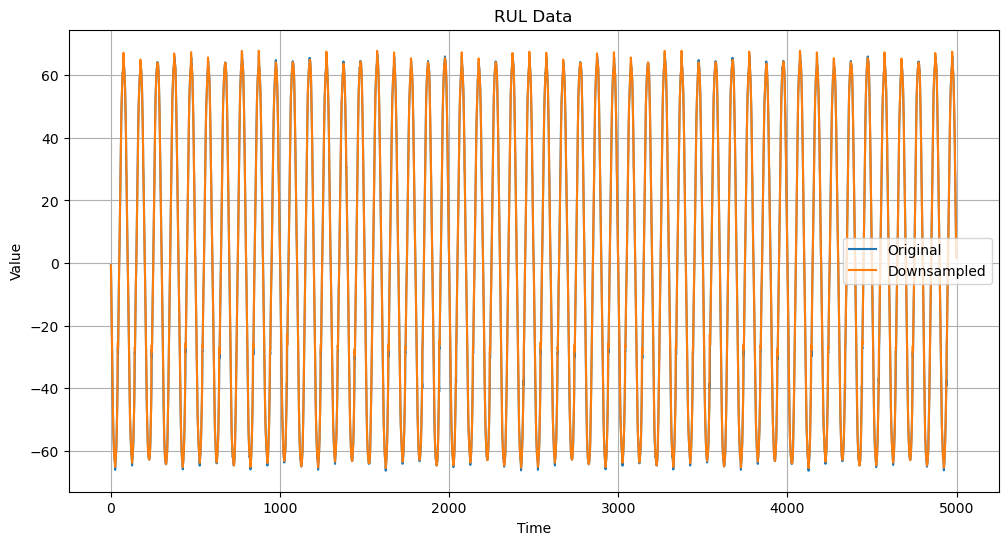

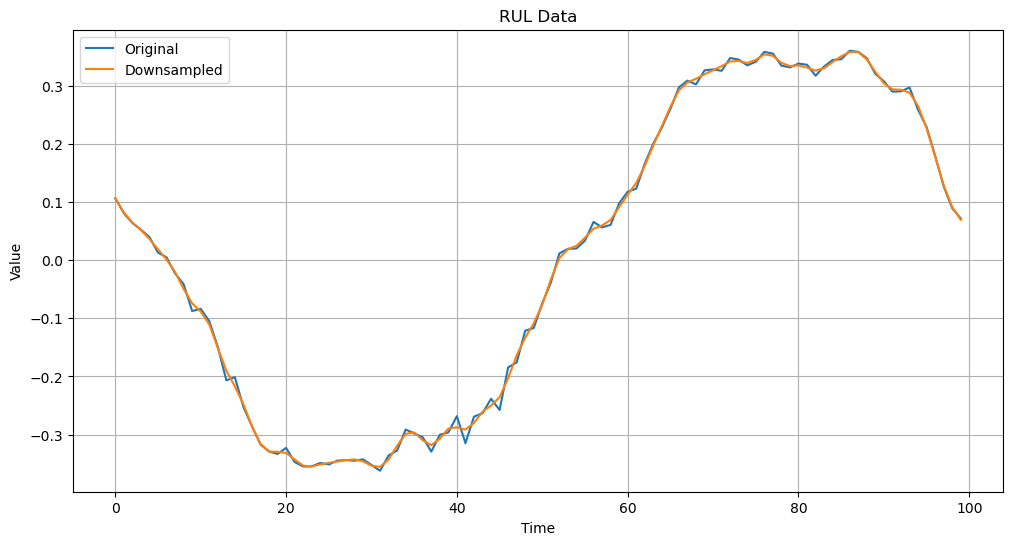

In [54]:

Normal_subfolders=r"D:\OneDrive\CCAE_experiments\CCAE_datasets3_1\Normal2-2\Normal2-2 3000 0.5v 2kg cm2"
parquet_files = [os.path.join(Normal_subfolders, f) for f in os.listdir(Normal_subfolders) if f.endswith(".parquet")]
i=7
df = read_rul_data(parquet_files[i], force_recompute=False)

plt.figure(figsize=(12, 6))
plt.plot(df['Voltage alpha'], label='Original')
plt.plot(df['Voltage alpha downsample'], label='Downsampled')

plt.grid()
plt.title('RUL Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(df['Current alpha'][:100], label='Original')
plt.plot(df['Current alpha downsample'][:100], label='Downsampled')

plt.grid()
plt.title('RUL Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
